# Synthea Capstone Project - Pre-processing and Training Data Development

#### In the pre-processing and training data development section of this capstone, missing values in the dataset will be imputed using various techniques. Then, multiple models will be built to develop a predictive tool for healthcare encounter costs. The models will built, fine tuned, and assessed using the mean encounters cost as a baseline model. In the end, the best model will be selected based on R squared values and mean error values.

#### Module importation and data exploration

Relevant modules are imported into the workspace.

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fancyimpute import KNN, IterativeImputer
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

First, the dataframe from the EDA section of the capstone is loaded into the workspace and observed.

In [7]:
df = pd.read_csv('synthea_eda.csv')
df.head()

Unnamed: 0  ETHNICITY  GENDER  INCOME  AGE  encounters_cost  \
0           0          0       1   21478    3          8748.80   
1           1          0       1   89823   42          4659.91   
2           2          0       1   54400   23              NaN   
3           3          0       1   35376   16          2817.62   
4           4          0       1   93837   34          4301.42   

   num_encounters  meds_cost  num_meds  num_procedures  ...  \
0             4.0        NaN       NaN            17.0  ...   
1             5.0      14.90       2.0            13.0  ...   
2             NaN        NaN       NaN             NaN  ...   
3             4.0        NaN       NaN            11.0  ...   
4             2.0     290.14       2.0            12.0  ...   

   Urea nitrogen [Mass/volume] in Blood  \
0                                   NaN   
1                                  18.7   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   Urea nitrogen [Mass/volume] in Serum or Plasma  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   

   Weight-for-length Per age and sex  pH of Urine by Test strip  asian  black  \
0                               45.2                        NaN      0      0   
1                                NaN                        NaN      0      0   
2                                NaN                        NaN      0      0   
3                                NaN                        NaN      0      1   
4                                NaN                        NaN      0      0   

   hawaiian  native  white  STATE_POPULATION  
0         0       0      1         4903185.0  
1         0       0      1         4903185.0  
2         0       0      1         4903185.0  
3         0       0      0         4903185.0  
4         0       0      1         4903185.0  

[5 rows x 101 columns]

There appears to be an extra unnamed column, so that will be dropped.

In [9]:
df = df.drop('Unnamed: 0', axis = 1)

In [10]:
df.shape

(5000, 100)

In [11]:
df.describe()

ETHNICITY      GENDER        INCOME          AGE  encounters_cost  \
count  5000.000000  5000.00000    5000.00000  5000.000000      4660.000000   
mean      0.120200     0.49980   87462.89980    37.868600     15907.685077   
std       0.325228     0.50005  131846.10156    23.516512     35591.339255   
min       0.000000     0.00000      34.00000    -1.000000        59.640000   
25%       0.000000     0.00000   26819.75000    18.000000      1367.777500   
50%       0.000000     0.00000   54104.50000    37.000000      4740.970000   
75%       0.000000     1.00000   95080.25000    56.000000     11366.022500   
max       1.000000     1.00000  986892.00000   109.000000    709730.300000   

       num_encounters     meds_cost     num_meds  num_procedures  \
count     4660.000000  3.431000e+03  3431.000000     4384.000000   
mean         6.127682  4.241395e+03     7.934130       19.651004   
std         13.824188  4.721942e+04    21.361822       27.436335   
min          1.000000  9.000000e-01     1.000000        1.000000   
25%          2.000000  1.975600e+02     1.000000        6.000000   
50%          3.000000  5.850400e+02     2.000000       12.000000   
75%          5.000000  3.393460e+03     5.000000       19.000000   
max        129.000000  2.726640e+06   364.000000      205.000000   

       immunizations_cost  ...  Urea nitrogen [Mass/volume] in Blood  \
count         4226.000000  ...                            1974.00000   
mean           235.988642  ...                              13.52614   
std            269.515714  ...                               3.77836   
min            136.000000  ...                               7.00000   
25%            136.000000  ...                              10.30000   
50%            136.000000  ...                              13.50000   
75%            272.000000  ...                              16.80000   
max           2720.000000  ...                              20.00000   

       Urea nitrogen [Mass/volume] in Serum or Plasma  \
count                                      790.000000   
mean                                        13.707848   
std                                          3.740050   
min                                          7.000000   
25%                                         10.600000   
50%                                         13.900000   
75%                                         16.900000   
max                                         20.000000   

       Weight-for-length Per age and sex  pH of Urine by Test strip  \
count                         847.000000                1047.000000   
mean                           63.110508                   6.029131   
std                            26.917912                   0.661334   
min                             0.200000                   4.500000   
25%                            43.950000                   5.400000   
50%                            68.000000                   6.000000   
75%                            86.550000                   6.600000   
max                           100.000000                   8.000000   

             asian       black     hawaiian       native        white  \
count  5000.000000  5000.00000  5000.000000  5000.000000  5000.000000   
mean      0.046200     0.11280     0.016800     0.019600     0.789800   
std       0.209939     0.31638     0.128534     0.138635     0.407491   
min       0.000000     0.00000     0.000000     0.000000     0.000000   
25%       0.000000     0.00000     0.000000     0.000000     1.000000   
50%       0.000000     0.00000     0.000000     0.000000     1.000000   
75%       0.000000     0.00000     0.000000     0.000000     1.000000   
max       1.000000     1.00000     1.000000     1.000000     1.000000   

       STATE_POPULATION  
count      4.400000e+03  
mean       6.644565e+06  
std        7.645073e+06  
min        5.787590e+05  
25%        1.898843e+06  
50%        4.433266e+06  
75%        7.362761e+06  
max        3.951222e+07 

In [12]:
pd.options.display.max_rows = 100
df.dtypes

ETHNICITY                                                                                                                    int64
GENDER                                                                                                                       int64
INCOME                                                                                                                       int64
AGE                                                                                                                          int64
encounters_cost                                                                                                            float64
num_encounters                                                                                                             float64
meds_cost                                                                                                                  float64
num_meds                                                                           

Before modeling, missing values need to be imputed.

In [14]:
missing_values = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing_values.columns = ['count', '%']
missing_values.sort_values(by = 'count', ascending = False)

count      %
Hematocrit [Volume Fraction] of Blood                4522  90.44
Globulin [Mass/volume] in Serum by calculation       4474  89.48
Ketones [Mass/volume] in Urine by Test strip         4448  88.96
Bilirubin.total [Mass/volume] in Urine by Test ...   4448  88.96
Alkaline phosphatase [Enzymatic activity/volume...   4275  85.50
Bilirubin.total [Mass/volume] in Serum or Plasma     4275  85.50
Aspartate aminotransferase [Enzymatic activity/...   4275  85.50
Protein [Mass/volume] in Serum or Plasma             4275  85.50
Alkaline phosphatase [Enzymatic activity/volume...   4275  85.50
Alanine aminotransferase [Enzymatic activity/vo...   4275  85.50
Albumin [Mass/volume] in Serum or Plasma             4275  85.50
Oxygen saturation in Arterial blood                  4269  85.38
Carbon dioxide  total [Moles/volume] in Serum o...   4210  84.20
Chloride [Moles/volume] in Serum or Plasma           4210  84.20
Creatinine [Mass/volume] in Serum or Plasma          4210  84.20
Sodium [Moles/volume] in Serum or Plasma             4210  84.20
Potassium [Moles/volume] in Serum or Plasma          4210  84.20
Glucose [Mass/volume] in Serum or Plasma             4210  84.20
Urea nitrogen [Mass/volume] in Serum or Plasma       4210  84.20
Calcium [Mass/volume] in Serum or Plasma             4210  84.20
Fall risk total [Morse Fall Scale]                   4173  83.46
Head Occipital-frontal circumference                 4153  83.06
Head Occipital-frontal circumference Percentile      4153  83.06
Weight-for-length Per age and sex                    4153  83.06
num_allergies                                        4080  81.60
Glucose [Mass/volume] in Urine by Test strip         4030  80.60
Protein [Mass/volume] in Urine by Test strip         4030  80.60
pH of Urine by Test strip                            3953  79.06
Glomerular filtration rate/1.73 sq M.predicted ...   3861  77.22
Body mass index (BMI) [Percentile] Per age and sex   3215  64.30
Hemoglobin A1c/Hemoglobin.total in Blood             3135  62.70
Creatinine [Mass/volume] in Blood                    3026  60.52
Urea nitrogen [Mass/volume] in Blood                 3026  60.52
Glucose [Mass/volume] in Blood                       3026  60.52
Potassium [Moles/volume] in Blood                    3026  60.52
Calcium [Mass/volume] in Blood                       3026  60.52
Sodium [Moles/volume] in Blood                       3026  60.52
Carbon dioxide  total [Moles/volume] in Blood        3026  60.52
Chloride [Moles/volume] in Blood                     3026  60.52
Body temperature                                     2317  46.34
Cholesterol in HDL [Mass/volume] in Serum or Pl...   2105  42.10
Low Density Lipoprotein Cholesterol                  2105  42.10
Triglycerides                                        2105  42.10
Cholesterol [Mass/volume] in Serum or Plasma         2105  42.10
Total score [AUDIT-C]                                1884  37.68
Total score [DAST-10]                                1871  37.42
Total score [HARK]                                   1664  33.28
num_meds                                             1569  31.38
meds_cost                                            1569  31.38
Generalized anxiety disorder 7 item (GAD-7) tot...    948  18.96
immunizations_cost                                    774  15.48
num_immunizations                                     774  15.48
num_procedures                                        616  12.32
STATE_POPULATION                                      600  12.00
encounters_cost                                       340   6.80
num_encounters                                        340   6.80
Body mass index (BMI) [Ratio]                         173   3.46
Hematocrit [Volume Fraction] of Blood by Automa...     38   0.76
Platelet mean volume [Entitic volume] in Blood ...     38   0.76
Body Height                                            38   0.76
Body Weight                                            38   0.76
Systolic Blood Pressur

It is assumed that missing values for cost/number of encounters, cost/number of medications, number of procedures, cost/number of immunizations, and number of allergies can be set to 0 as the patient likely did not have values for any of the above.

In [16]:
df['encounters_cost'] = df['encounters_cost'].fillna(0)
df['num_encounters'] = df['num_encounters'].fillna(0)
df['meds_cost'] = df['meds_cost'].fillna(0)
df['num_meds'] = df['num_meds'].fillna(0)
df['num_procedures'] = df['num_procedures'].fillna(0)
df['immunizations_cost'] = df['immunizations_cost'].fillna(0)
df['num_immunizations'] = df['num_immunizations'].fillna(0)
df['num_allergies'] = df['num_allergies'].fillna(0)

#### Data imputation

Four different imputation techniques are tested: median, mean, KNN, and MICE.

Median imputation:

In [20]:
df_median = df.copy(deep = True)
for col in df_median:
    df_median[col] = df_median[col].fillna(df[col].median())

Mean imputation:

In [22]:
df_mean = df.copy(deep = True)
for col in df_mean:
    df_mean[col] = df_mean[col].fillna(df[col].mean())

KNN imputation:

In [24]:
df_knn = df.copy(deep = True)
knn_imputer = KNN()
df_knn.iloc[:, :] = knn_imputer.fit_transform(df_knn)

Imputing row 1/5000 with 42 missing, elapsed time: 18.831
Imputing row 101/5000 with 45 missing, elapsed time: 18.971
Imputing row 201/5000 with 44 missing, elapsed time: 19.142
Imputing row 301/5000 with 43 missing, elapsed time: 19.283
Imputing row 401/5000 with 43 missing, elapsed time: 19.412
Imputing row 501/5000 with 43 missing, elapsed time: 19.567
Imputing row 601/5000 with 45 missing, elapsed time: 19.754
Imputing row 701/5000 with 42 missing, elapsed time: 19.918
Imputing row 801/5000 with 43 missing, elapsed time: 20.077
Imputing row 901/5000 with 34 missing, elapsed time: 20.215
Imputing row 1001/5000 with 39 missing, elapsed time: 20.393
Imputing row 1101/5000 with 69 missing, elapsed time: 20.546
Imputing row 1201/5000 with 45 missing, elapsed time: 20.722
Imputing row 1301/5000 with 45 missing, elapsed time: 20.903
Imputing row 1401/5000 with 45 missing, elapsed time: 21.067
Imputing row 1501/5000 with 43 missing, elapsed time: 21.224
Imputing row 1601/5000 with 46 missi

MICE imputation:

In [26]:
df_mice = df.copy(deep = True)
mice_imputer = IterativeImputer()
df_mice.iloc[:, :] = mice_imputer.fit_transform(df_mice)

The different imputation techniques are evaluated through comparing the R squared values for a simple ordinary least squares (OLS) model.

In [28]:
def imputer_evaluation(imputed_df):
    X = imputed_df.drop(columns = ['encounters_cost'])
    y = imputed_df['encounters_cost']
    lm = sm.OLS(y, X).fit()
    print('R squared:', lm.rsquared_adj)

In [29]:
imputer_evaluation(df_median)

R squared: 0.5065479990511552


In [30]:
imputer_evaluation(df_mean)

R squared: 0.5069129072472454


In [31]:
imputer_evaluation(df_knn)

R squared: 0.5824073804454146


In [32]:
imputer_evaluation(df_mice)

R squared: -0.061212350596274945


The KNN imputation method appears to produce the best R squared value. 

#### Data visualization with imputation

Additionally, the distributions of each imputed variable are visualized and compared to the original distrubtion. 

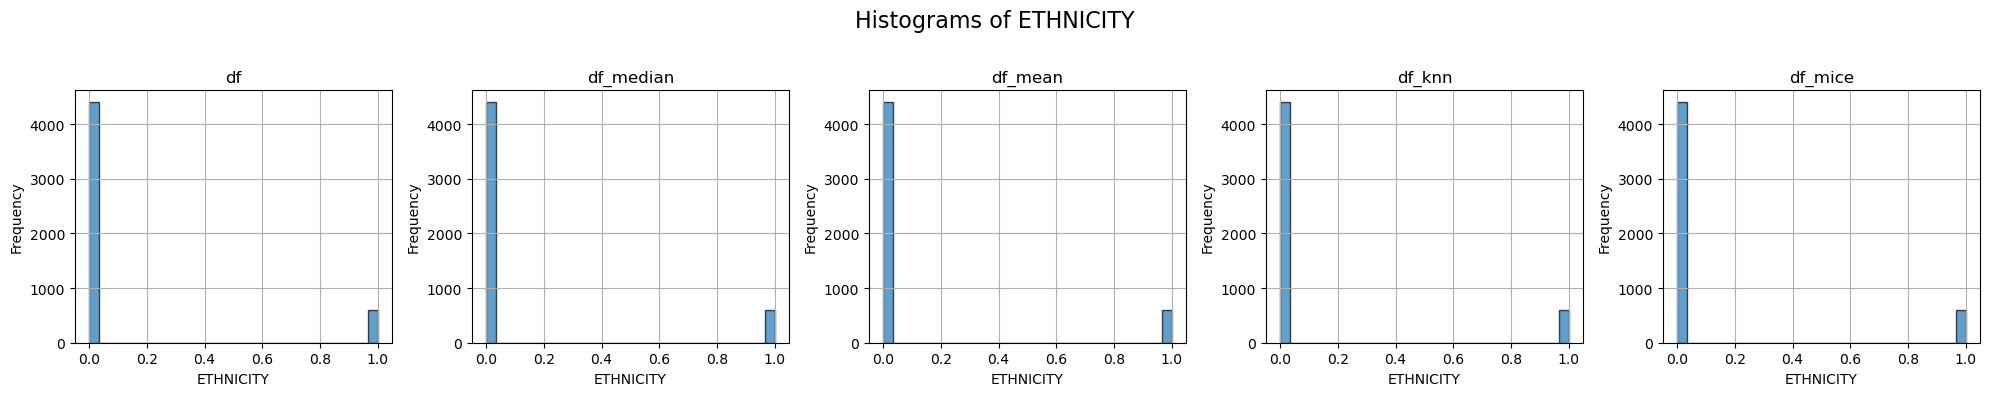

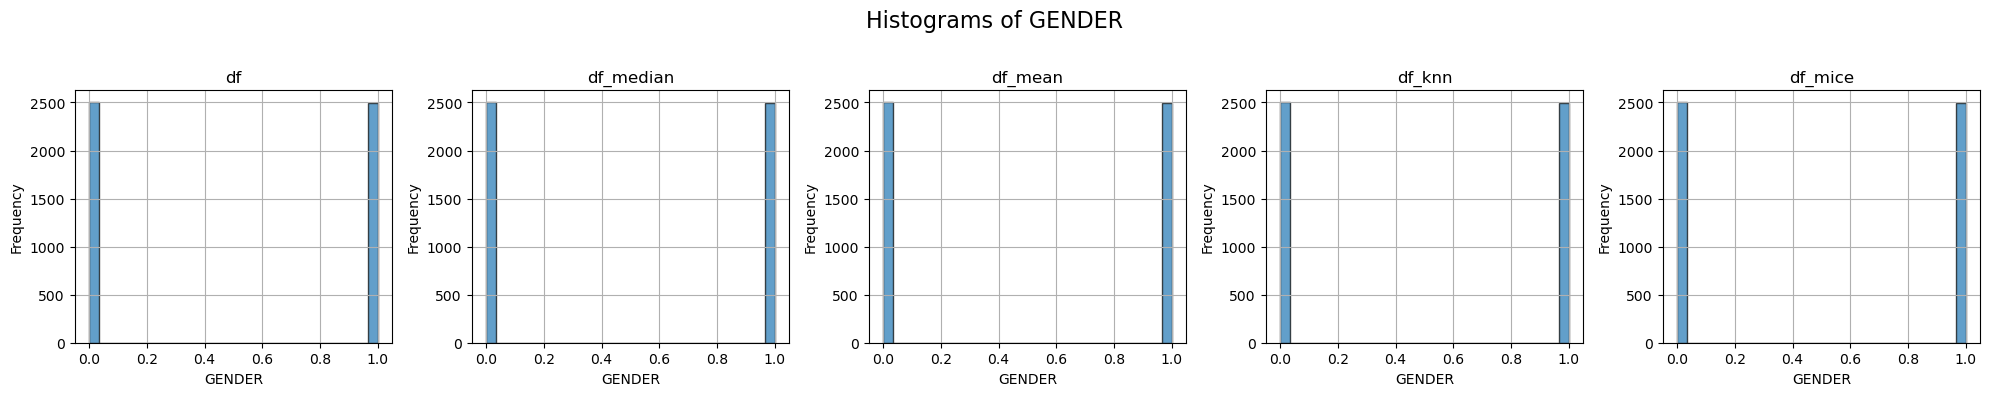

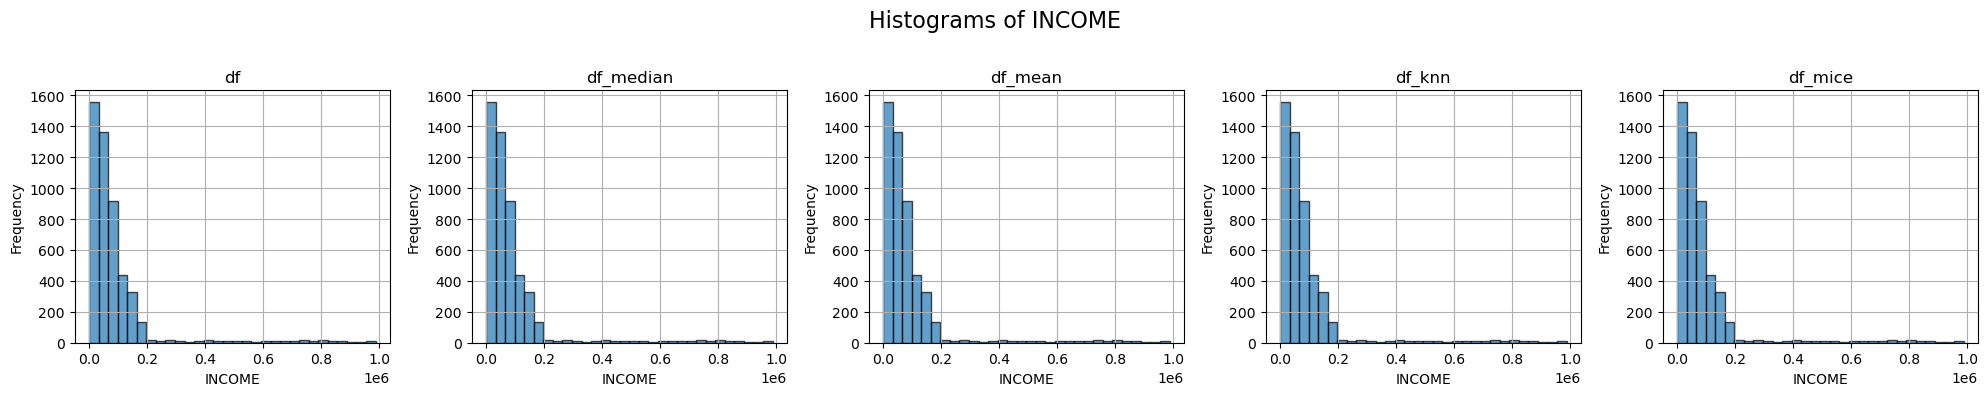

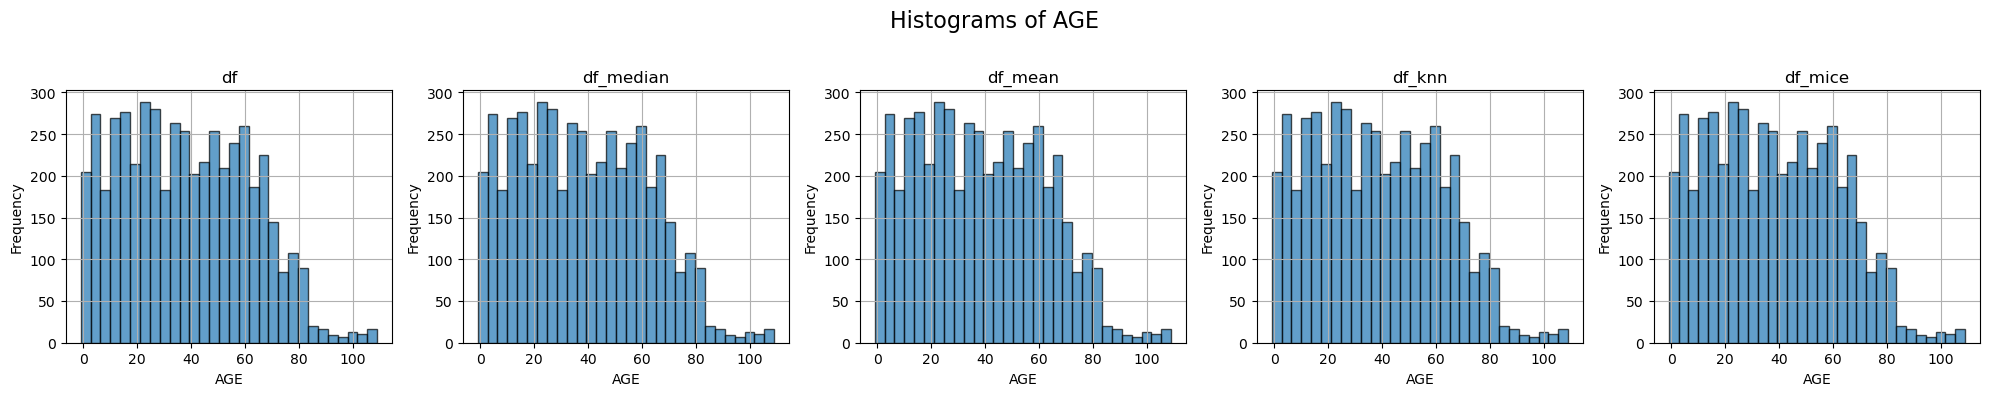

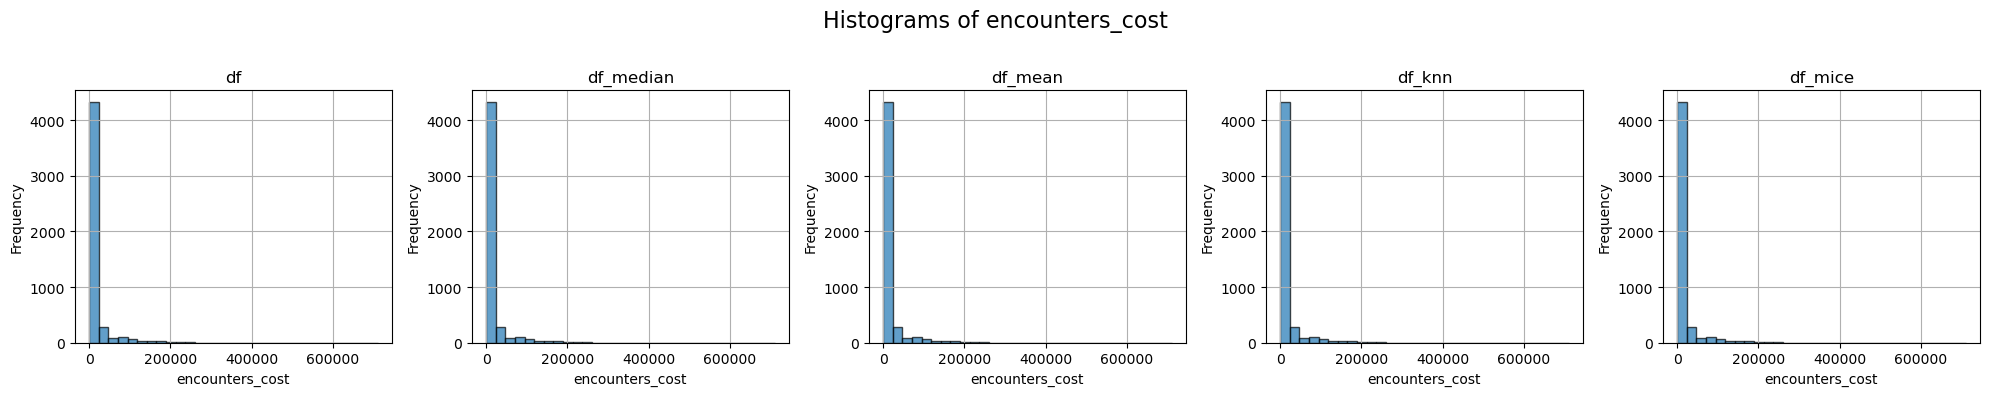

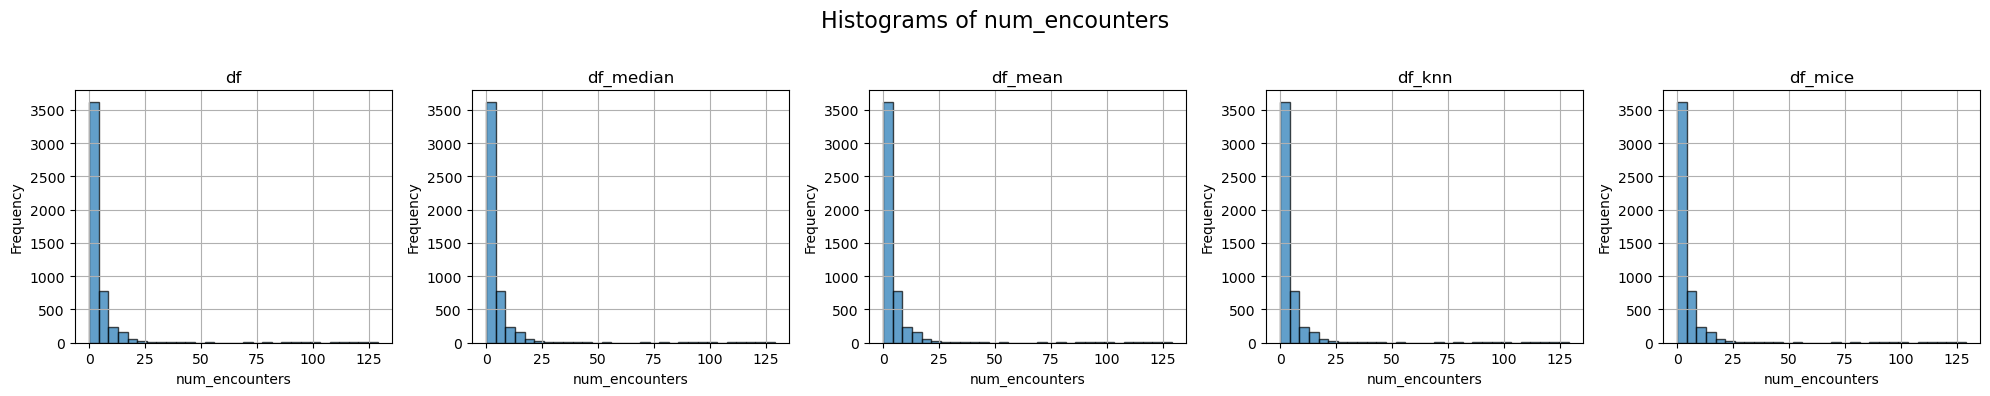

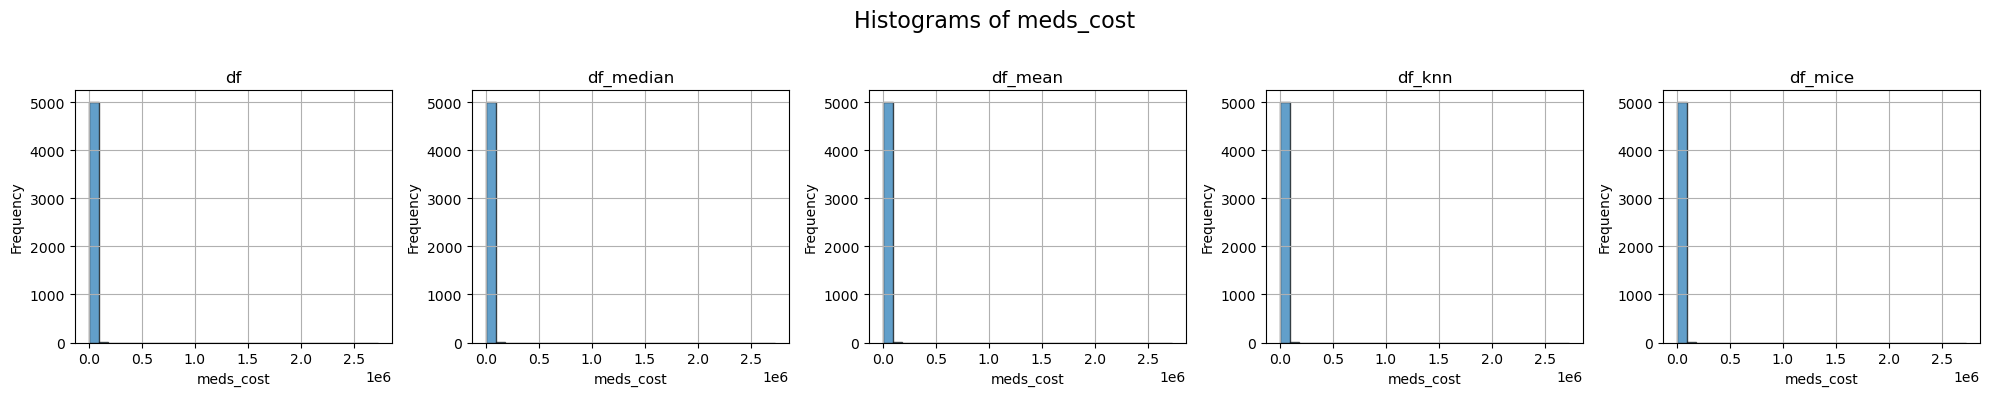

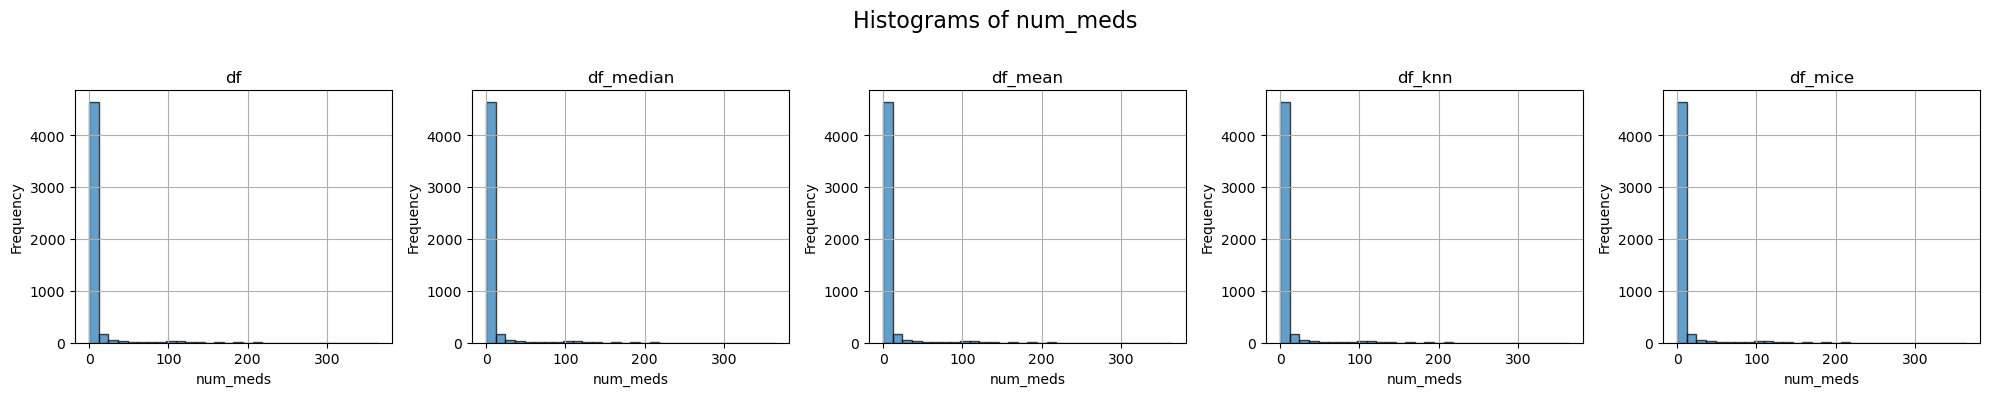

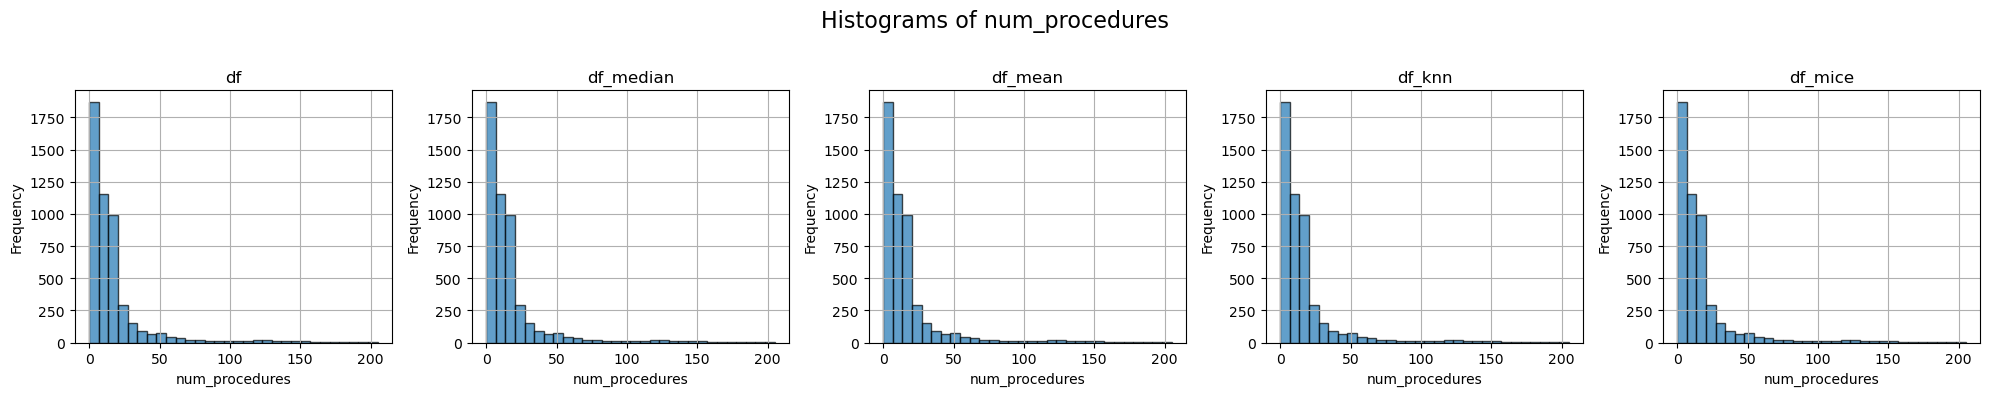

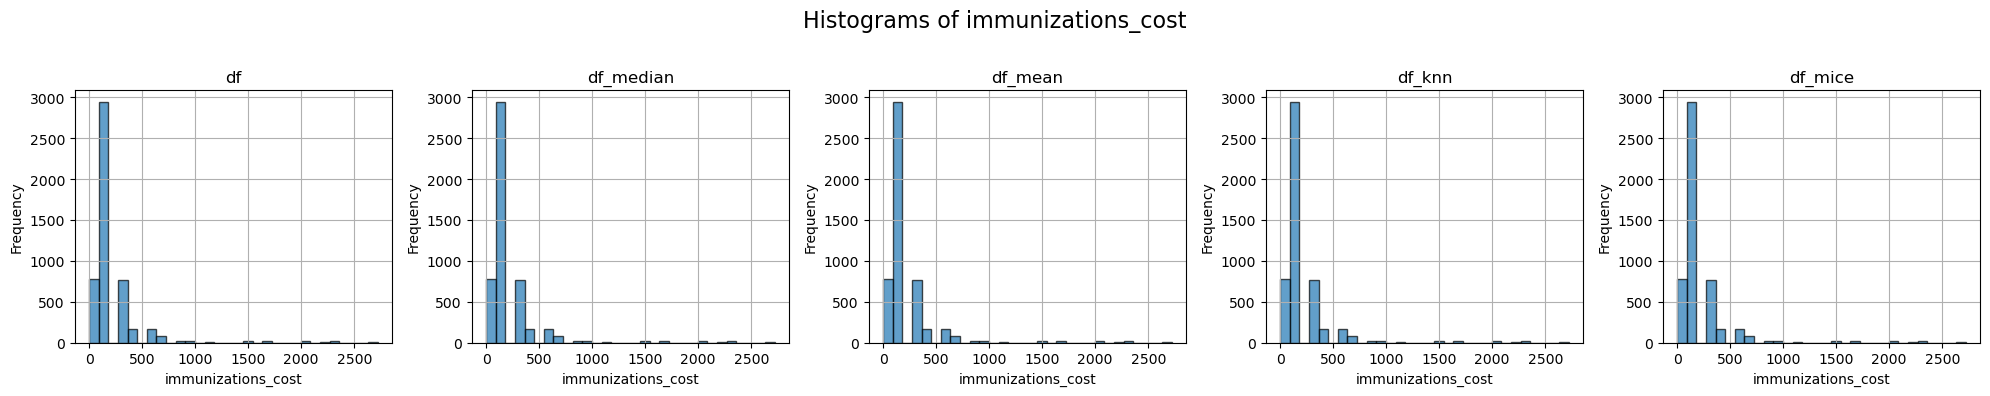

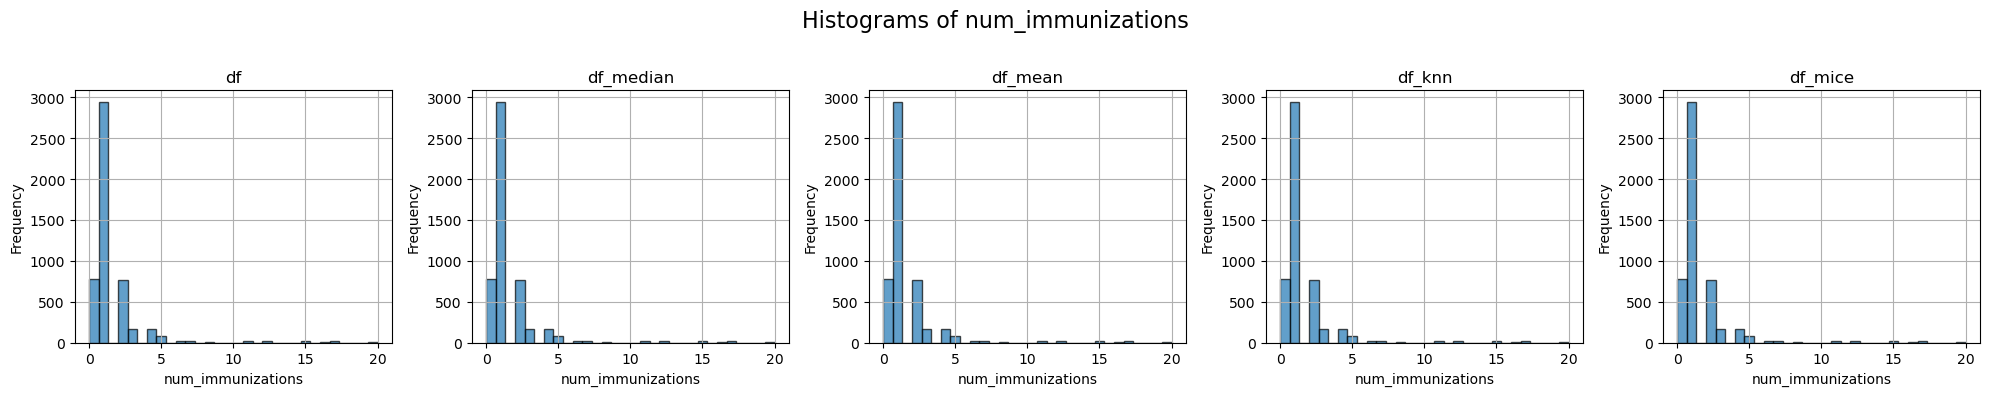

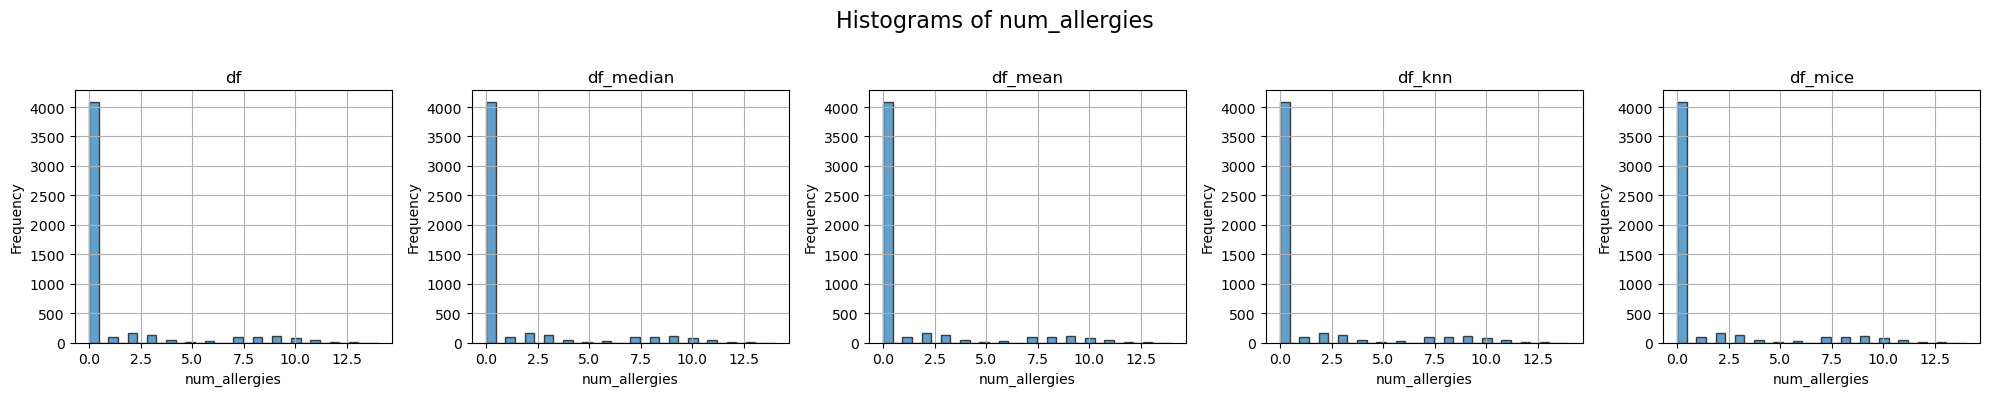

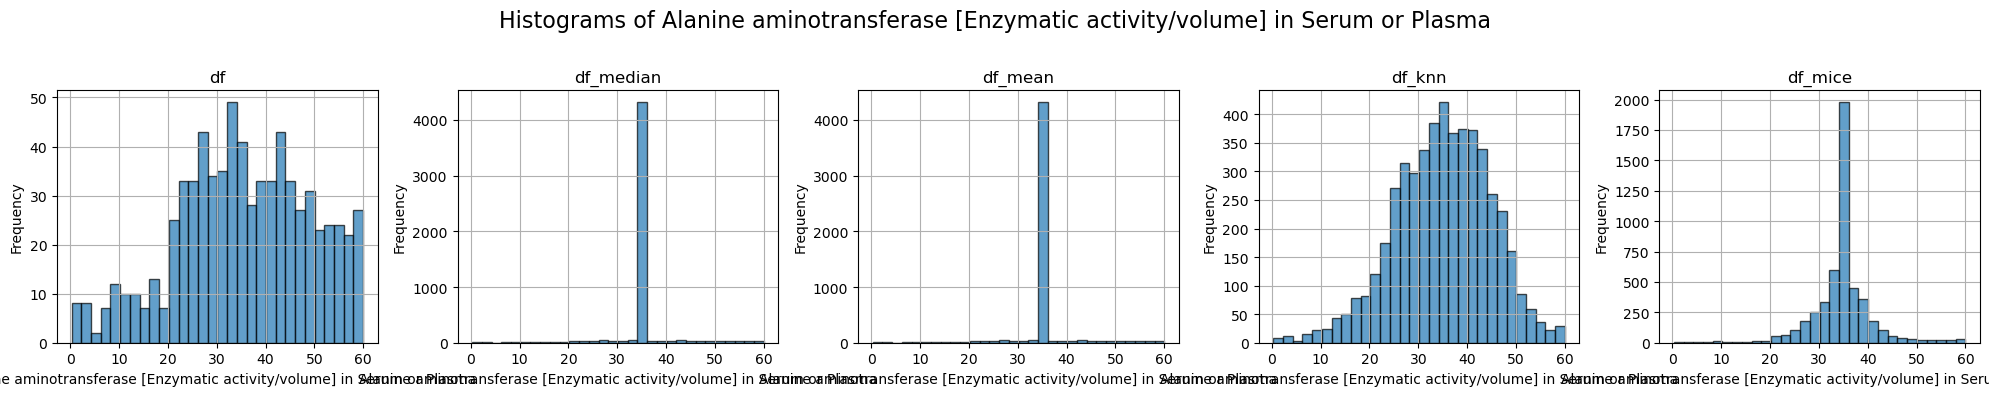

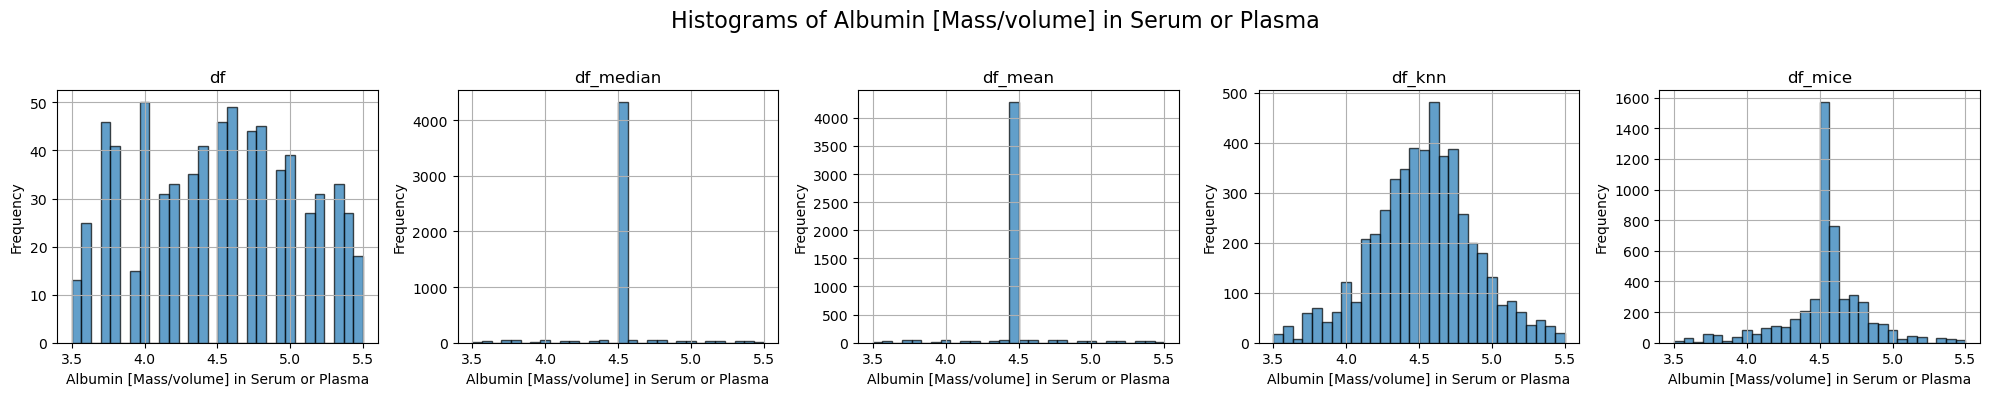

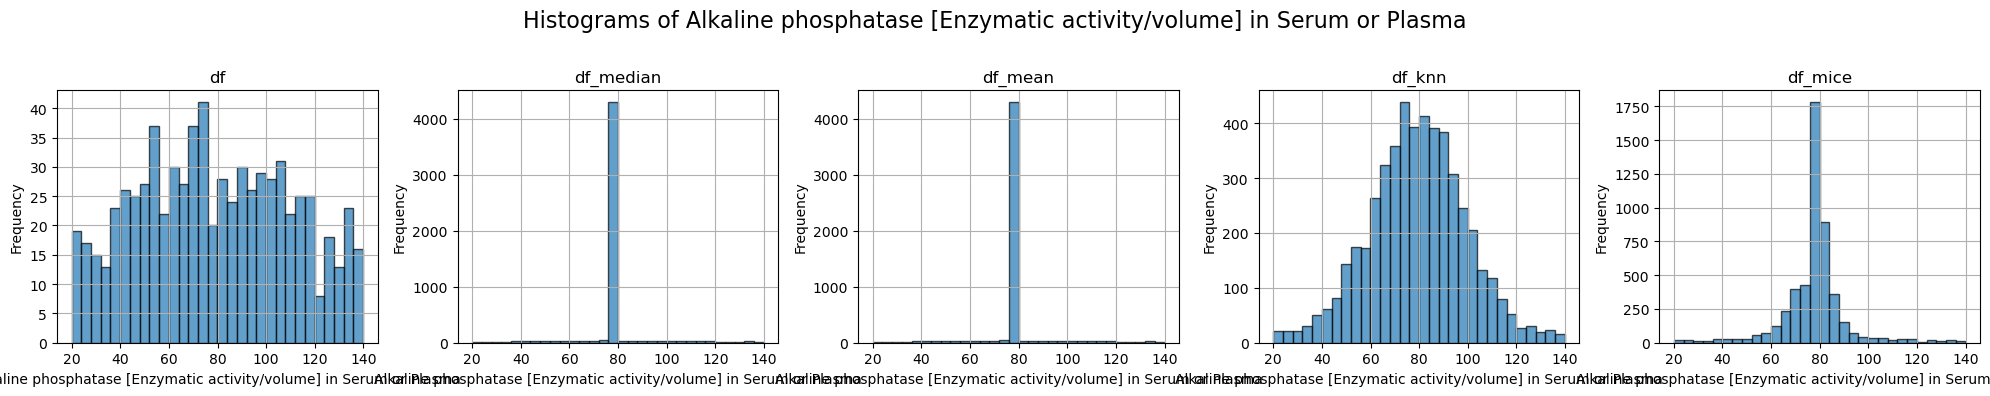

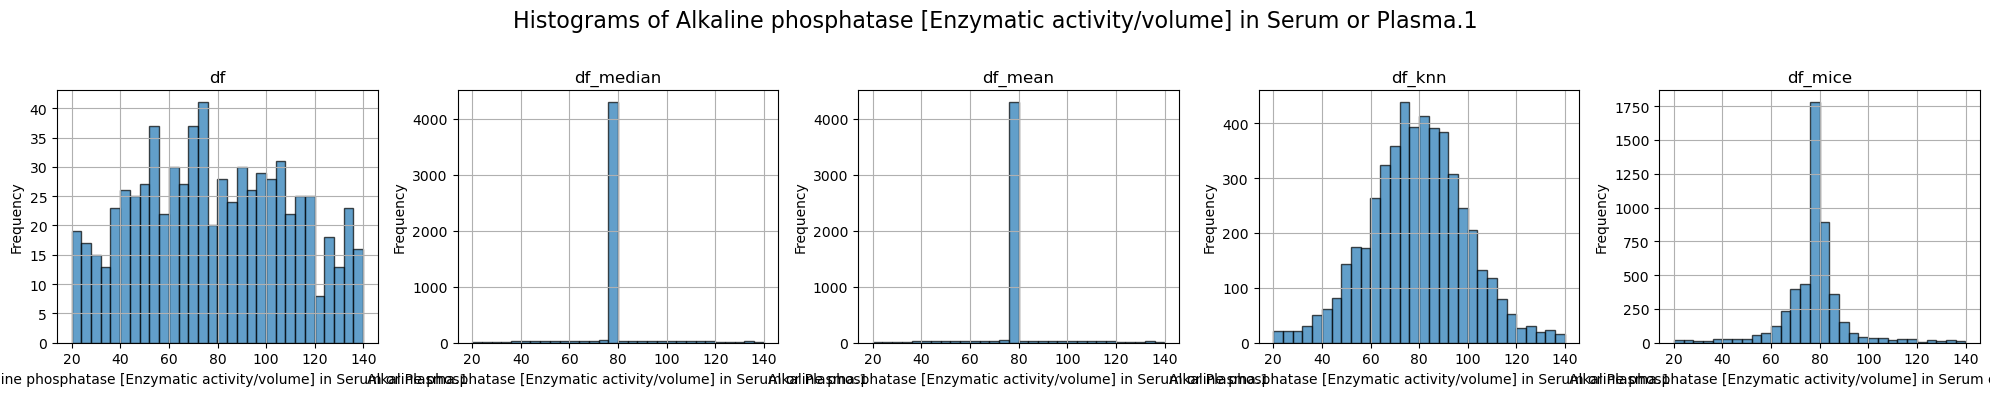

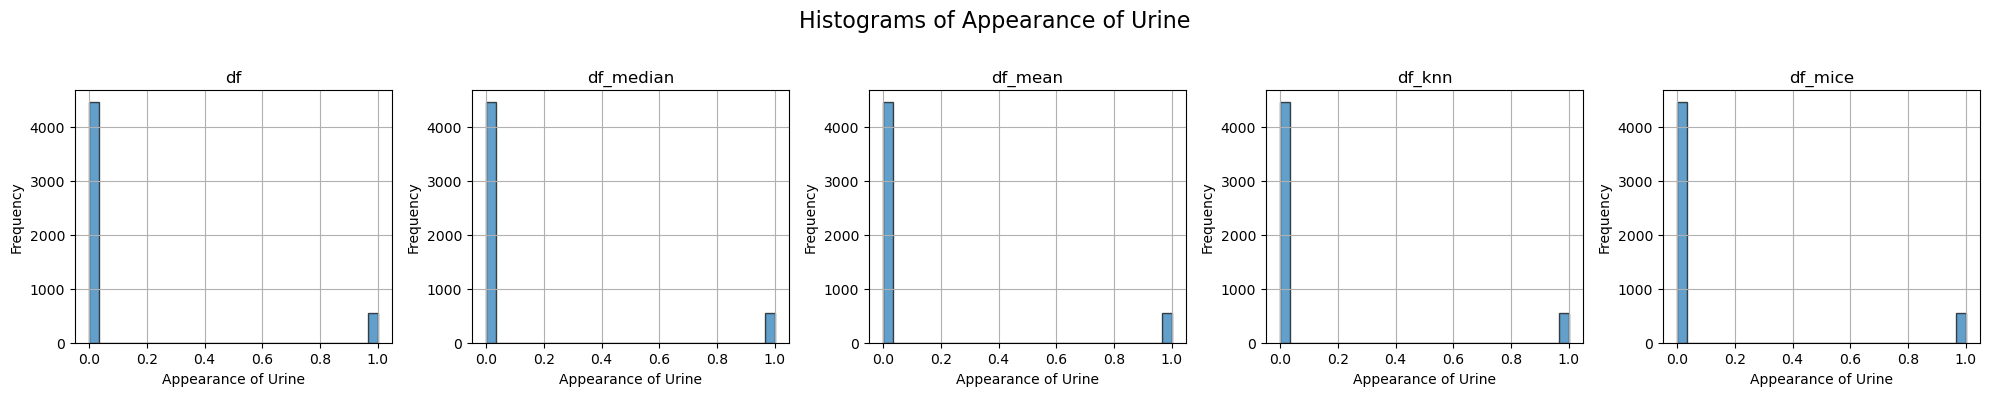

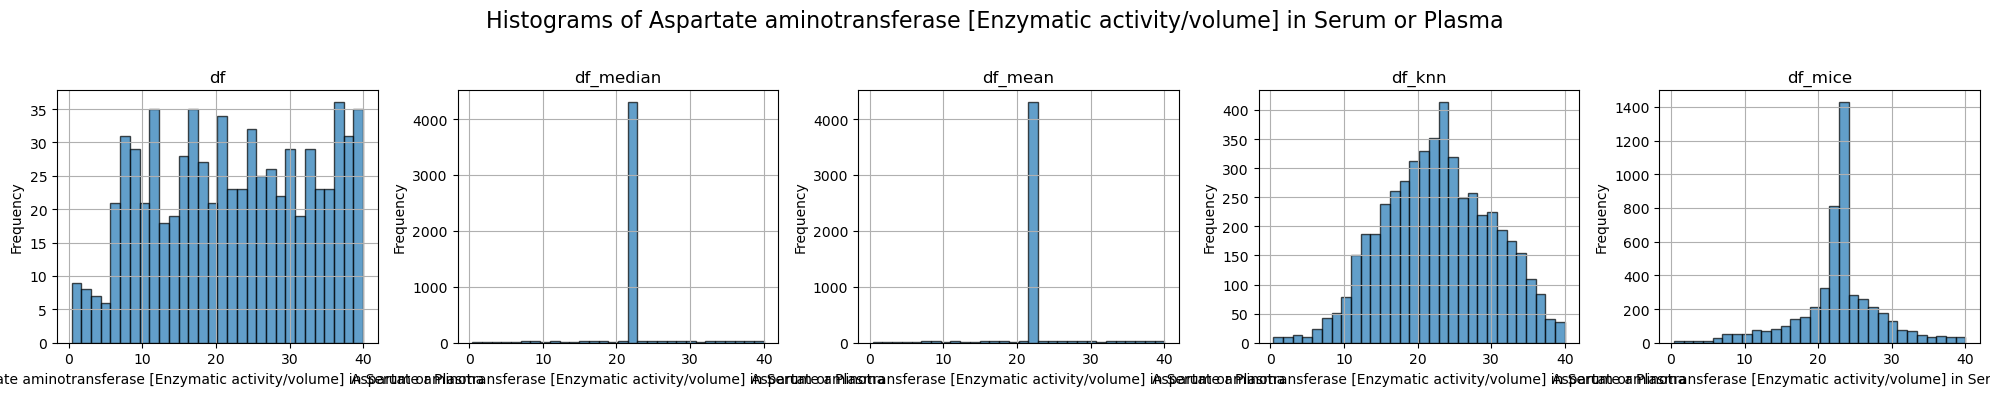

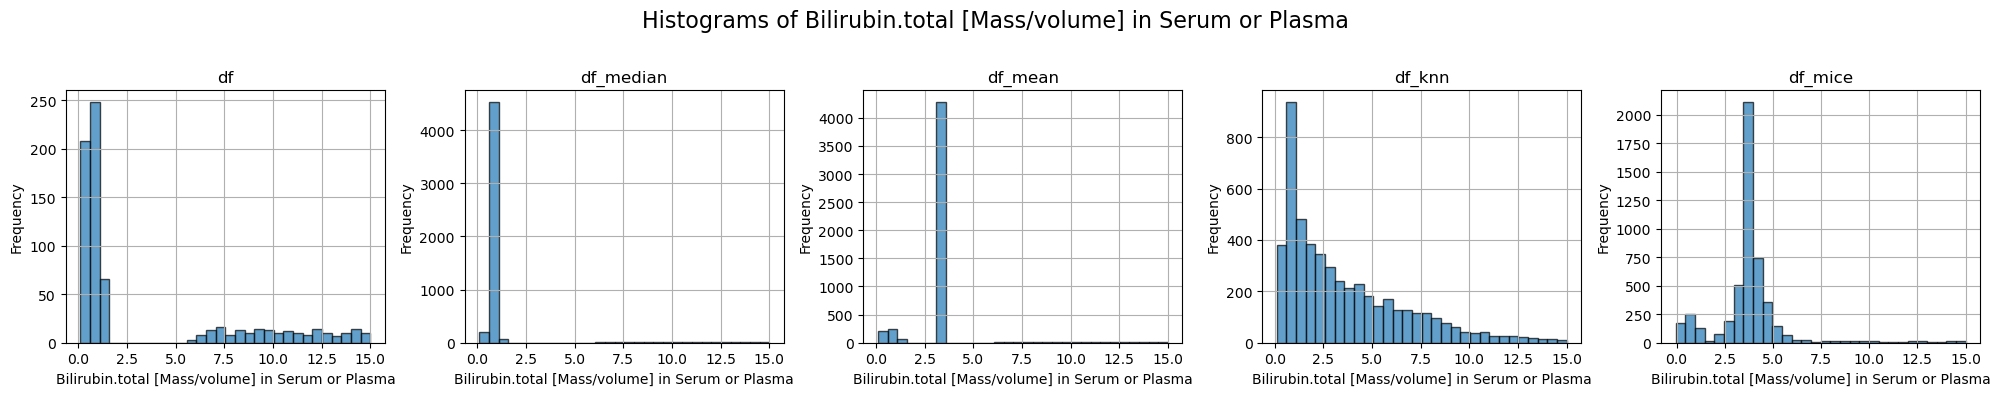

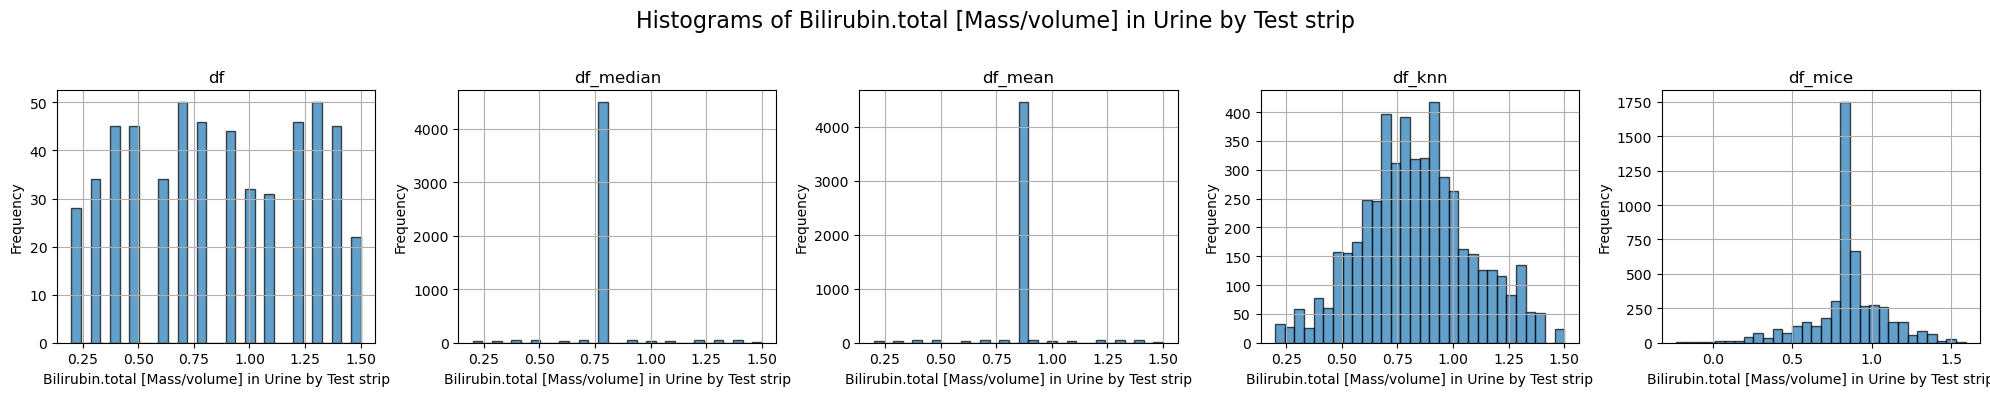

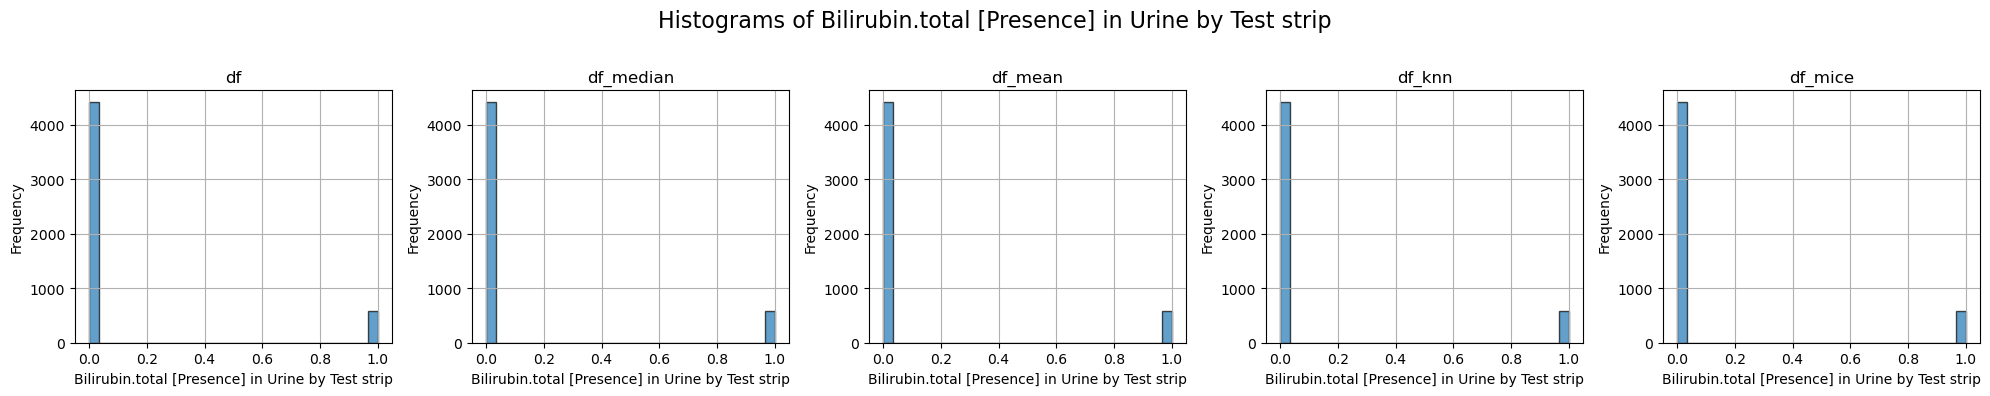

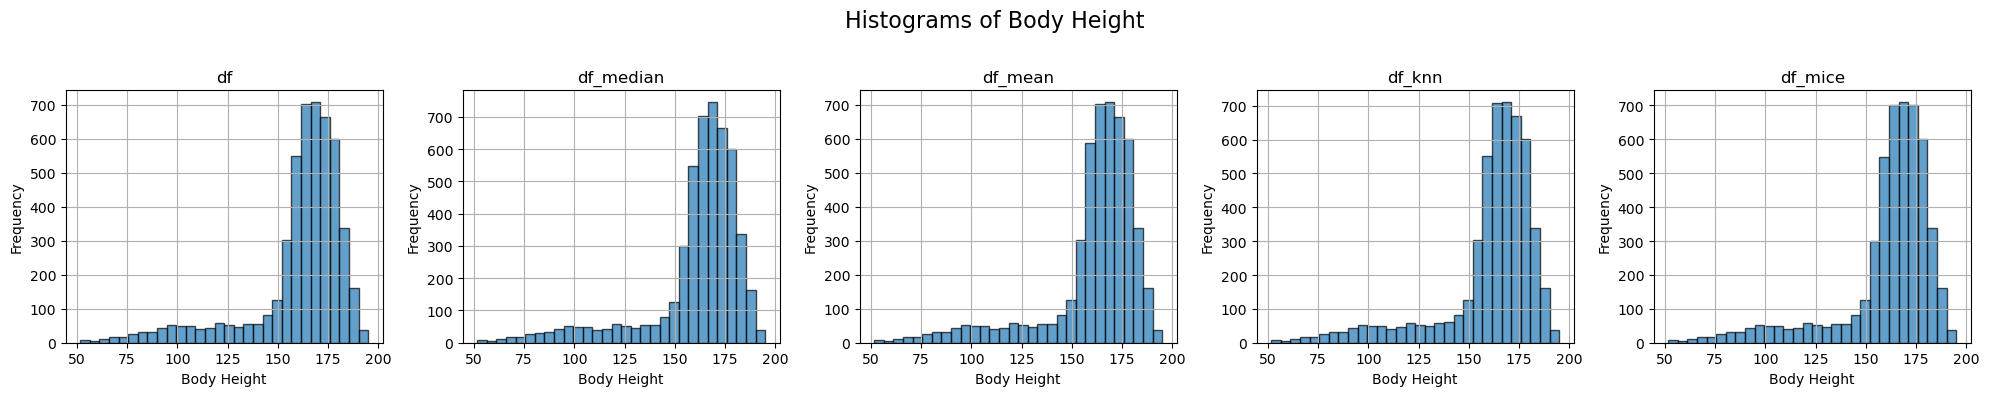

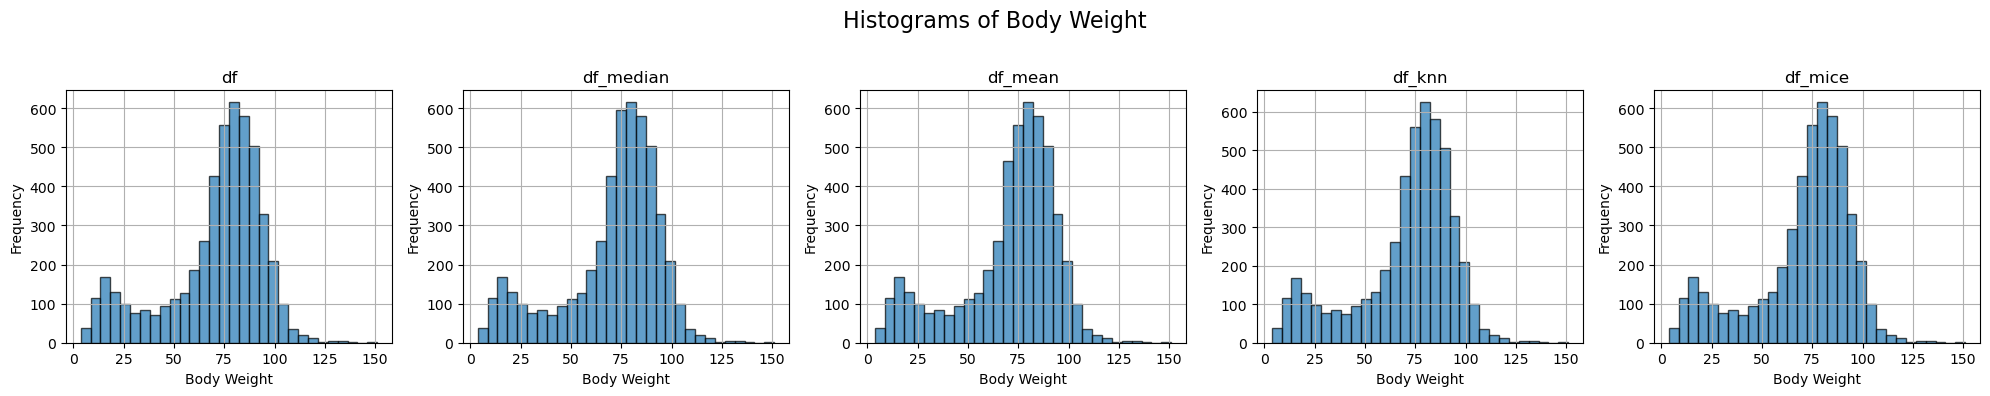

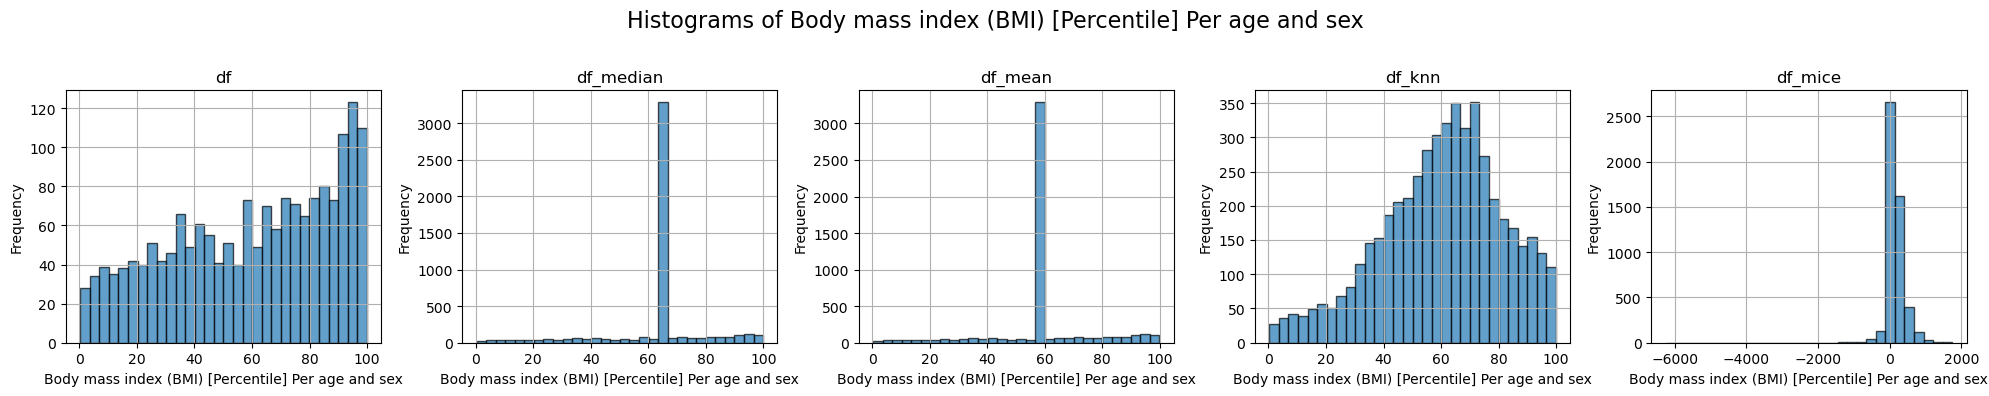

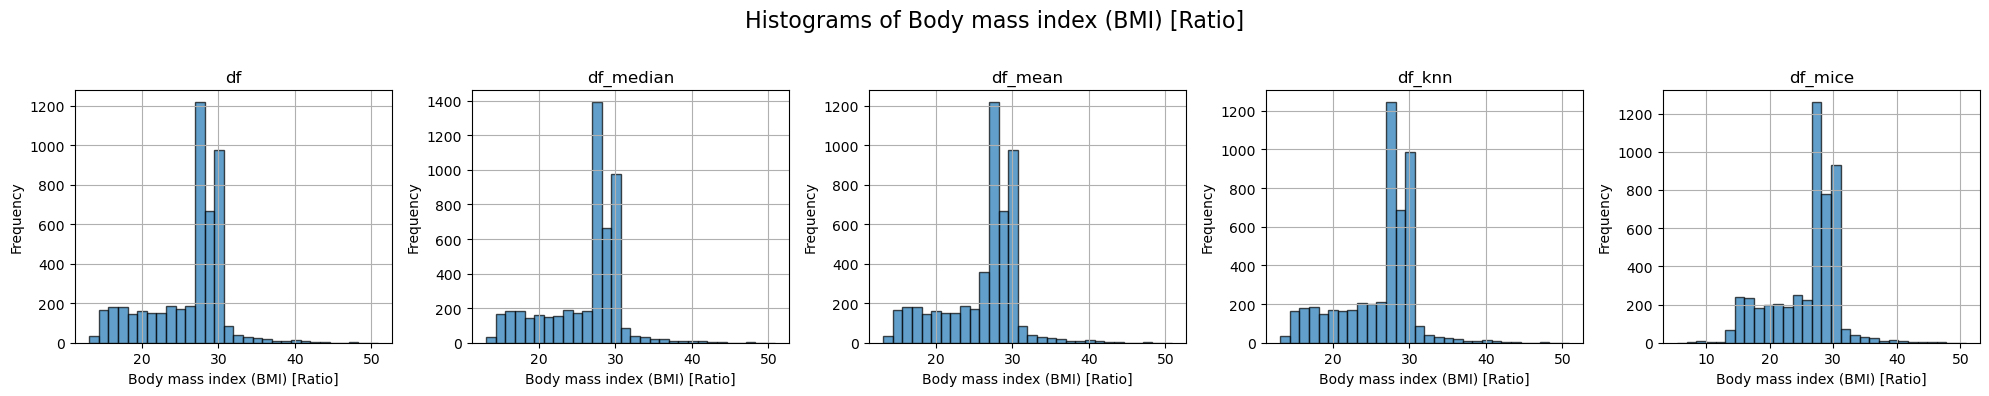

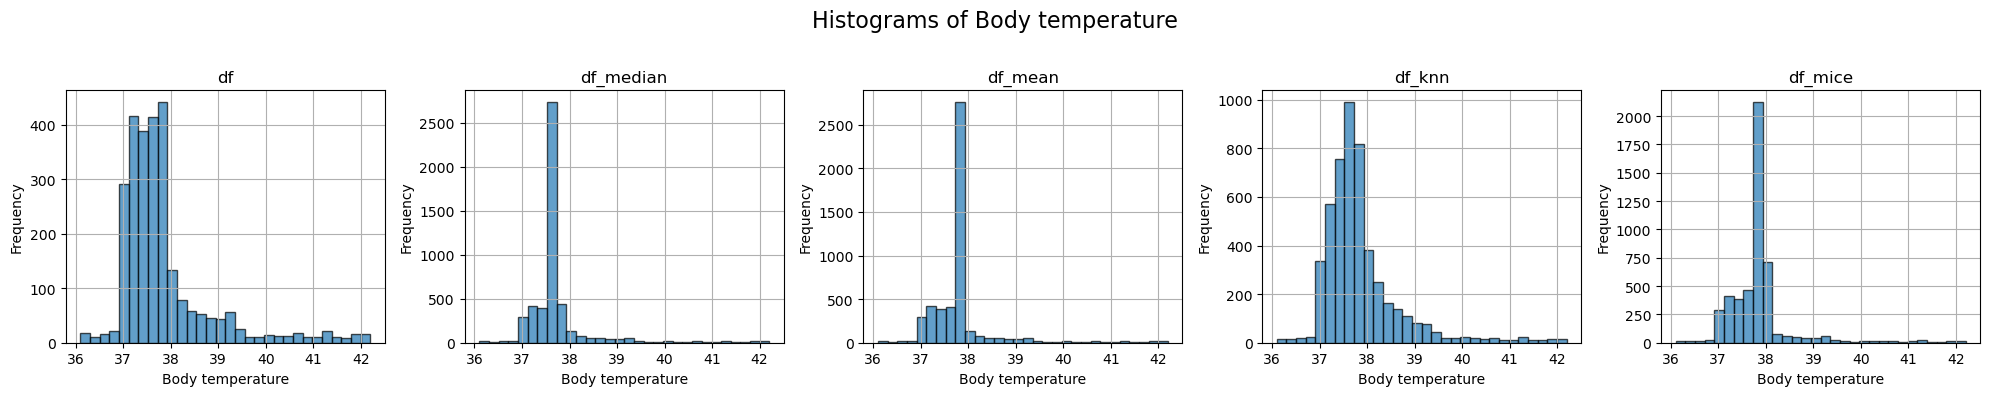

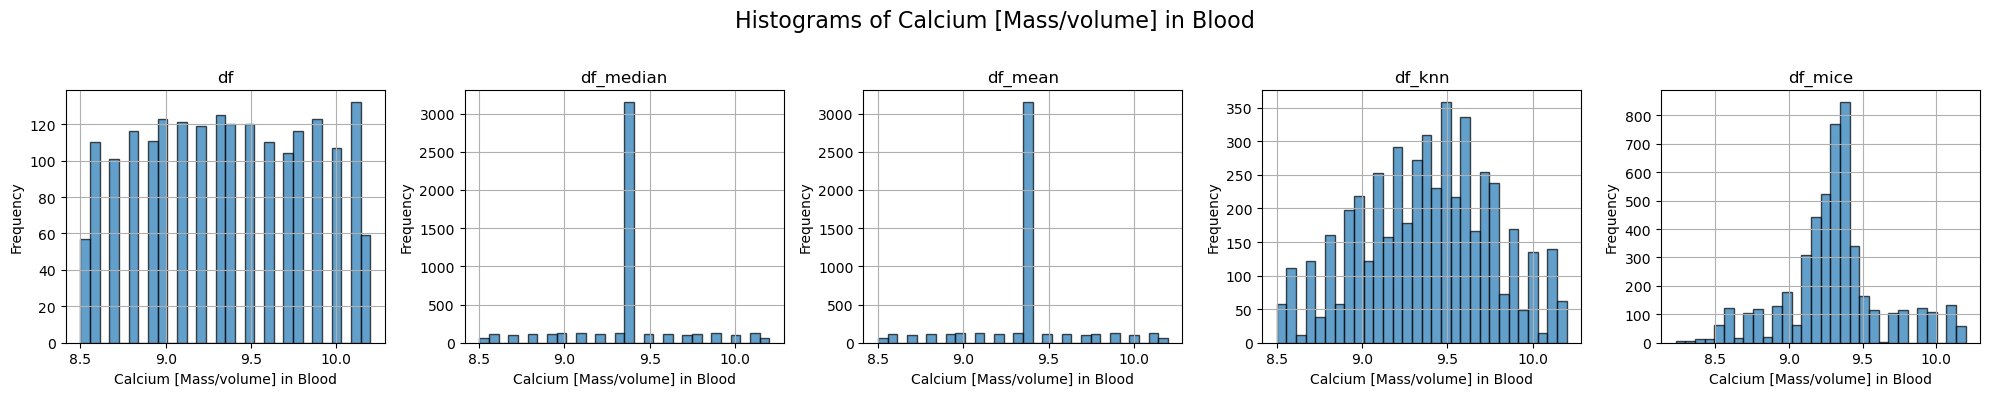

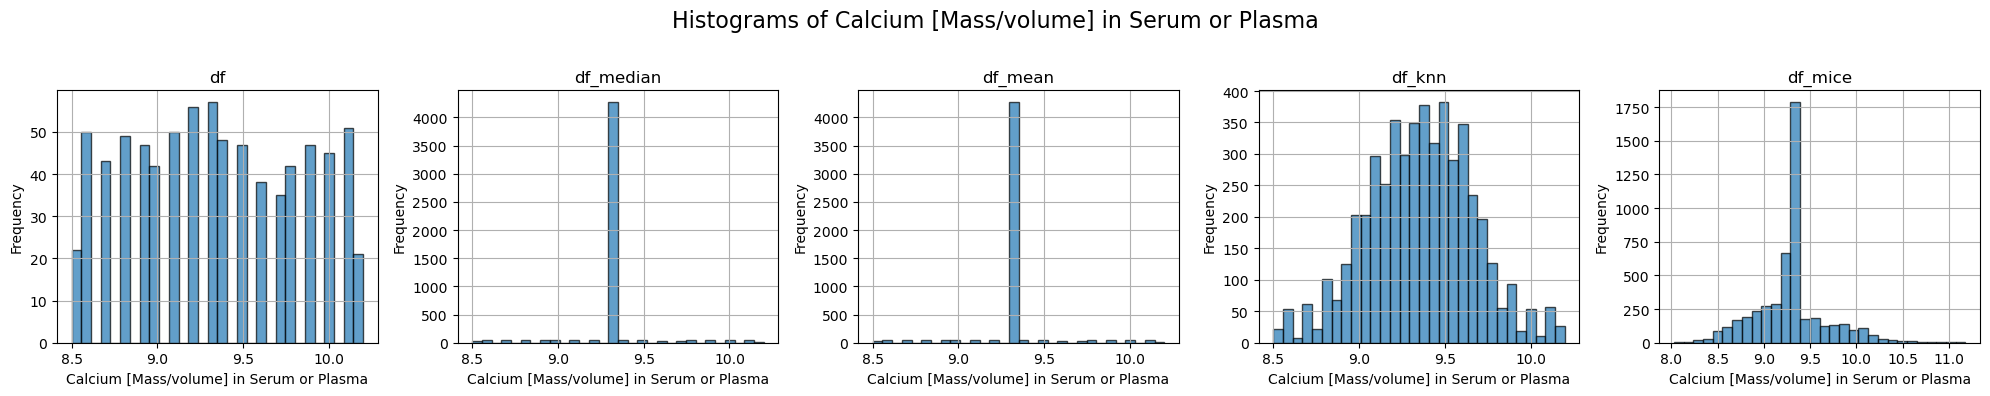

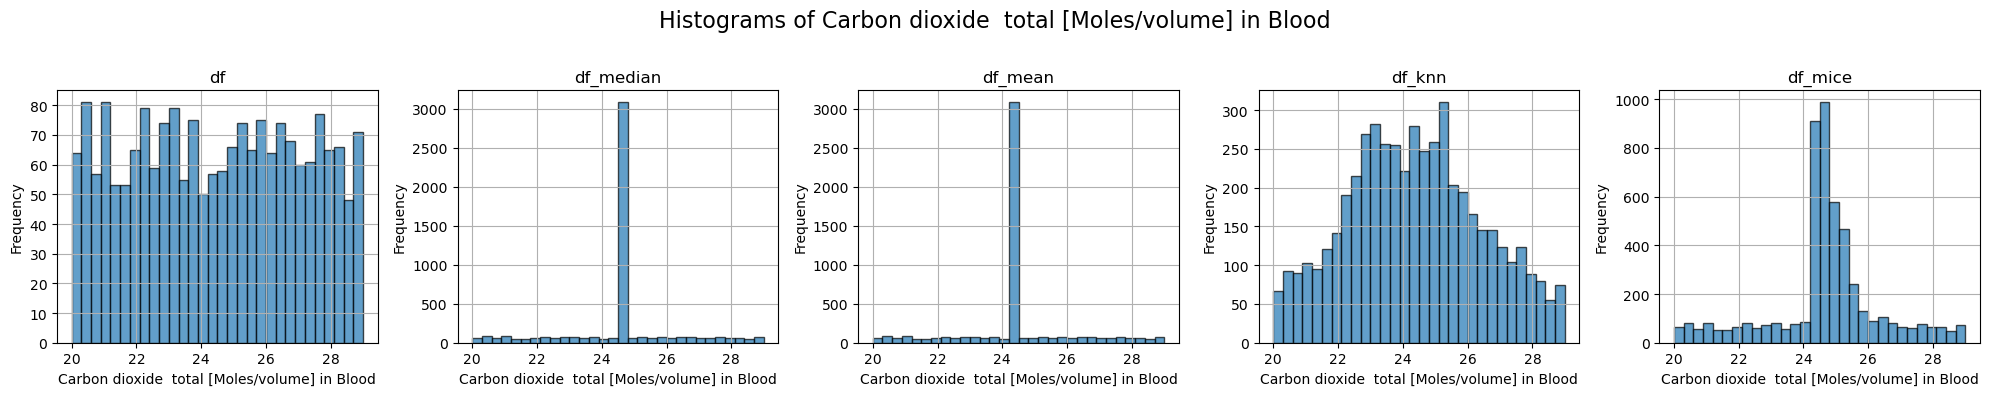

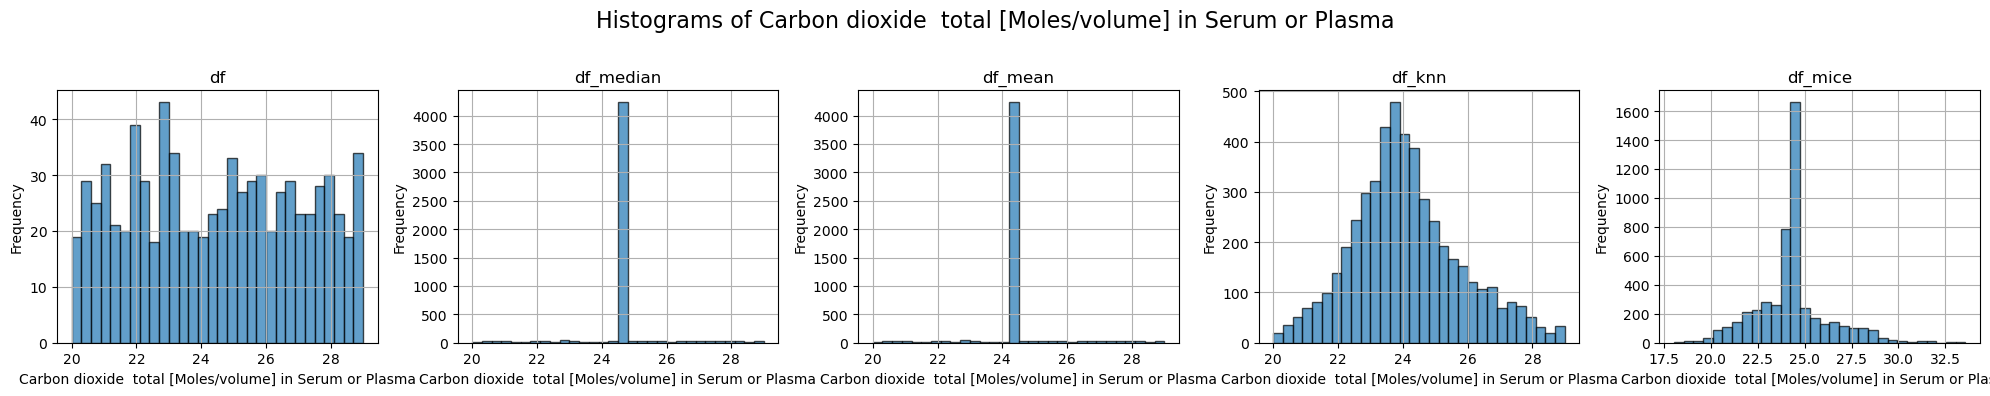

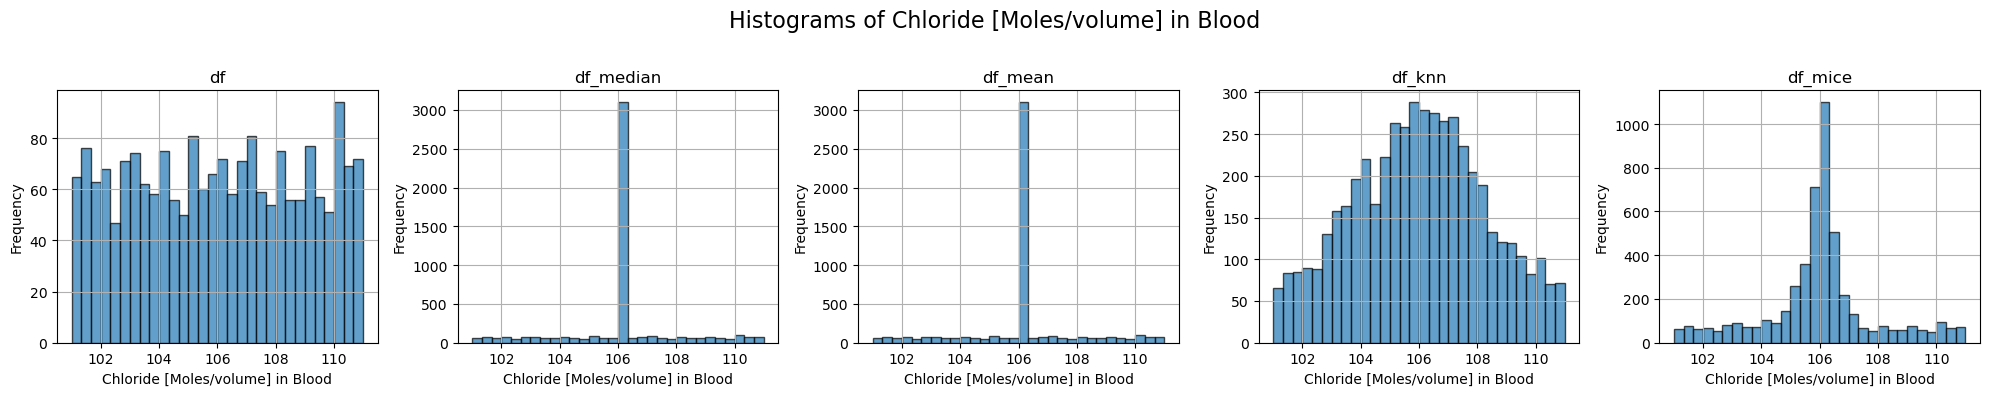

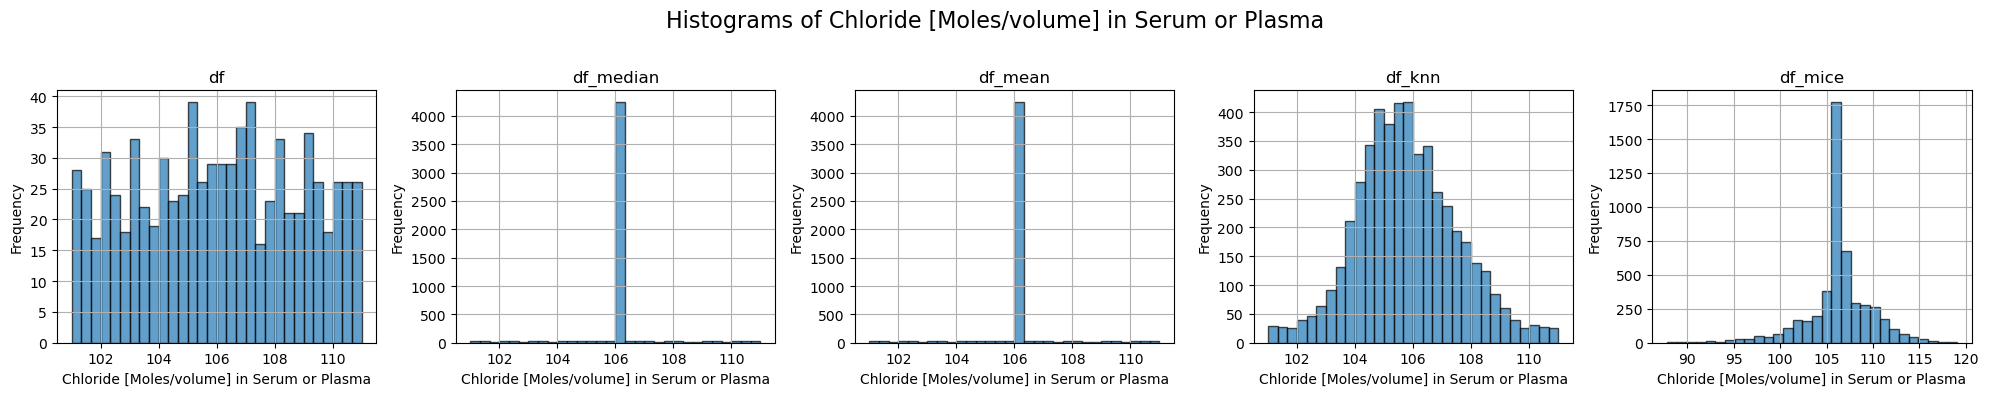

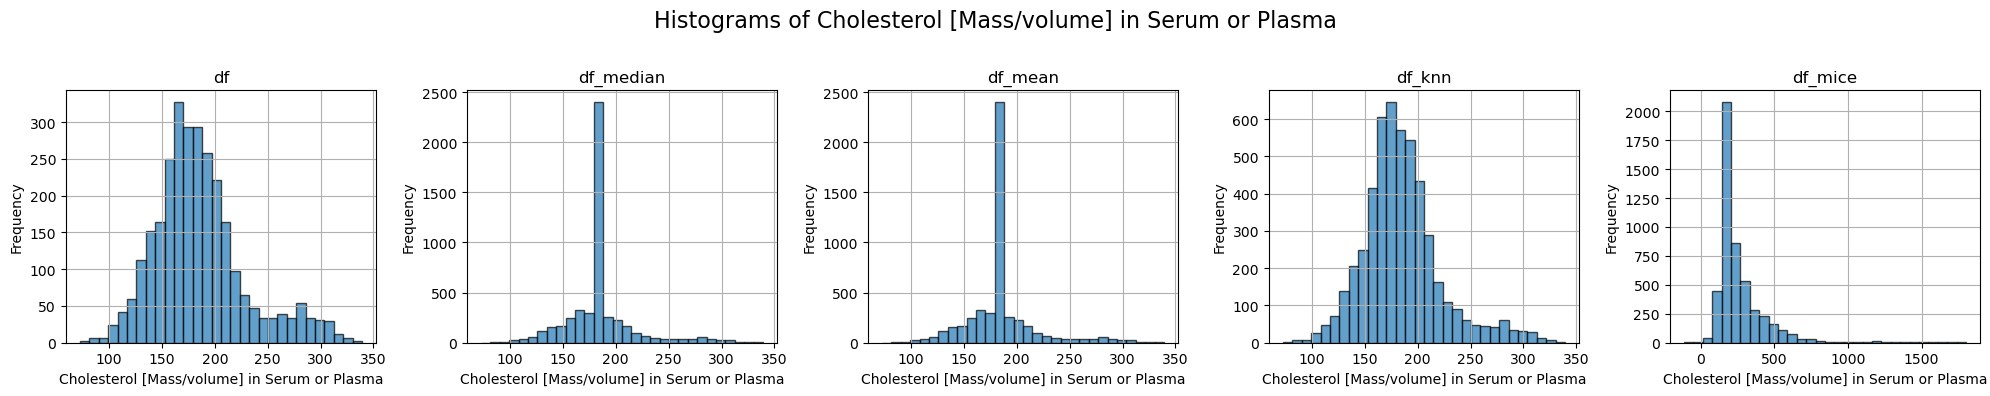

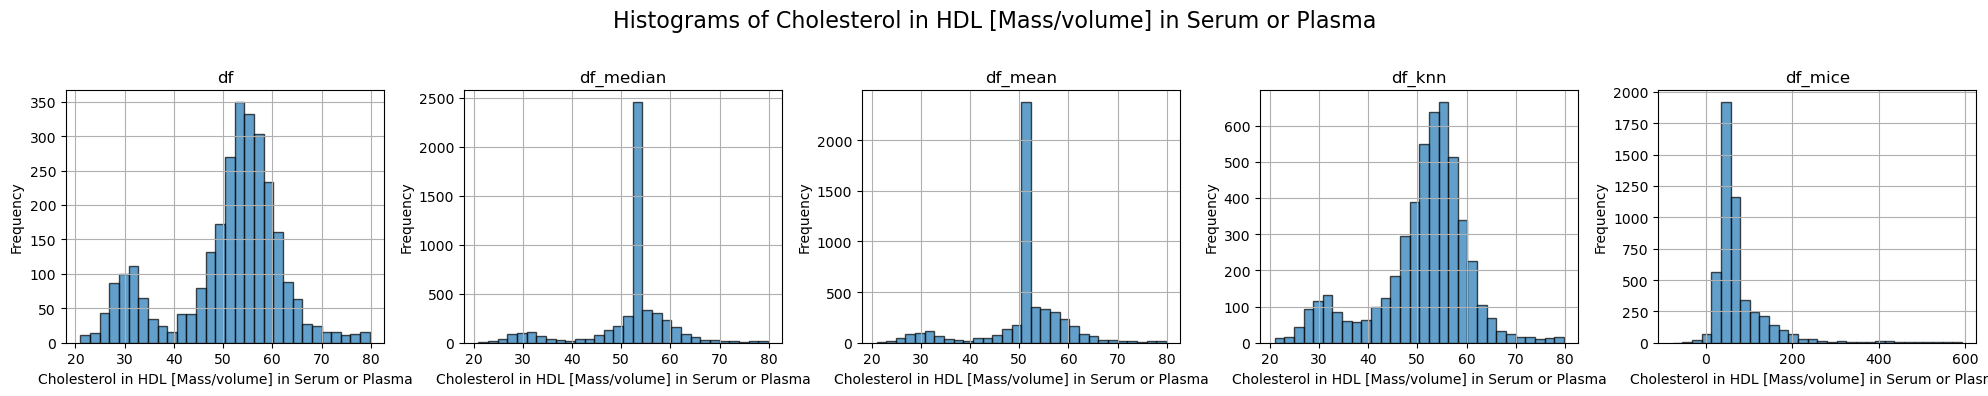

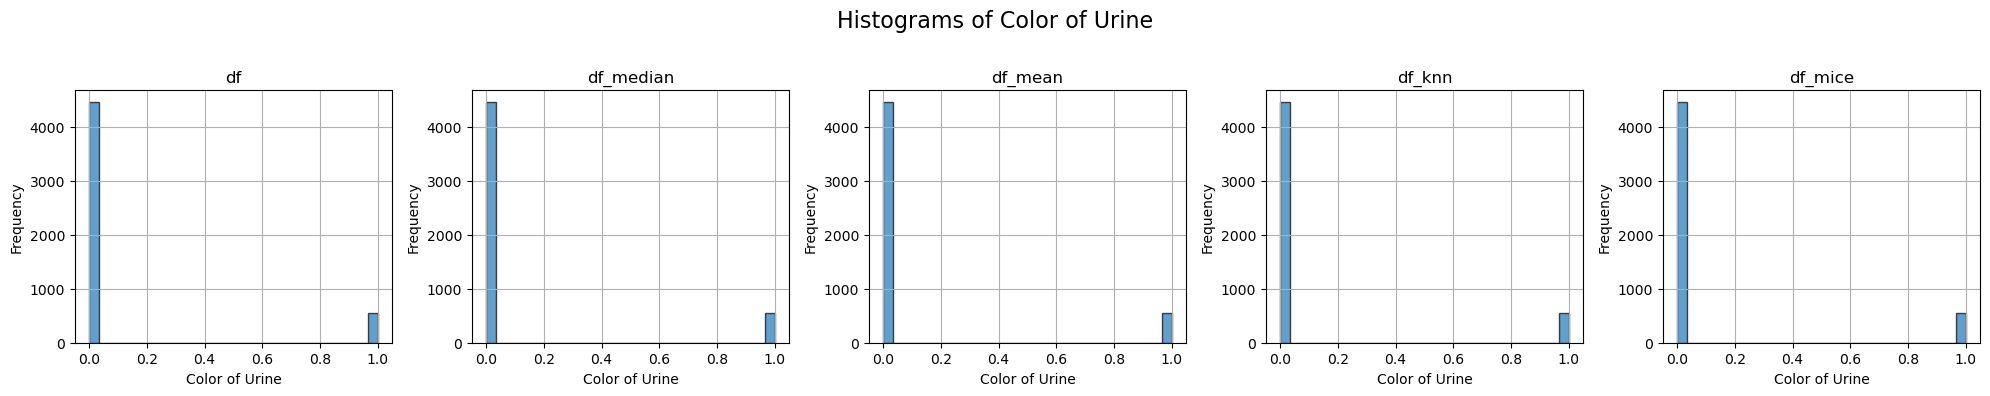

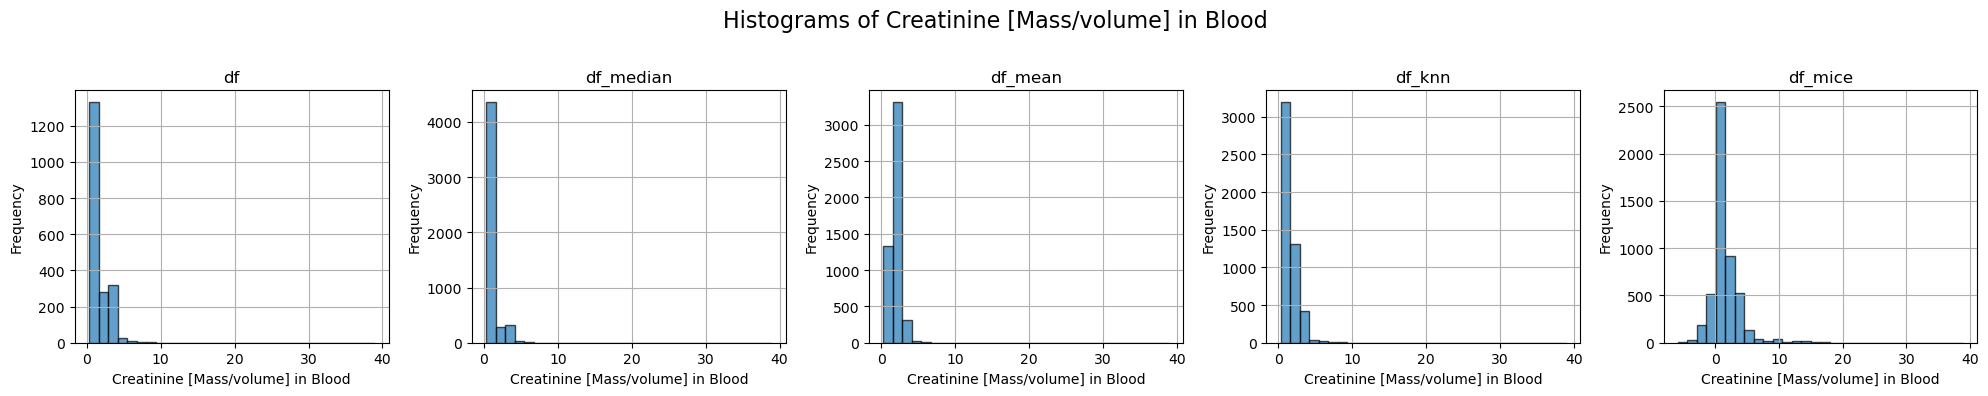

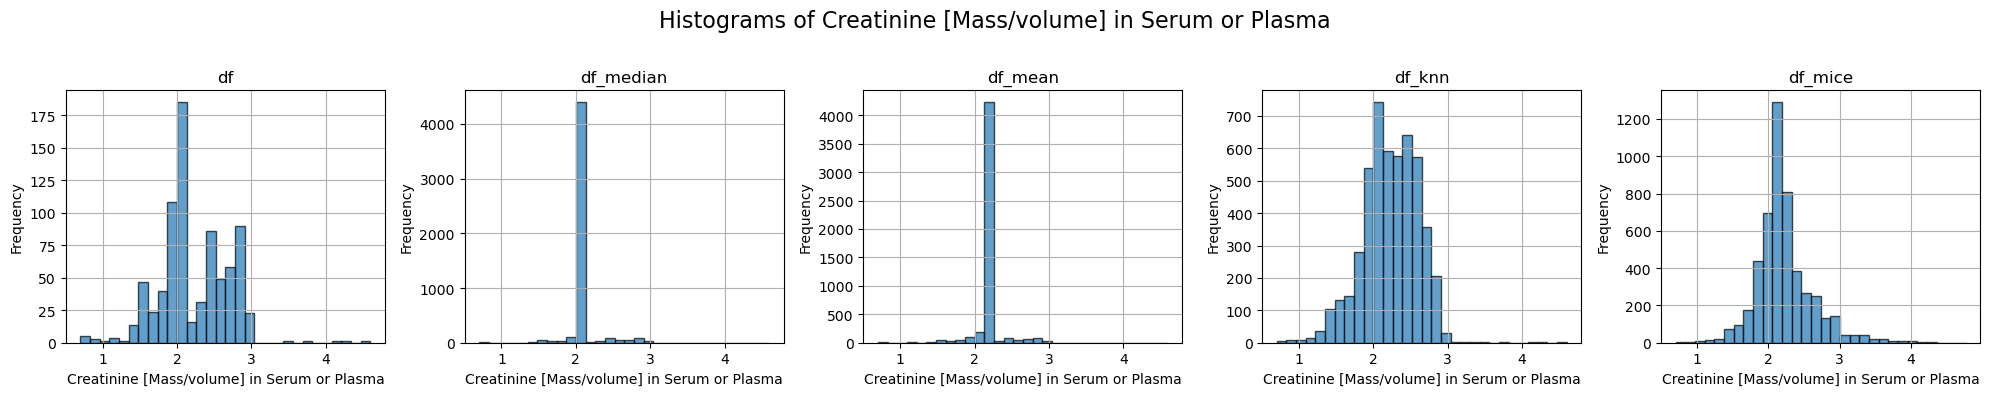

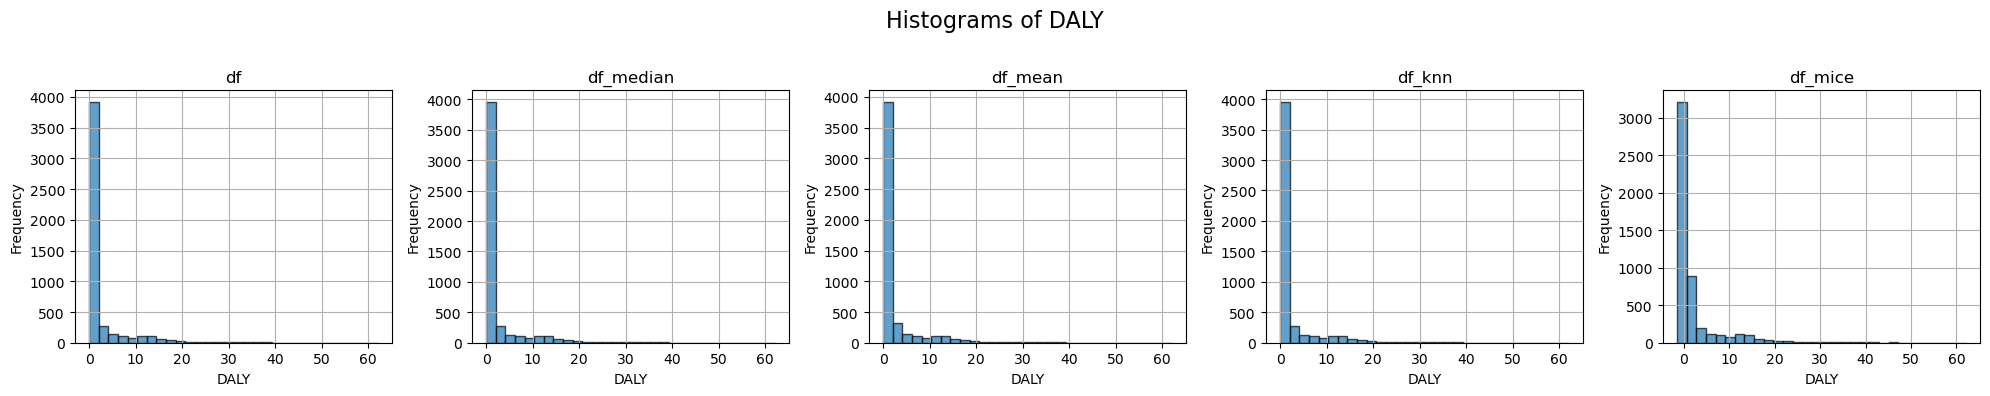

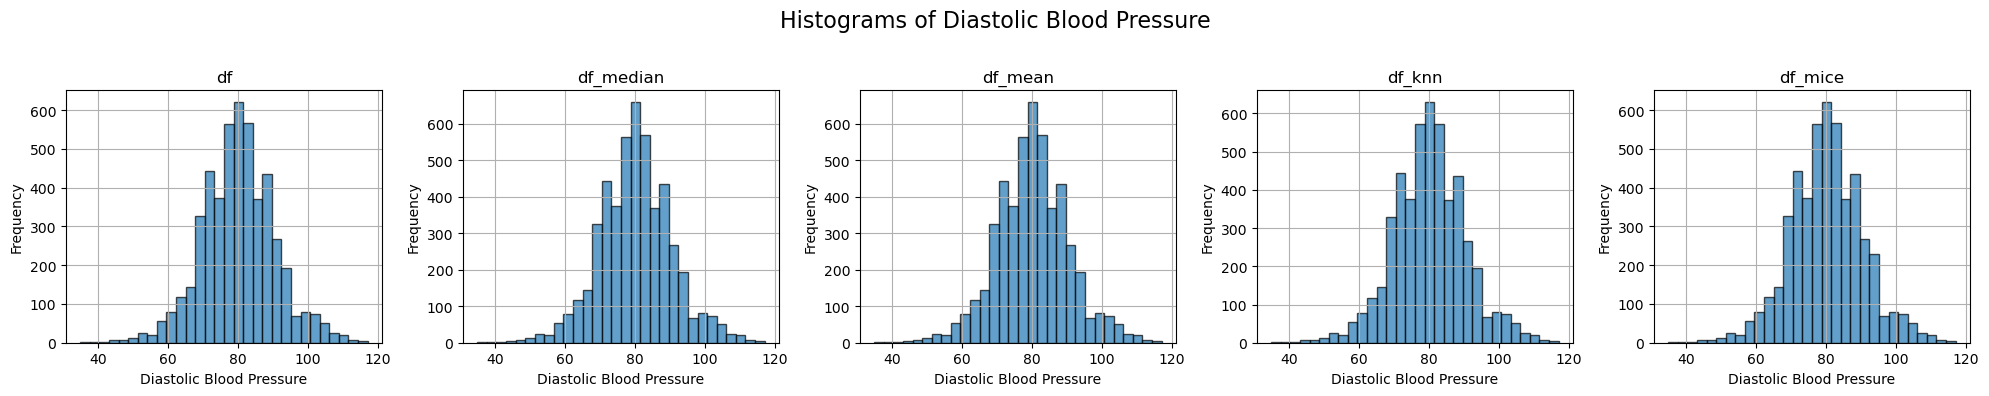

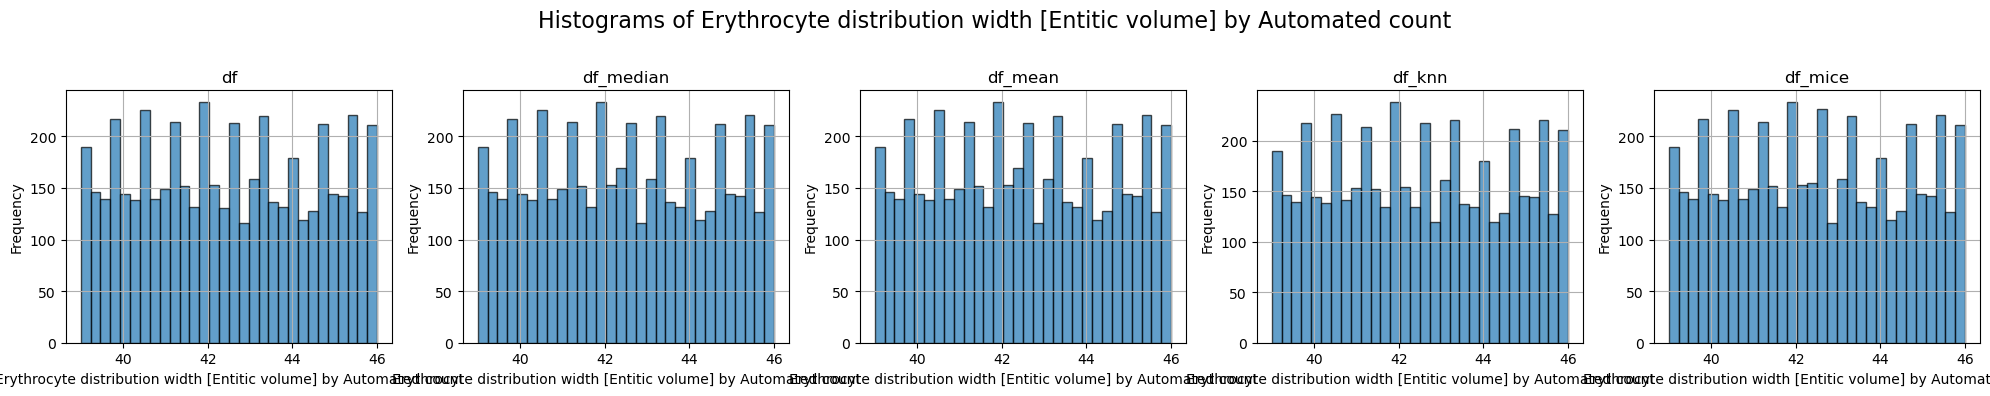

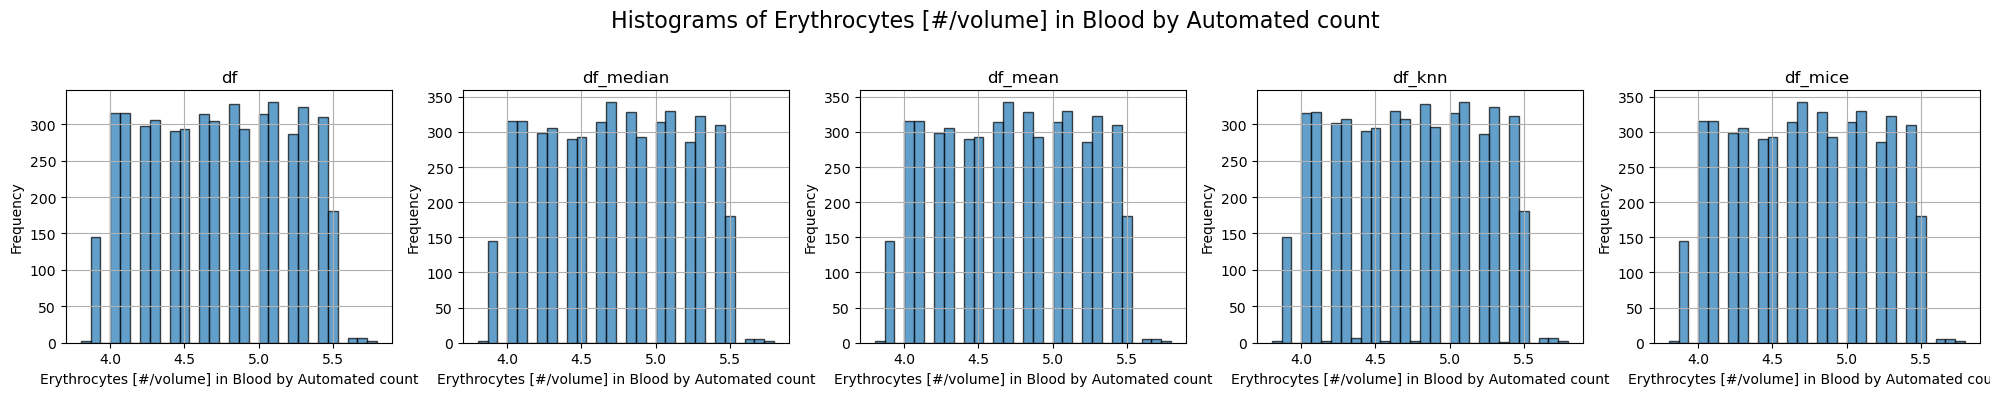

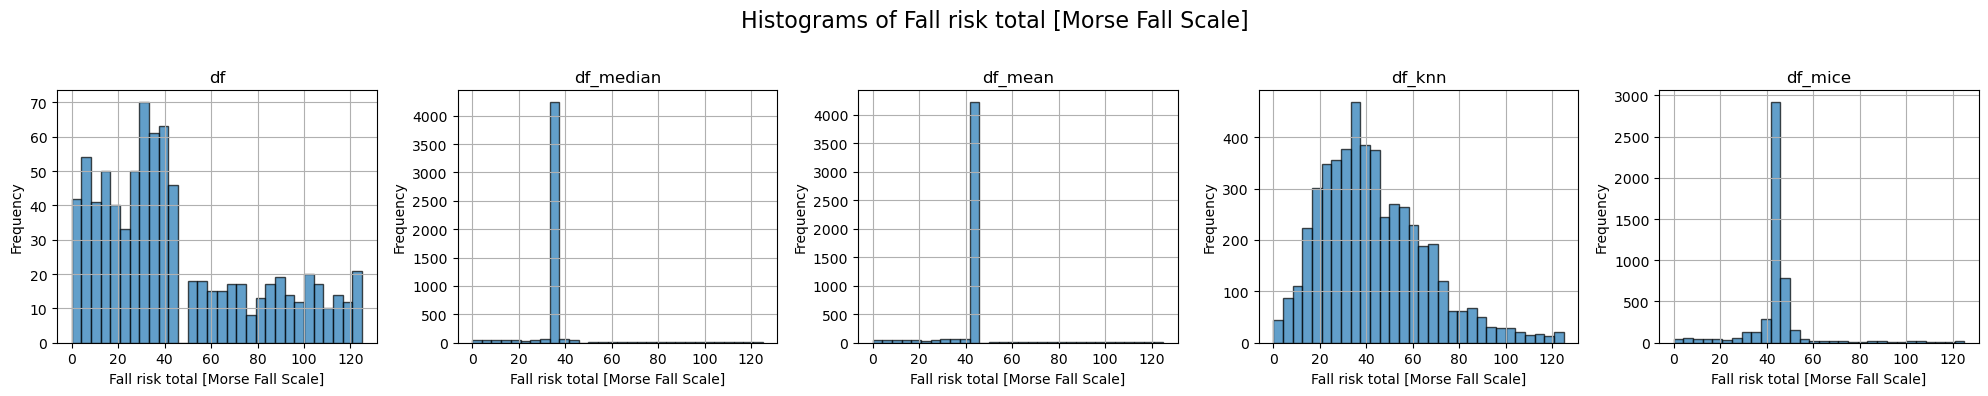

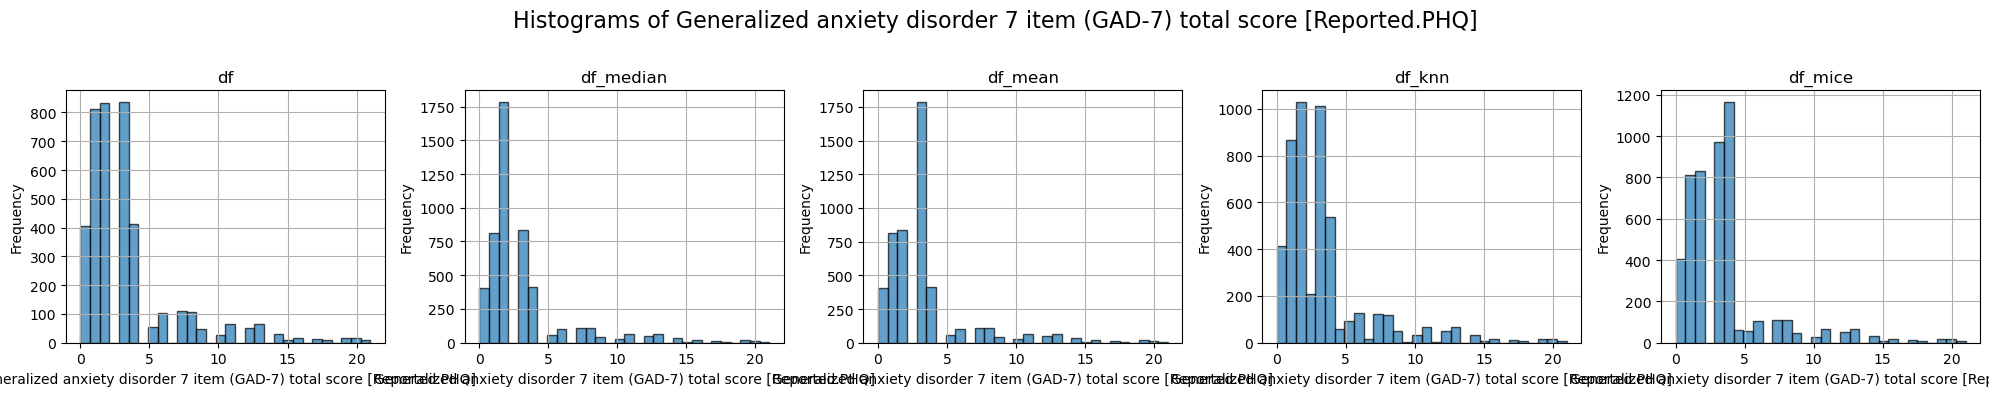

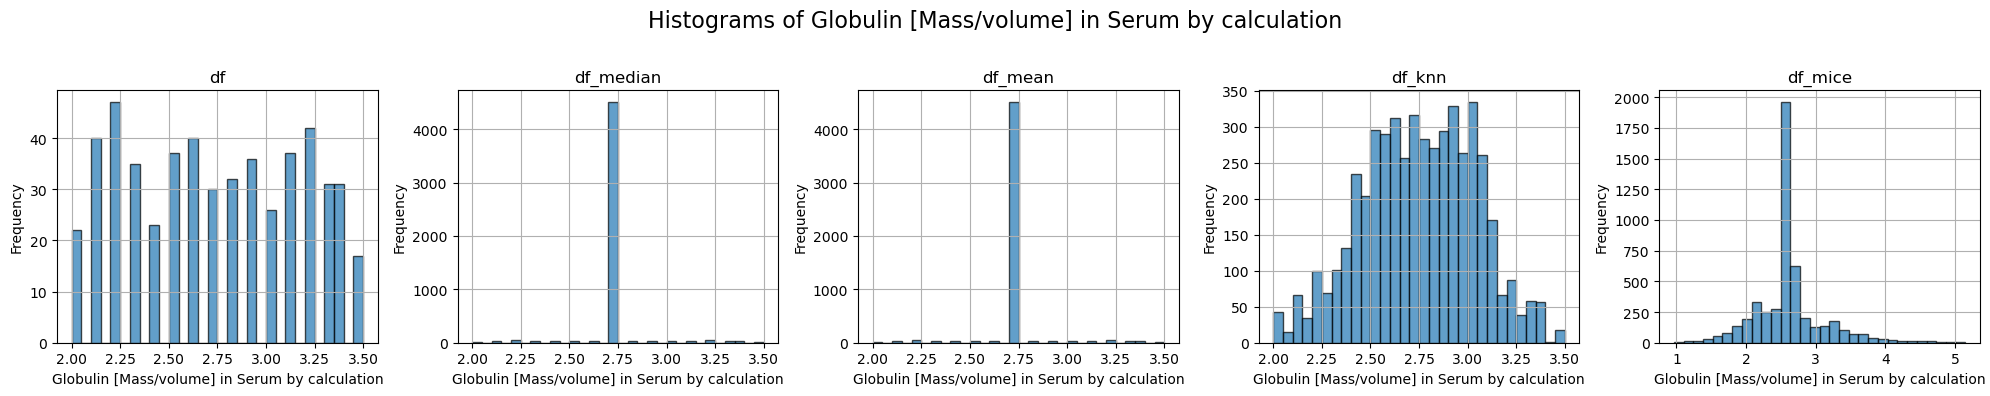

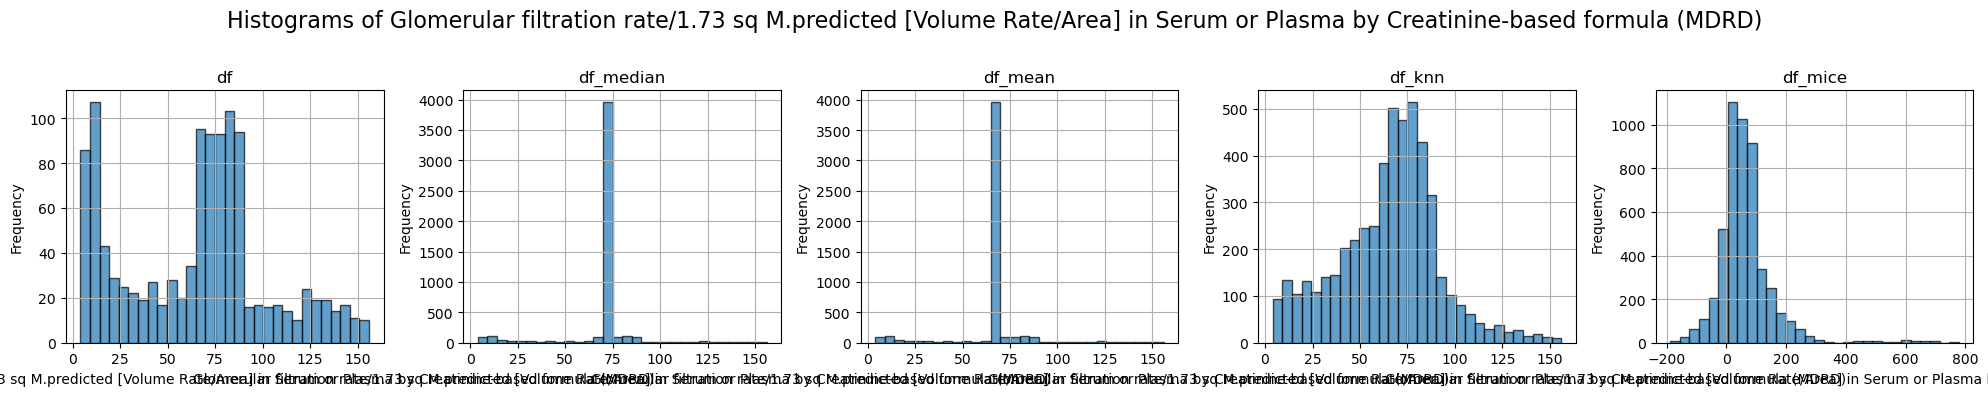

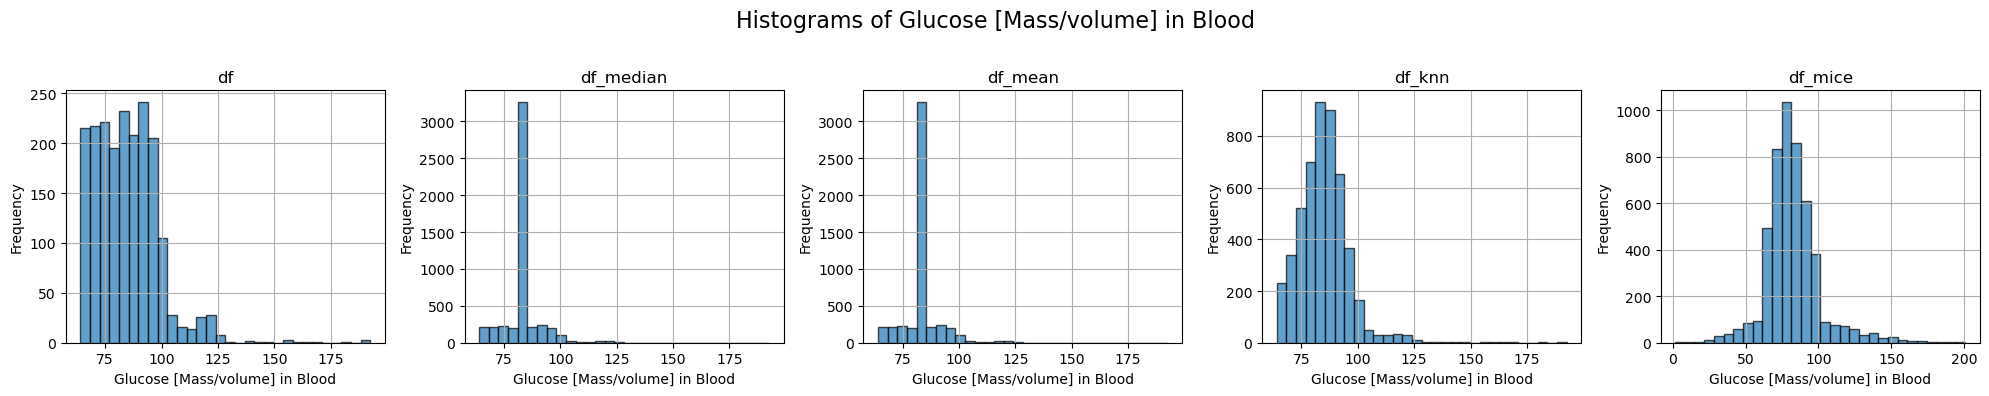

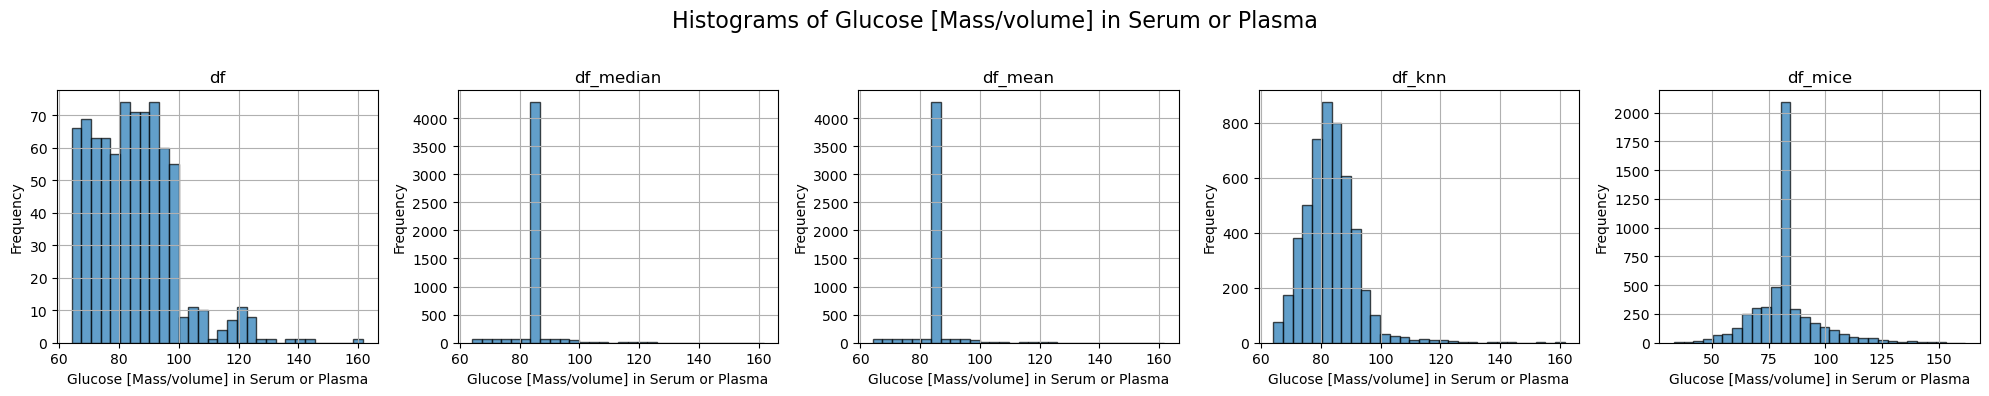

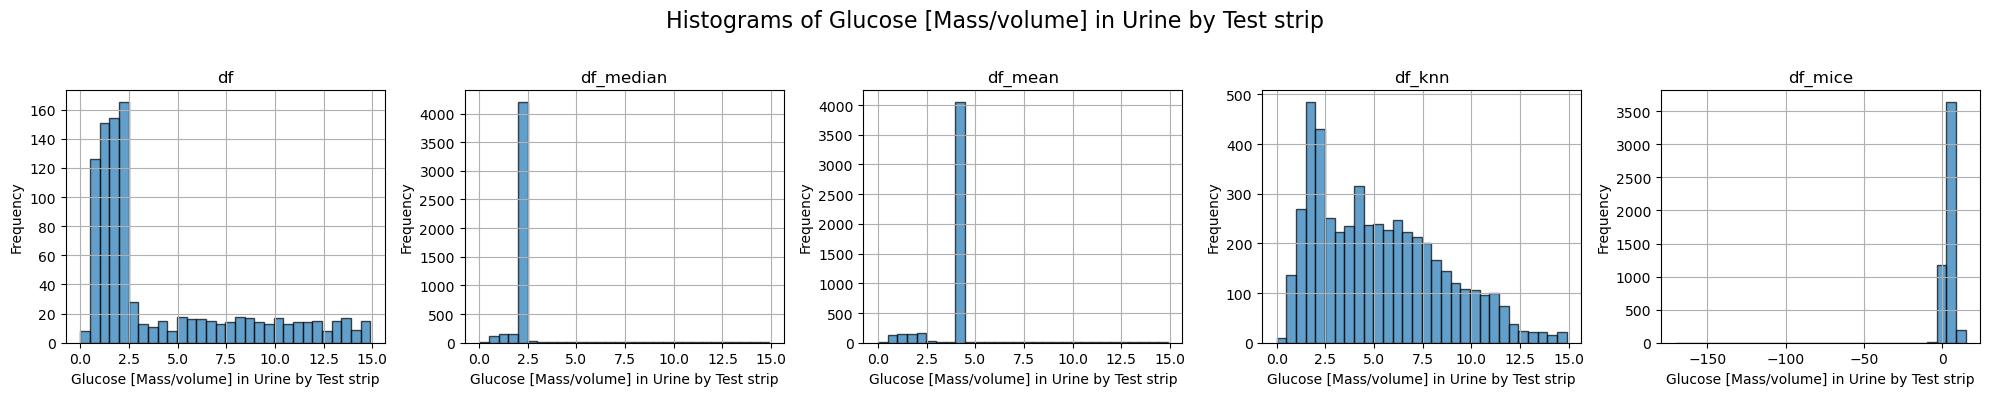

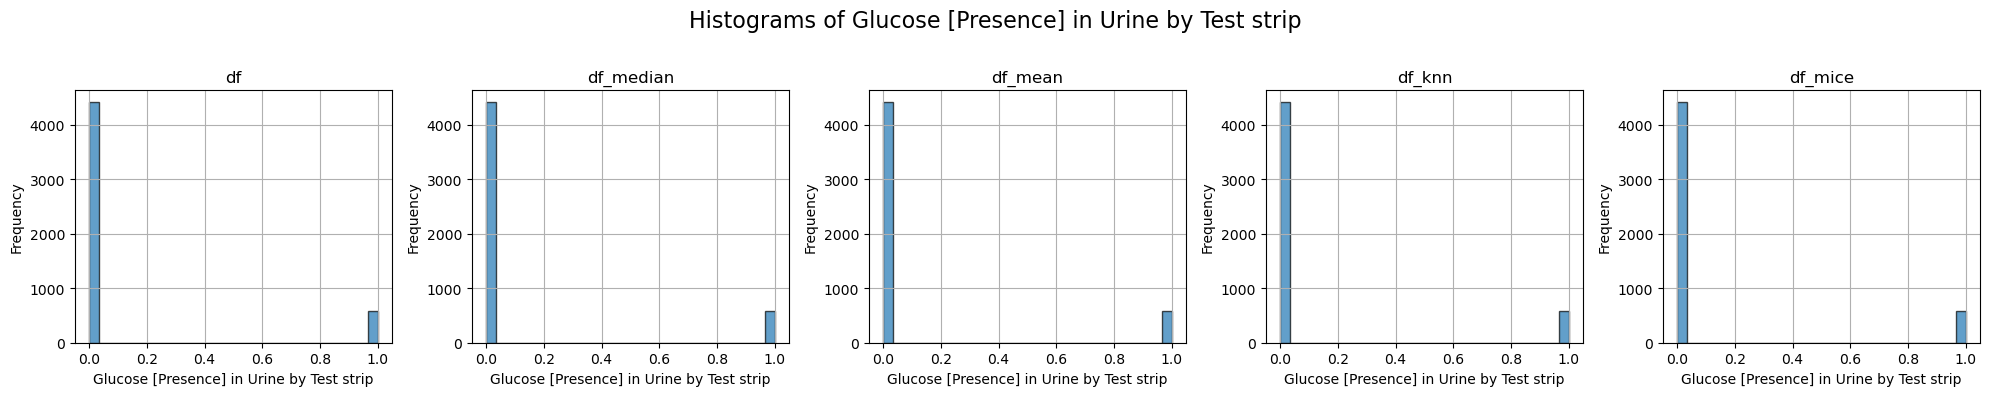

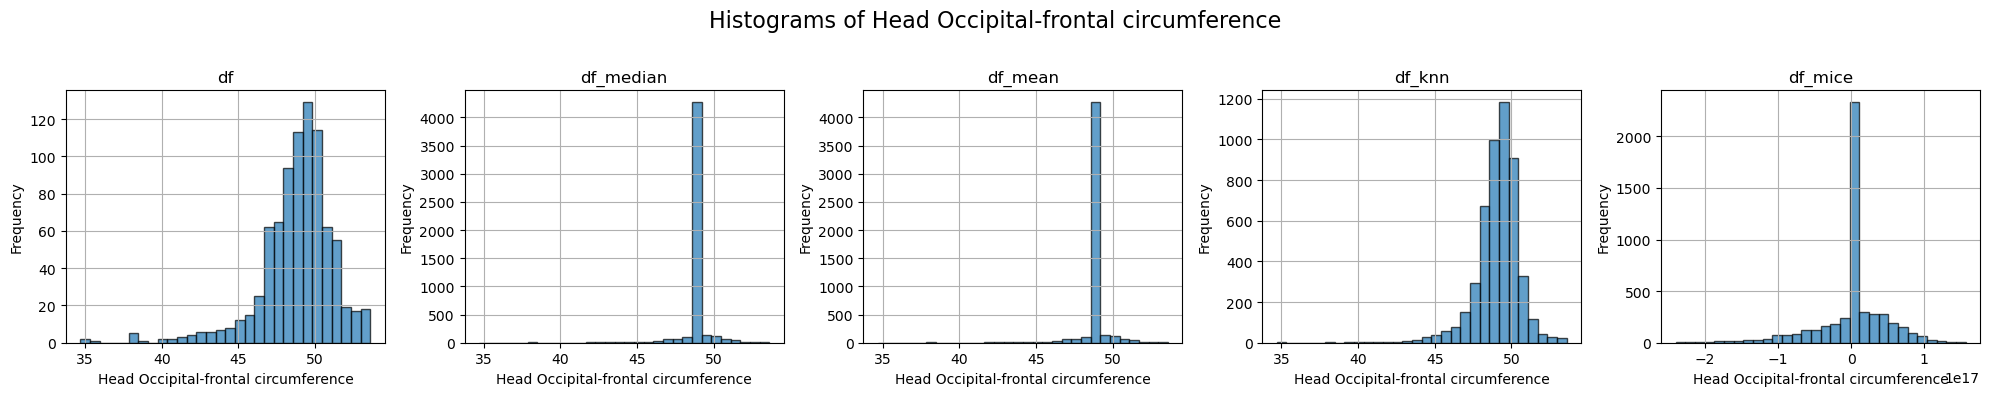

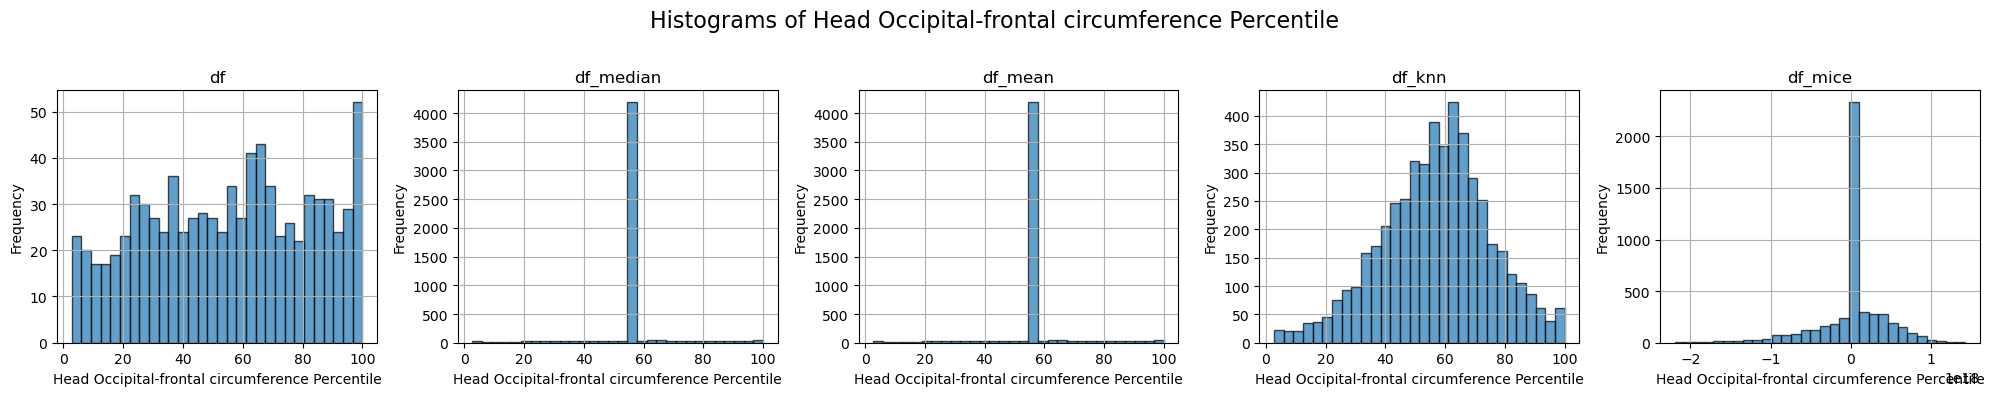

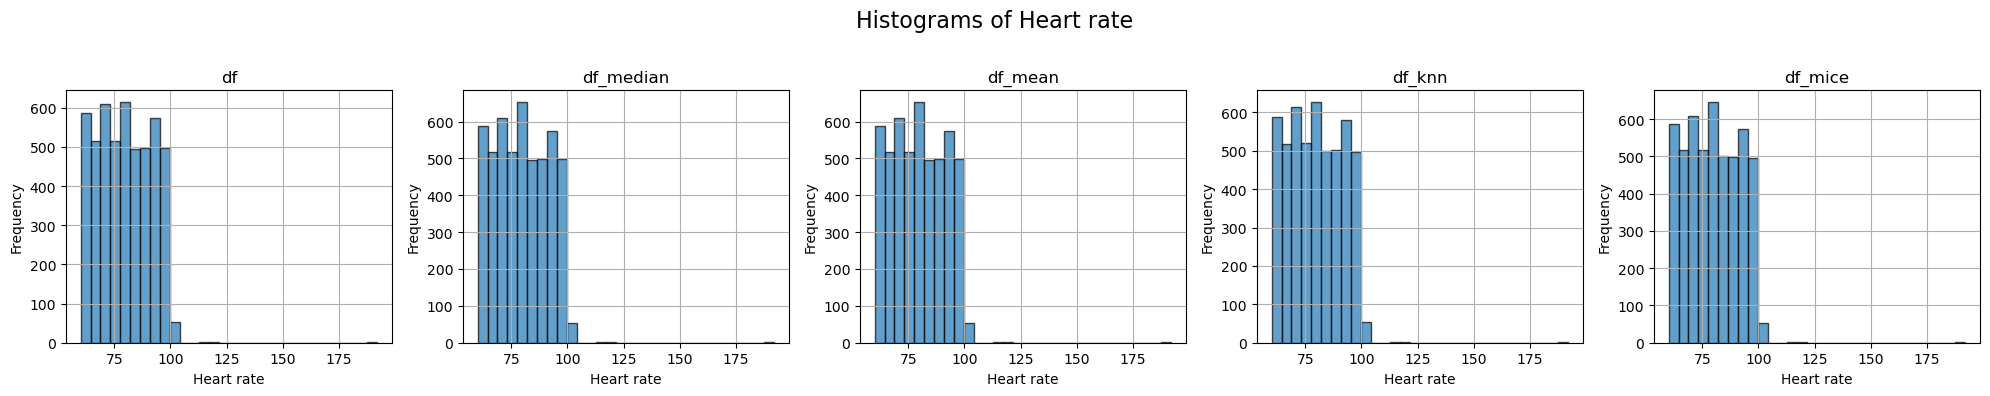

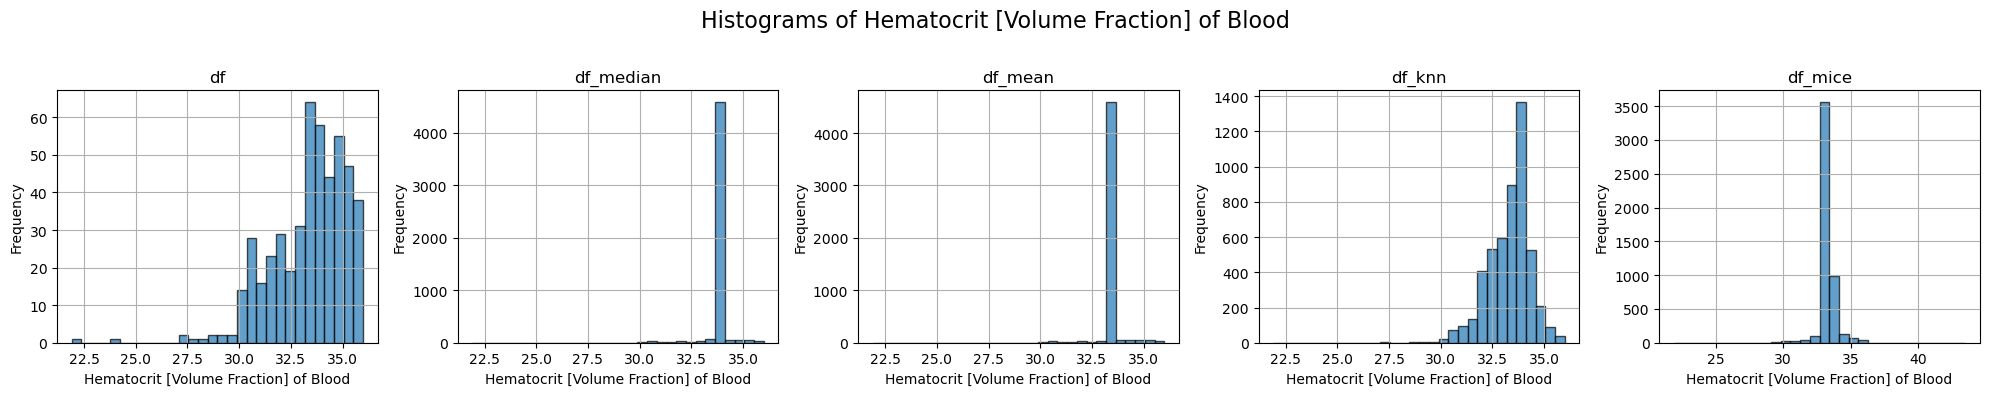

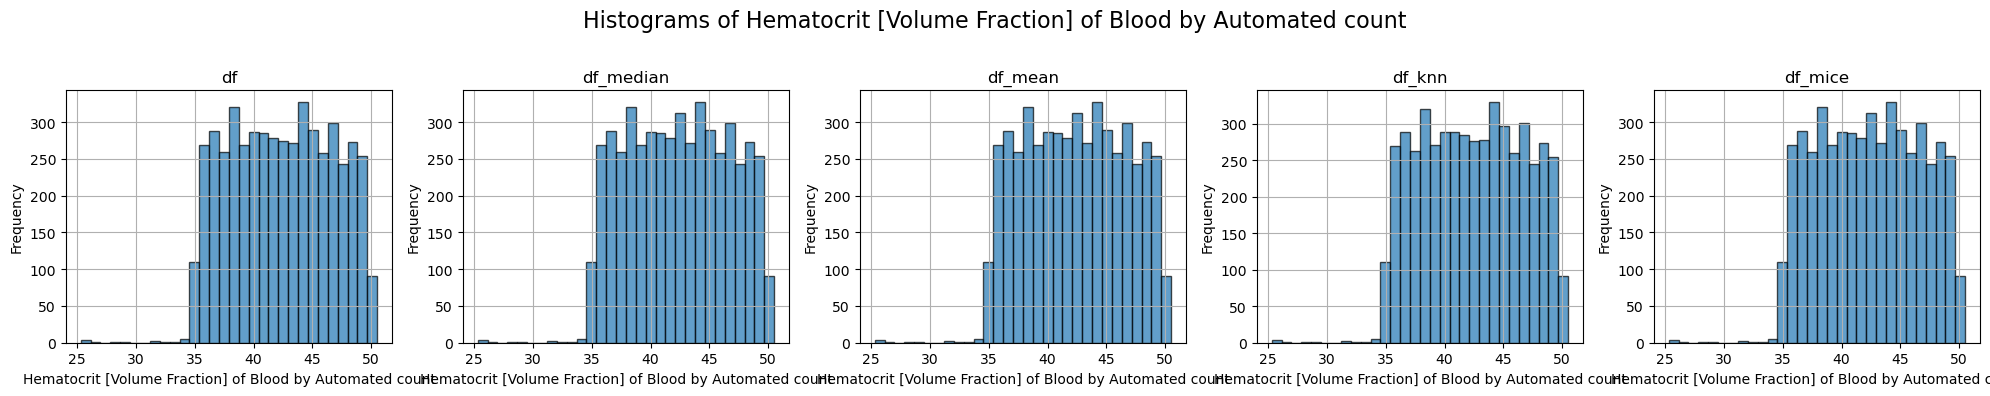

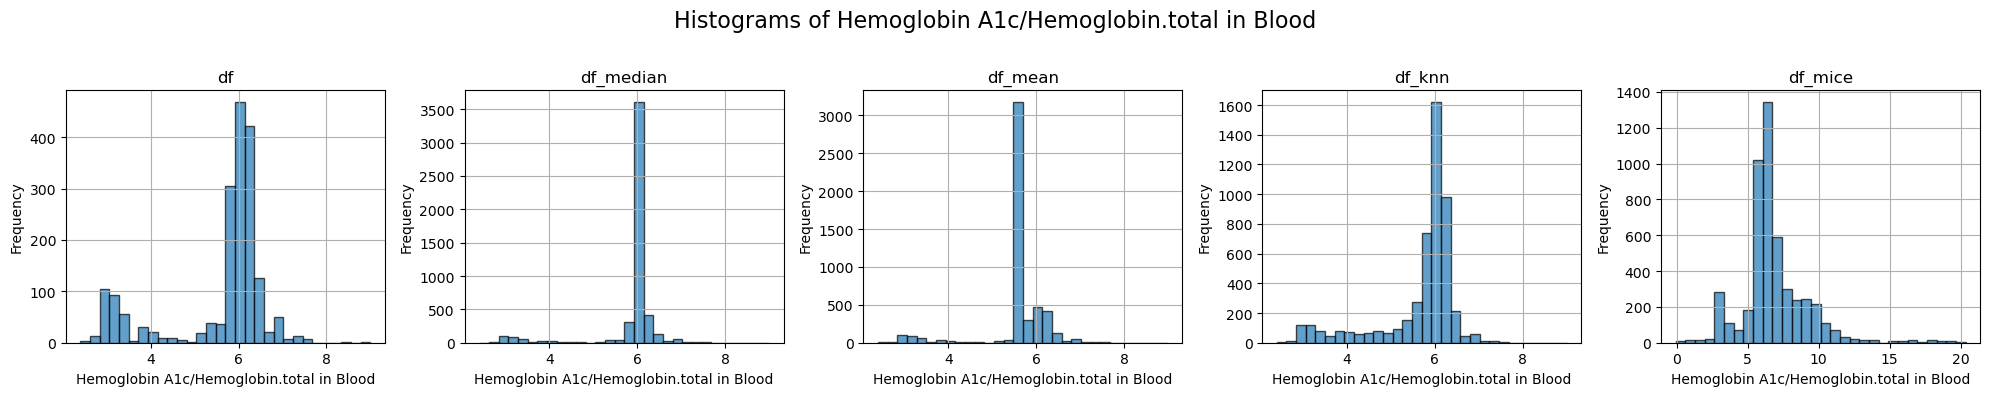

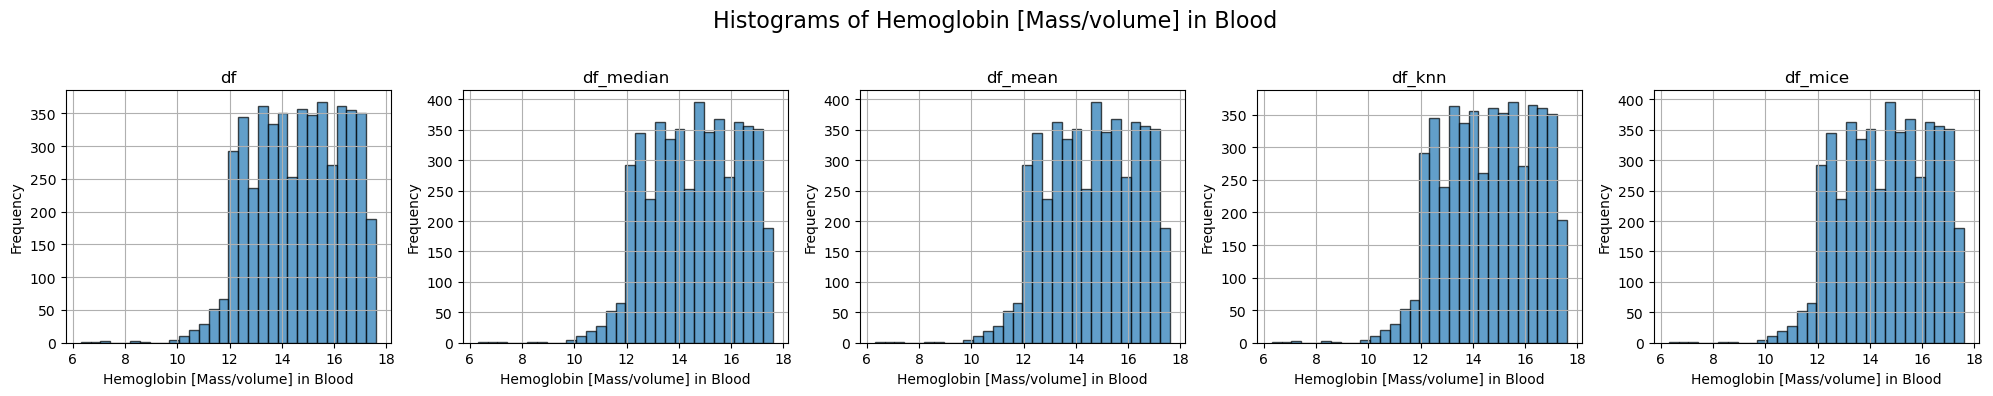

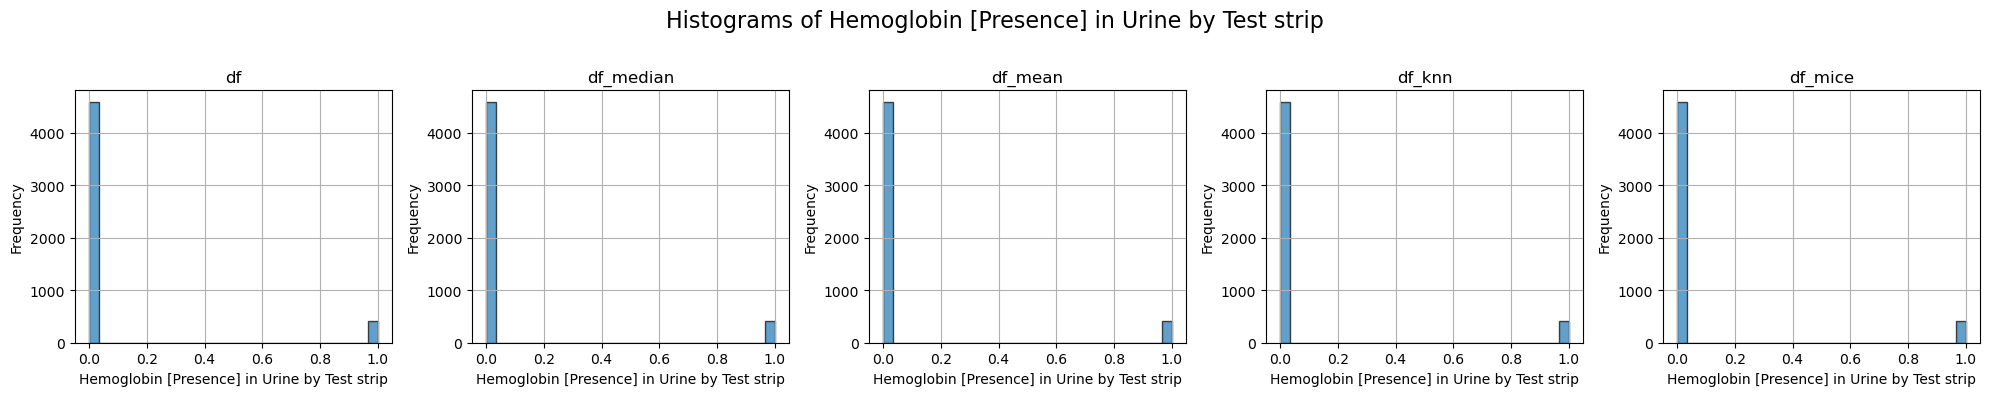

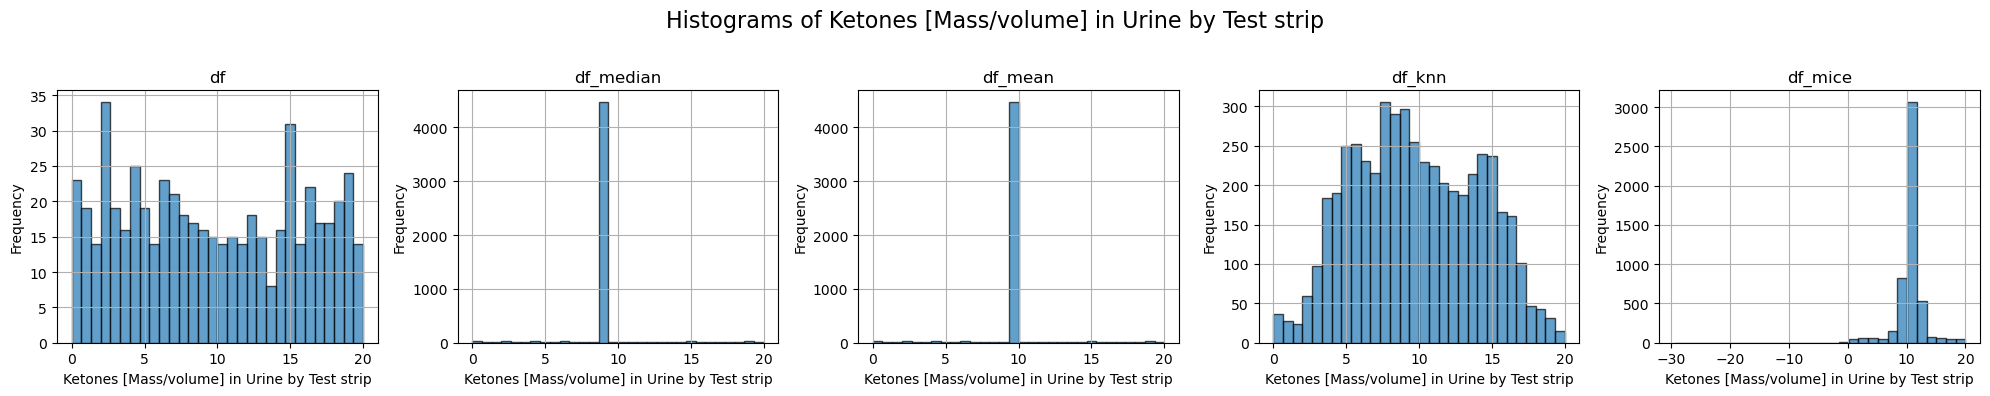

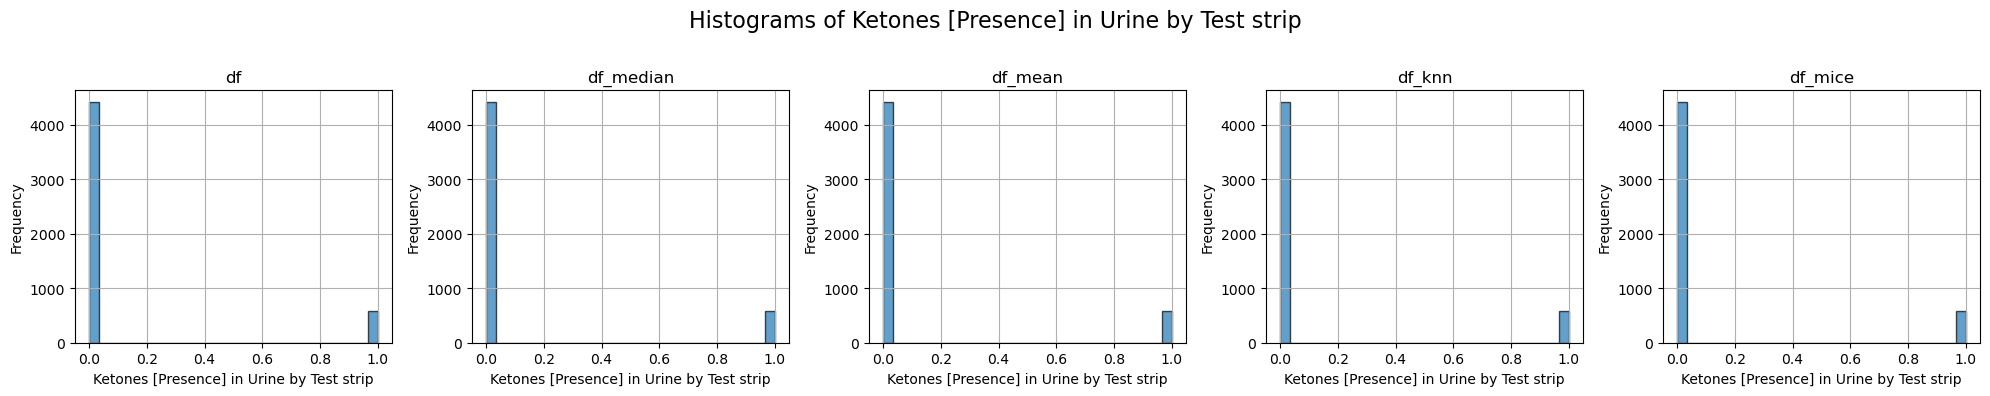

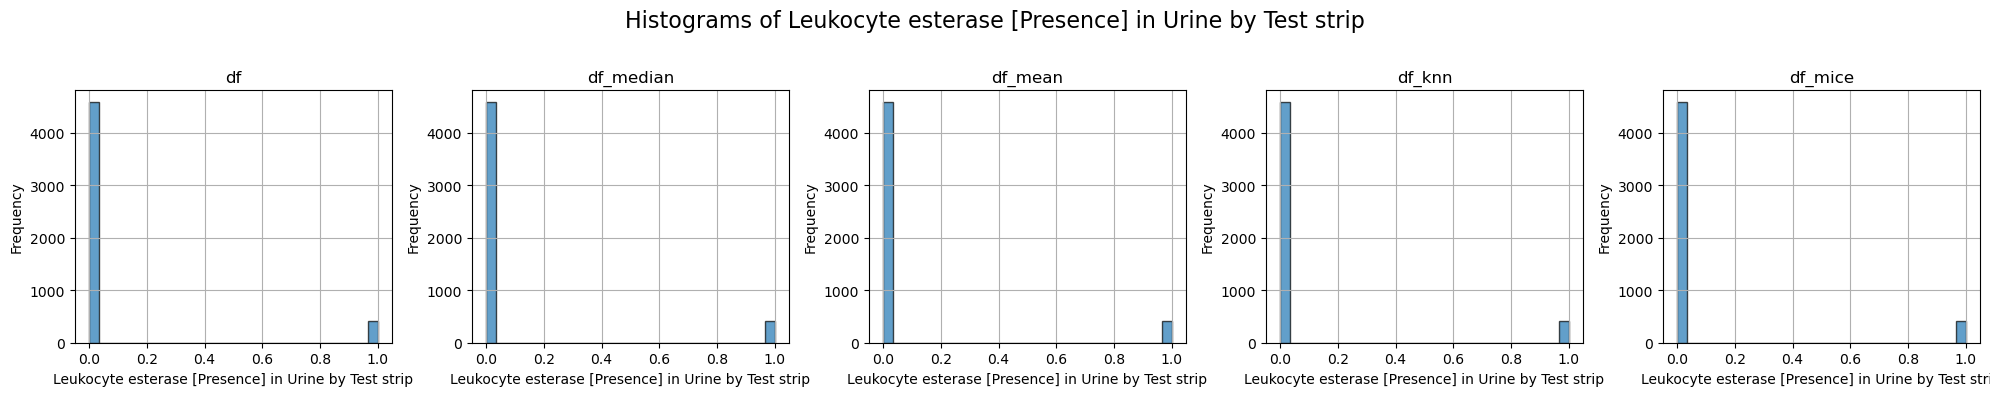

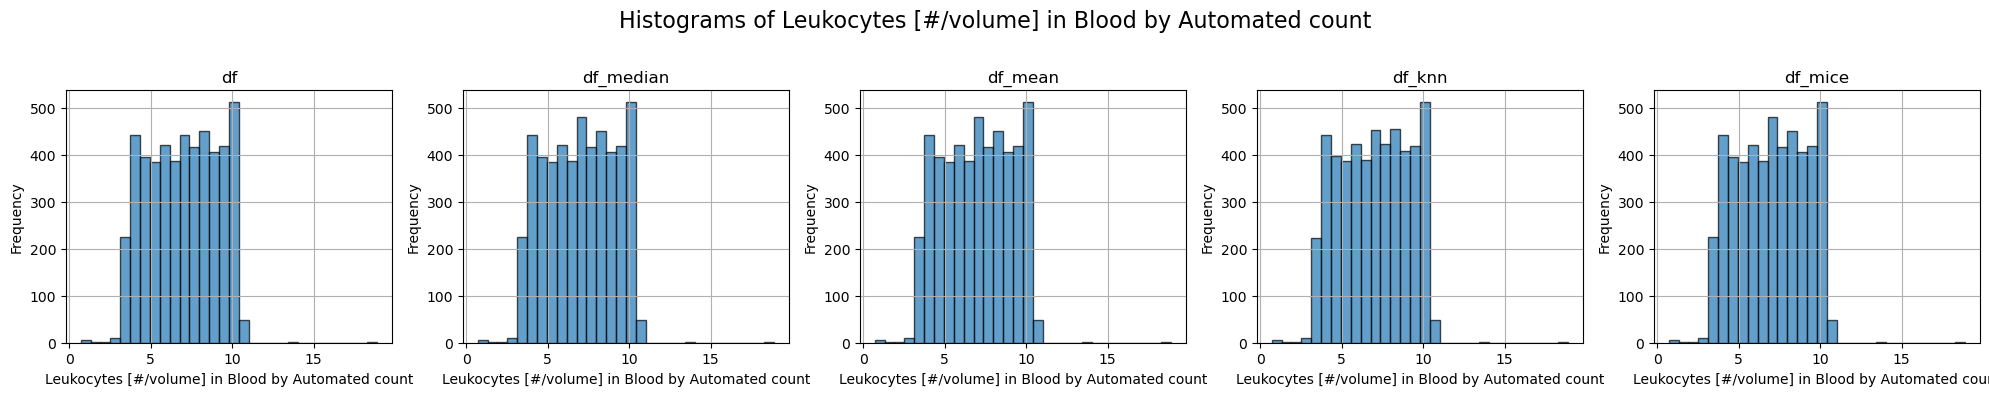

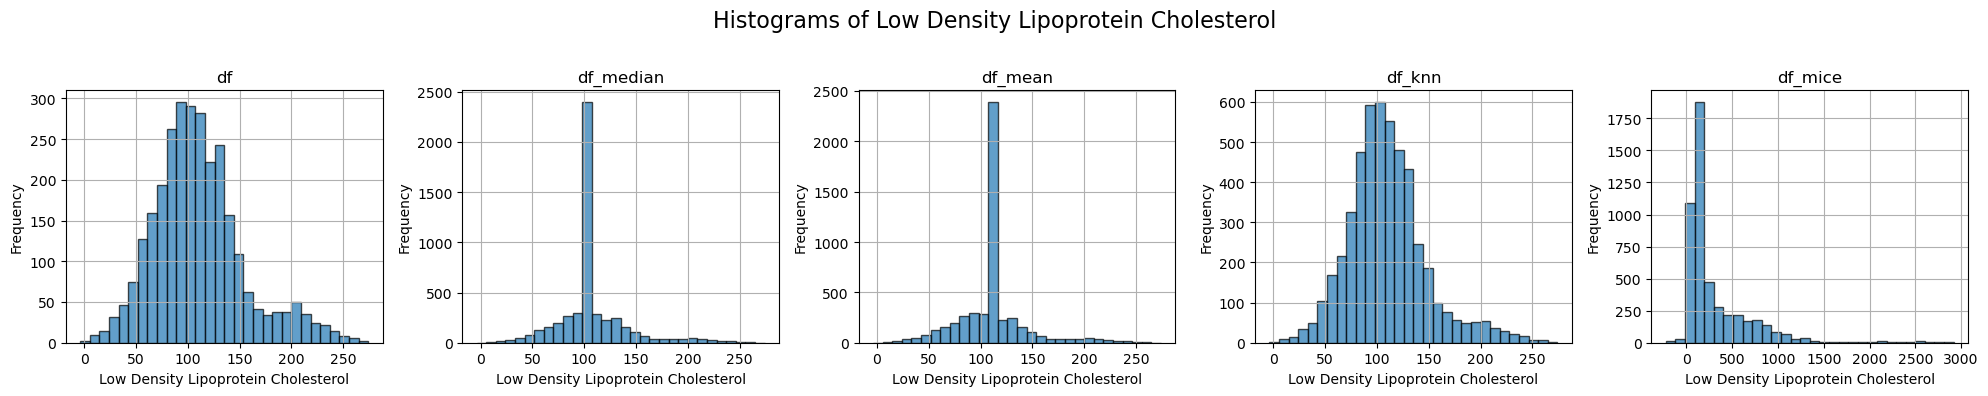

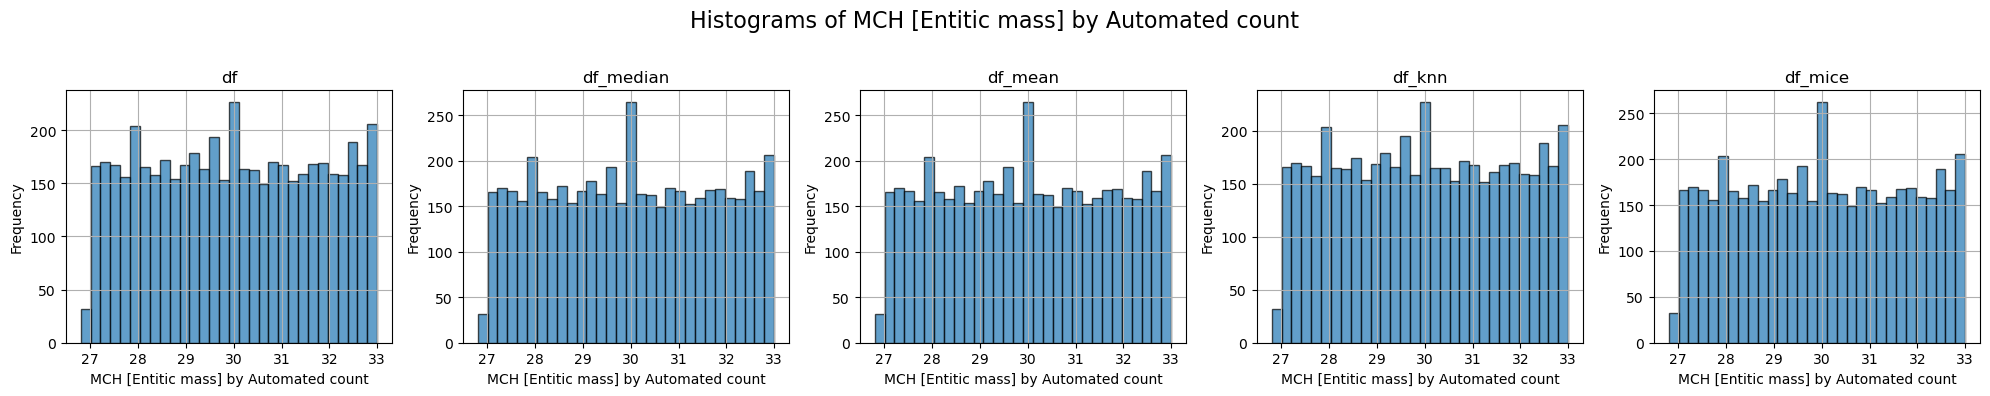

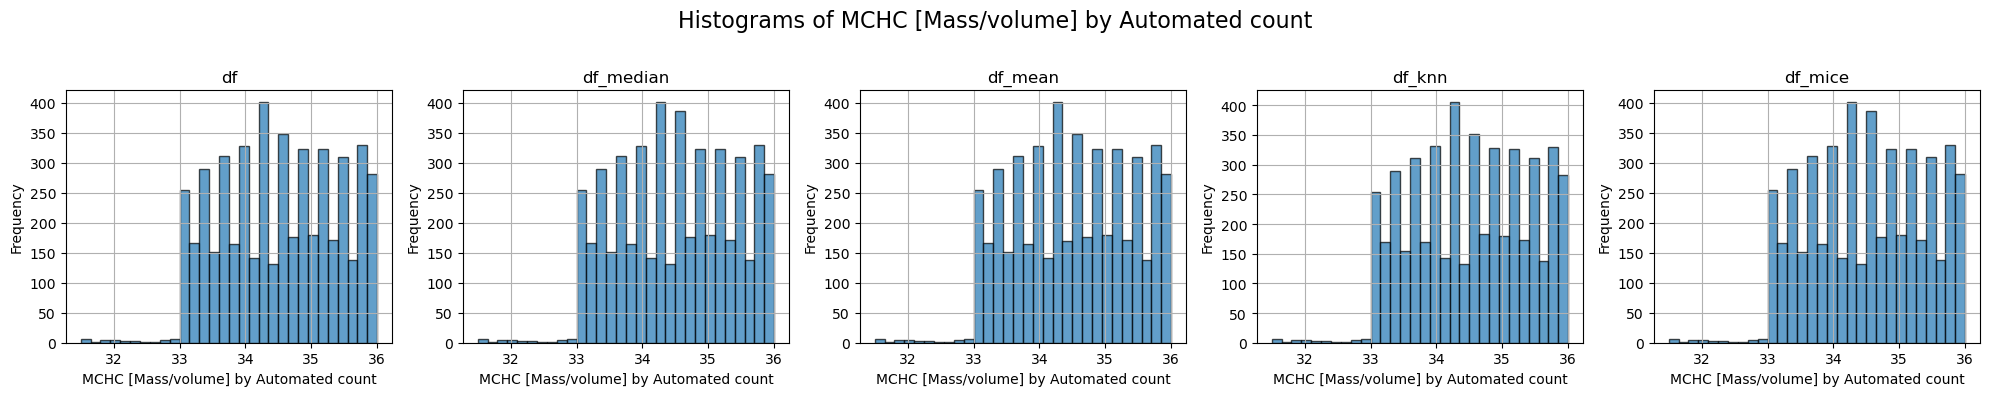

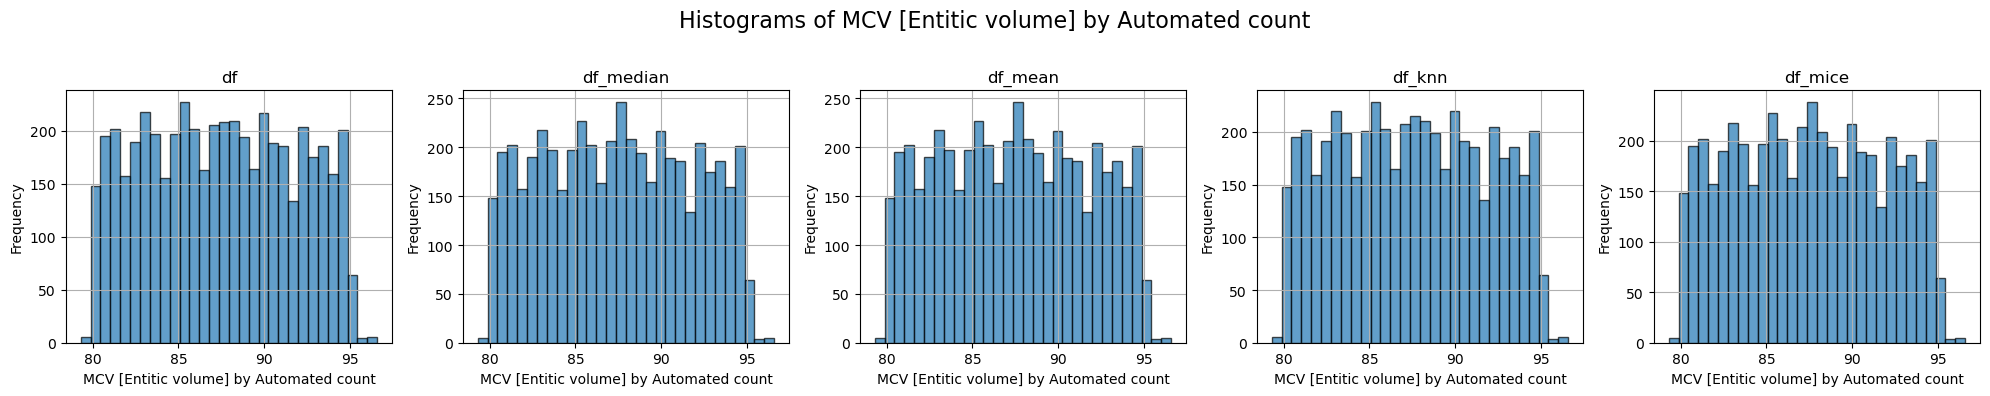

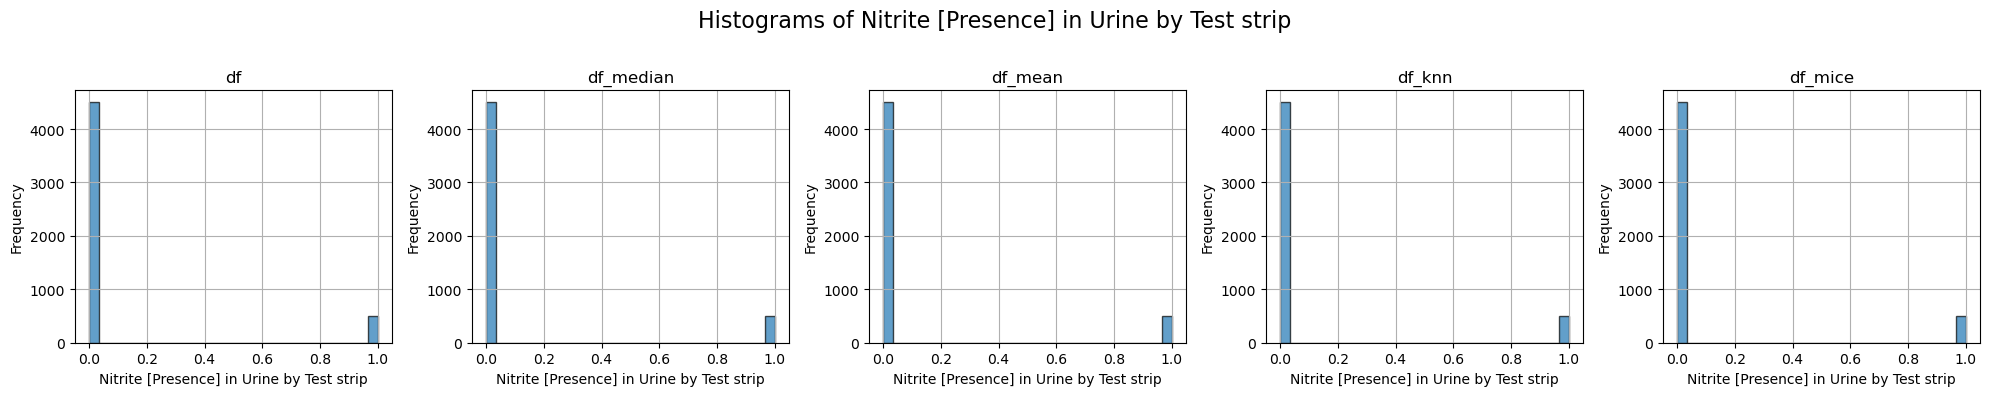

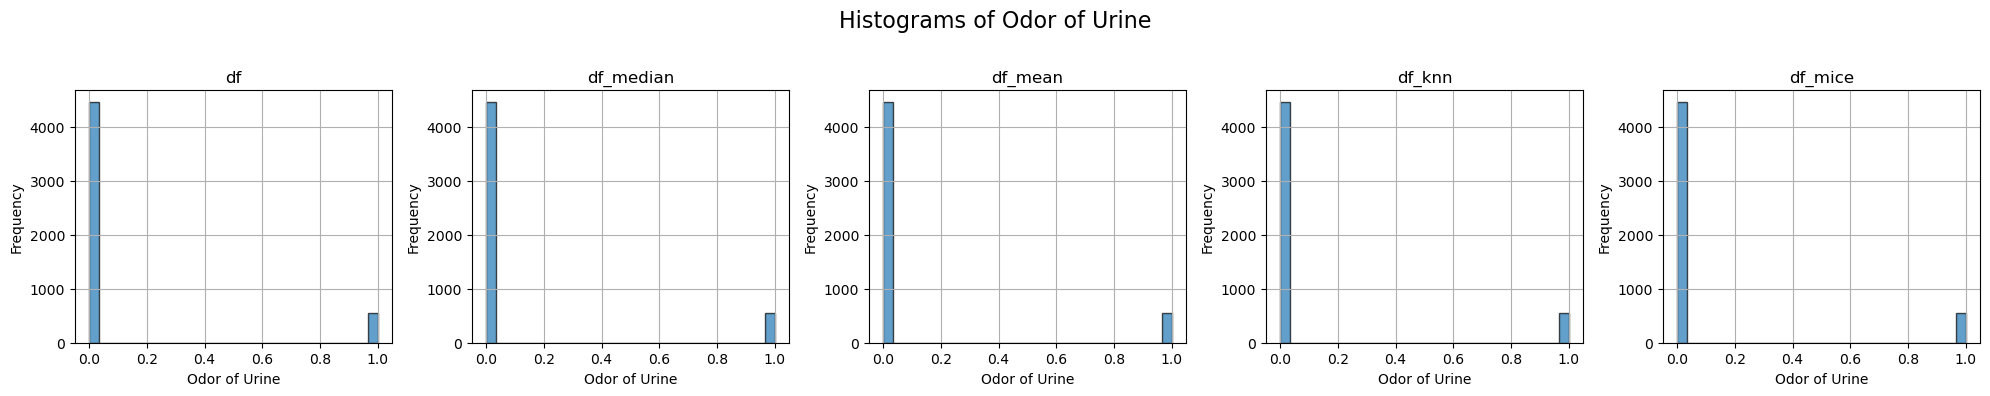

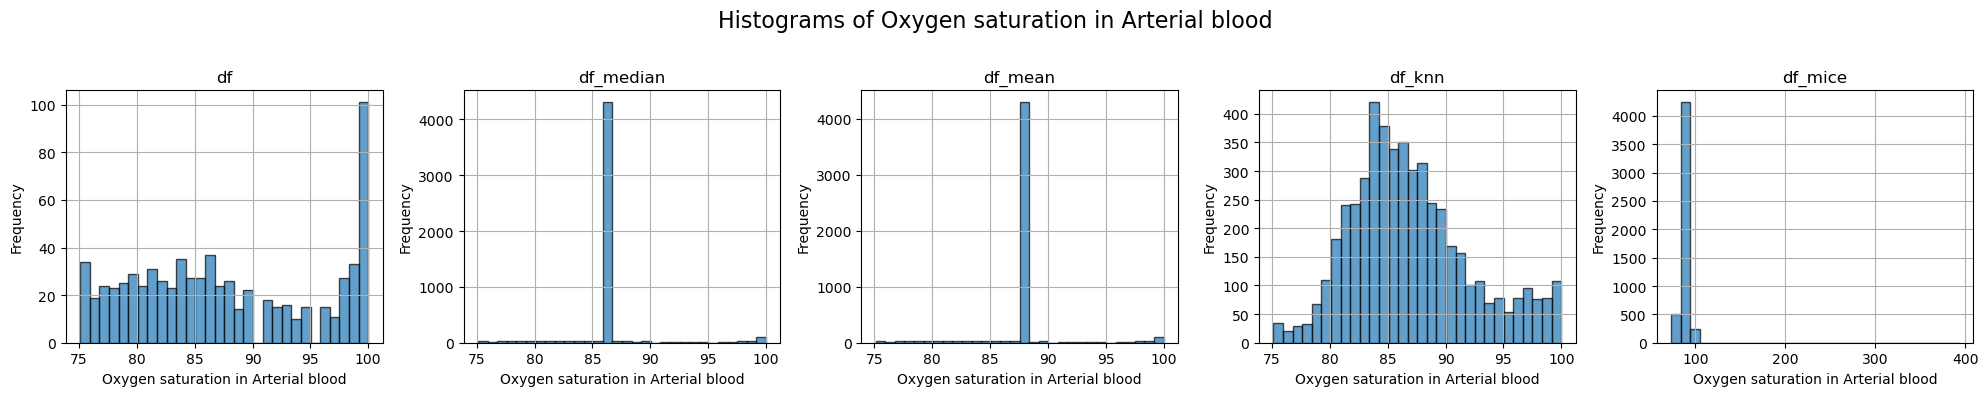

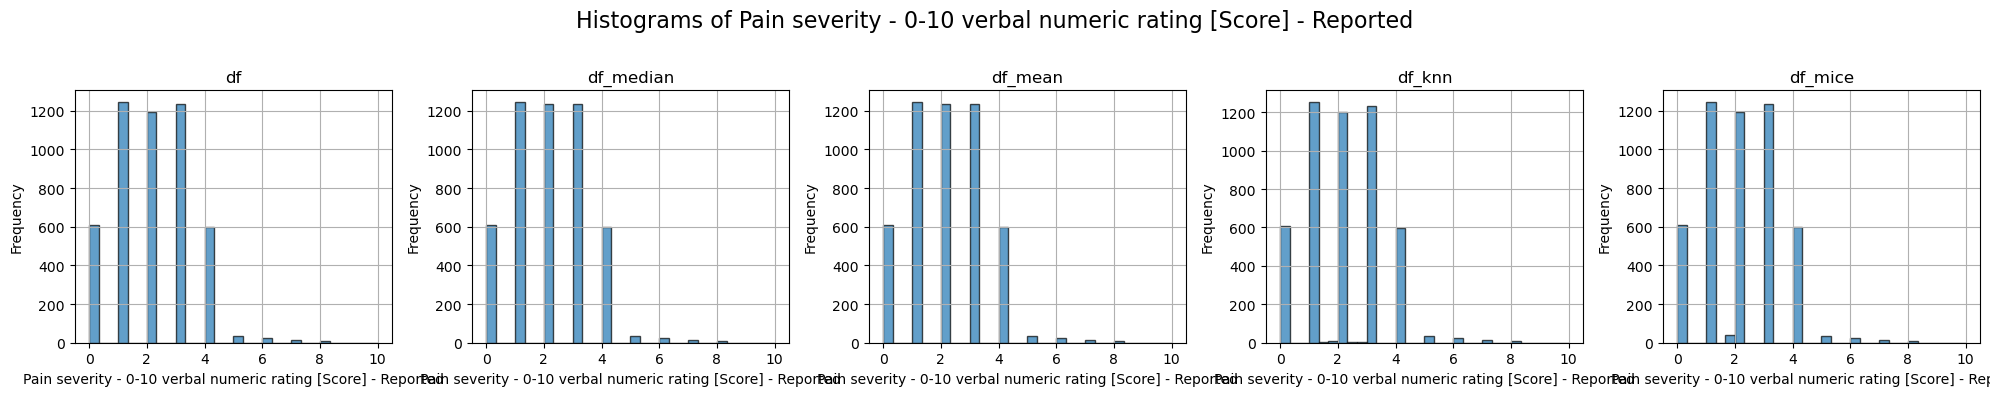

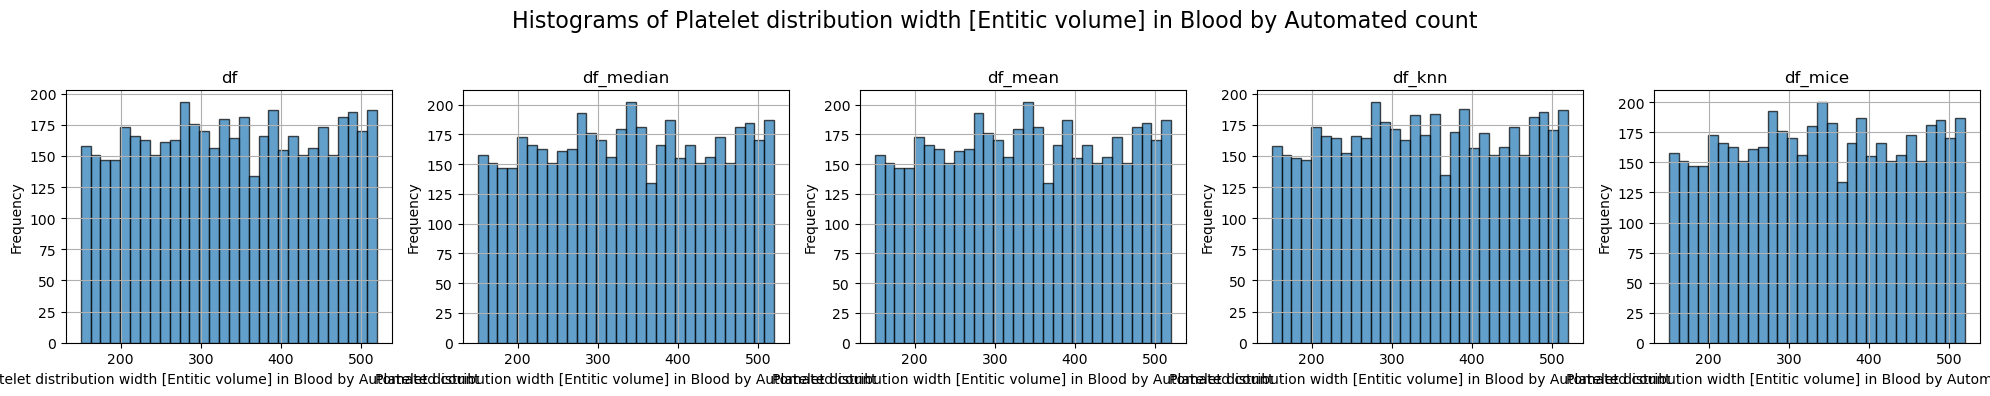

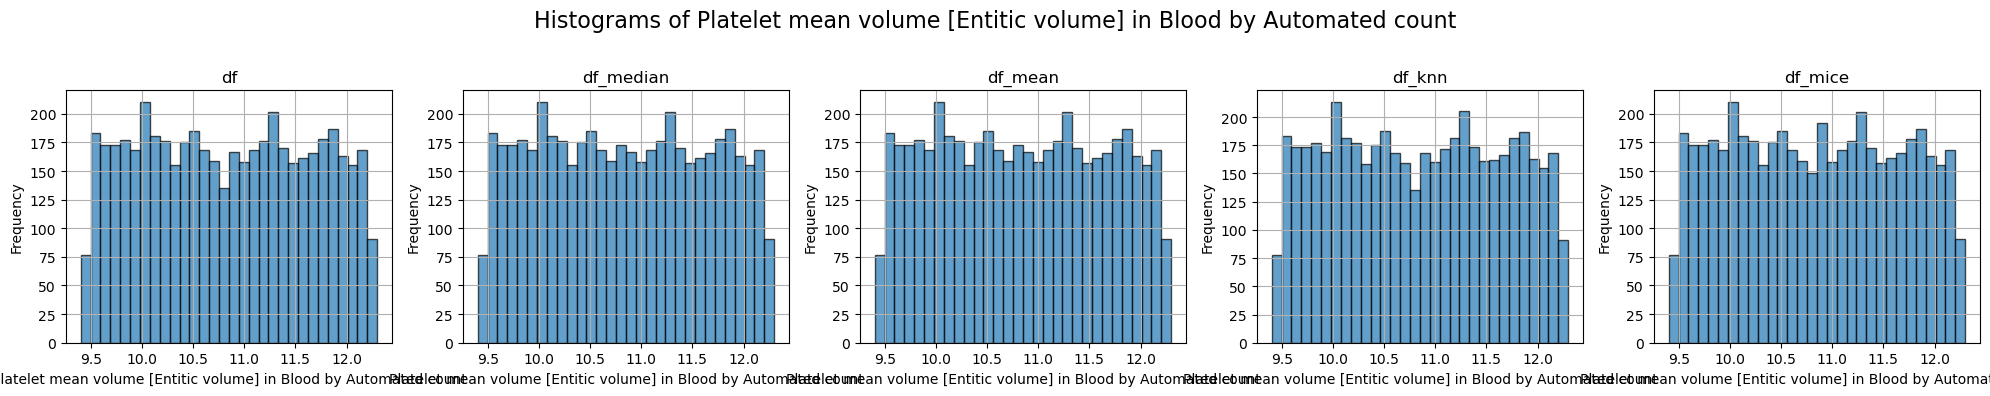

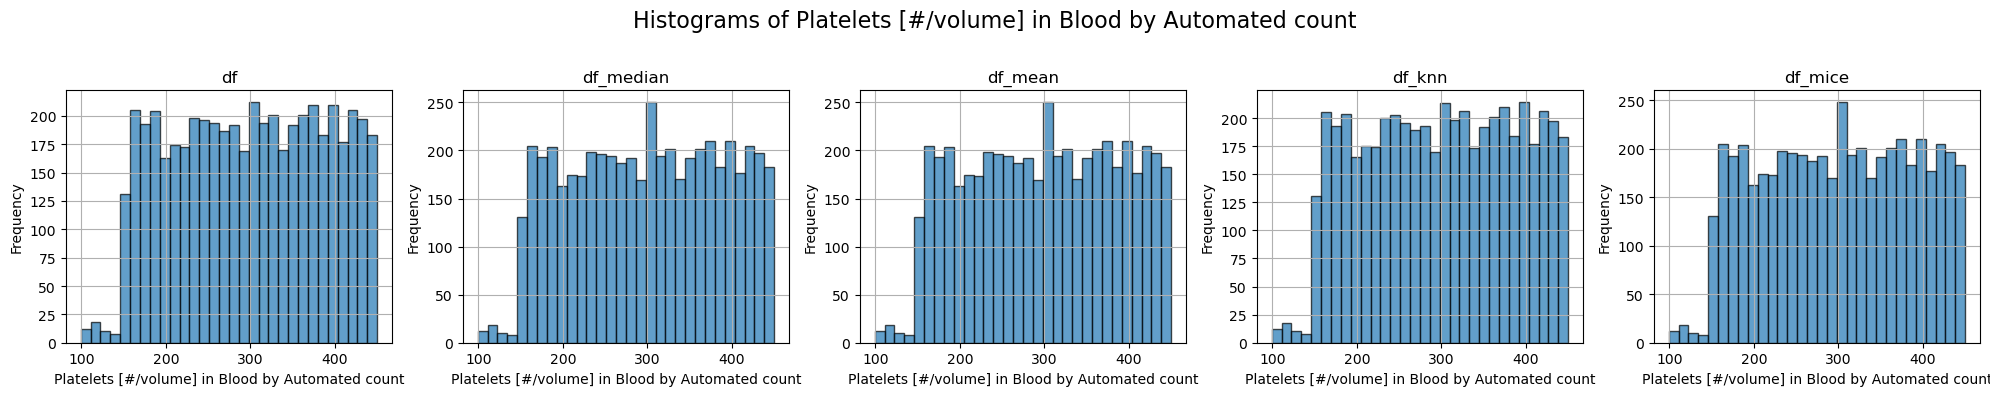

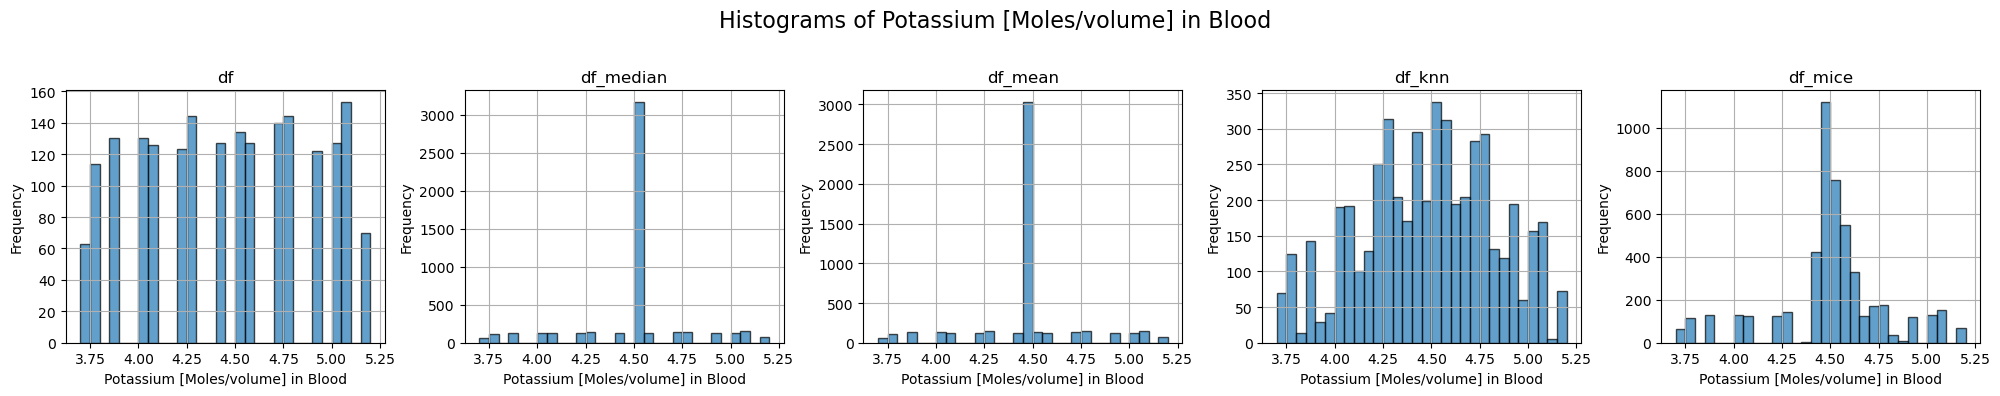

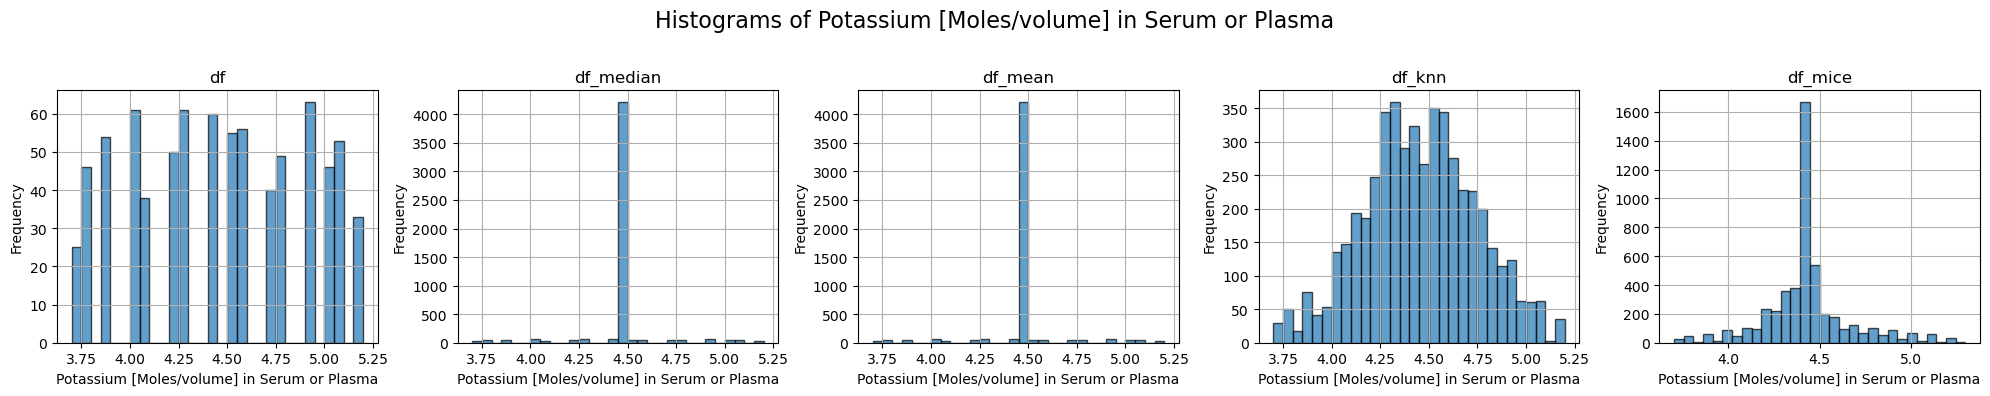

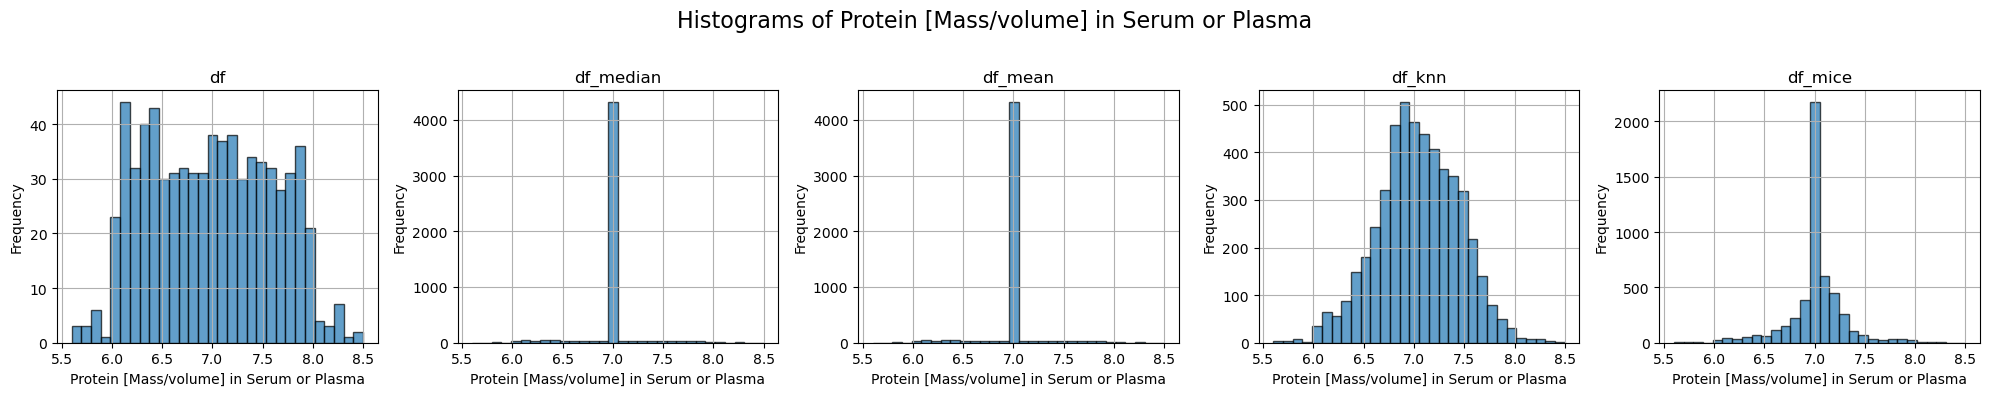

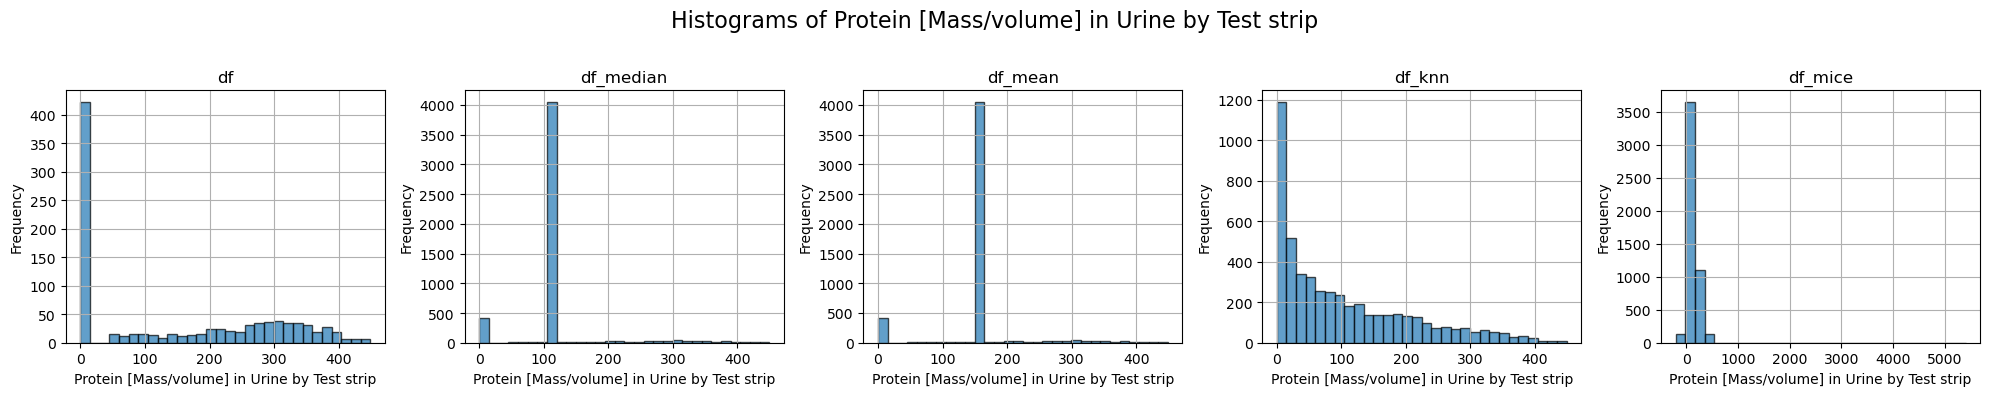

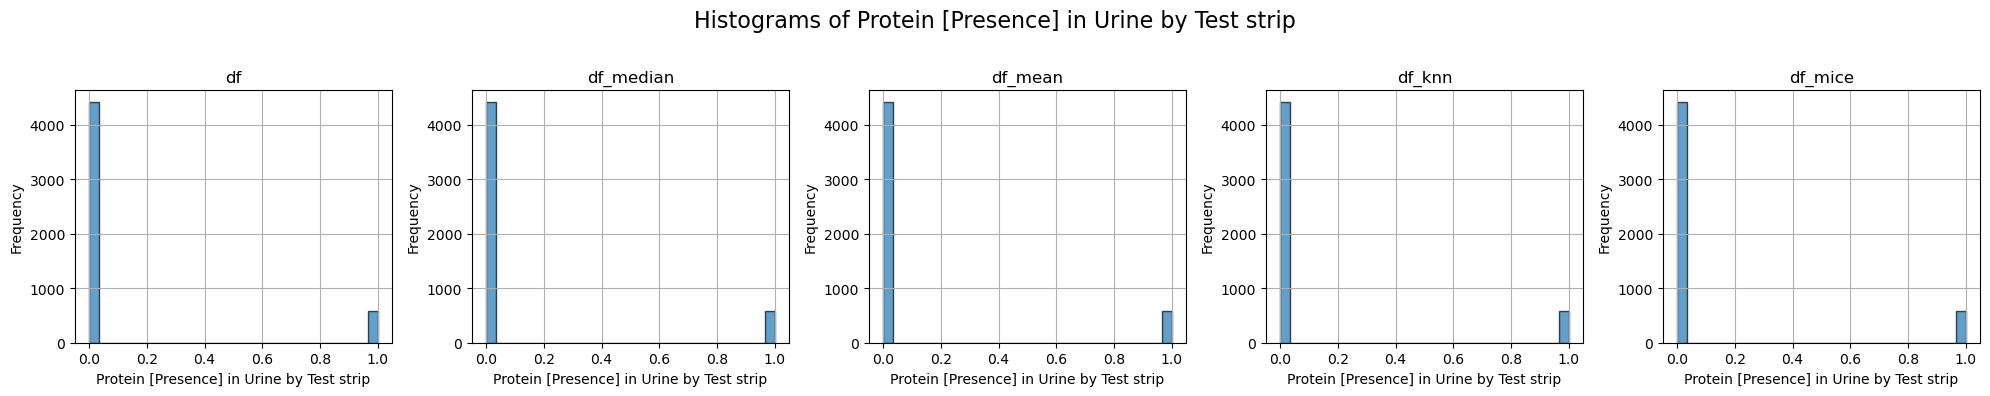

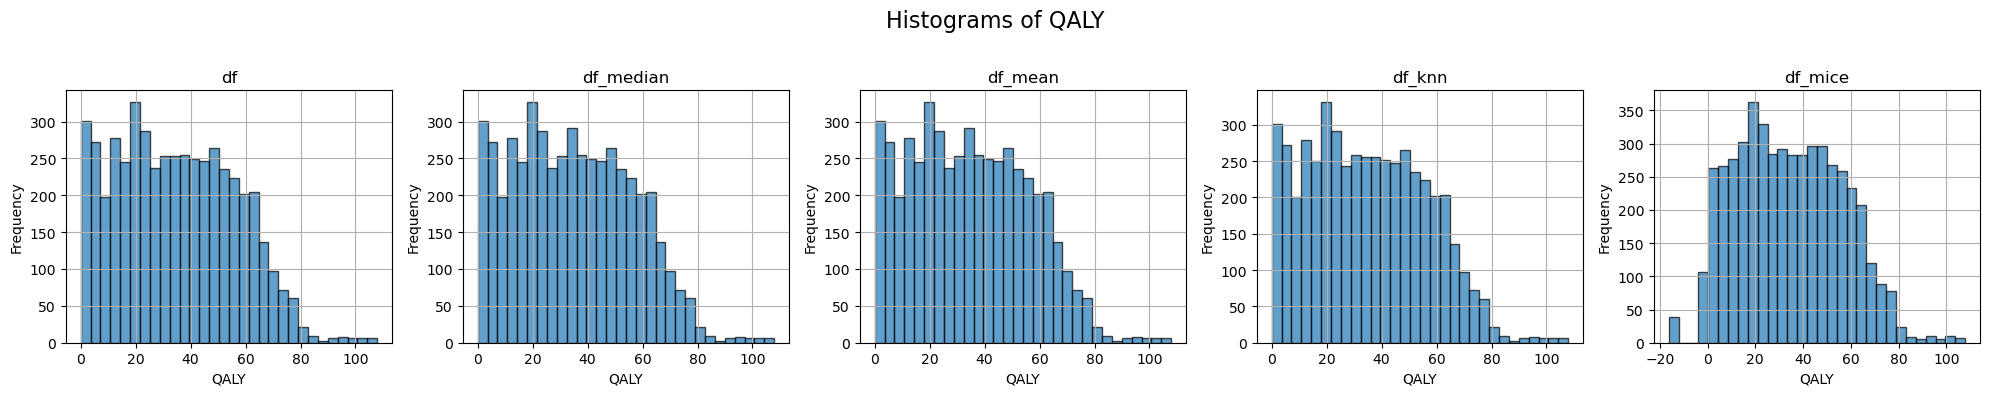

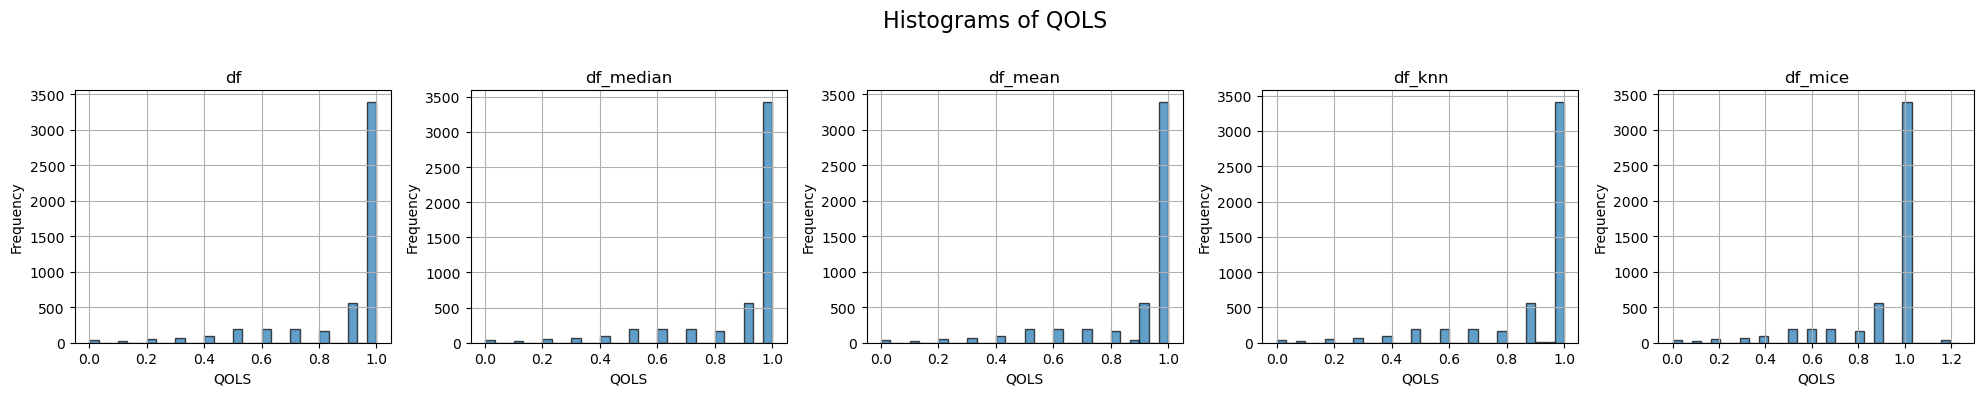

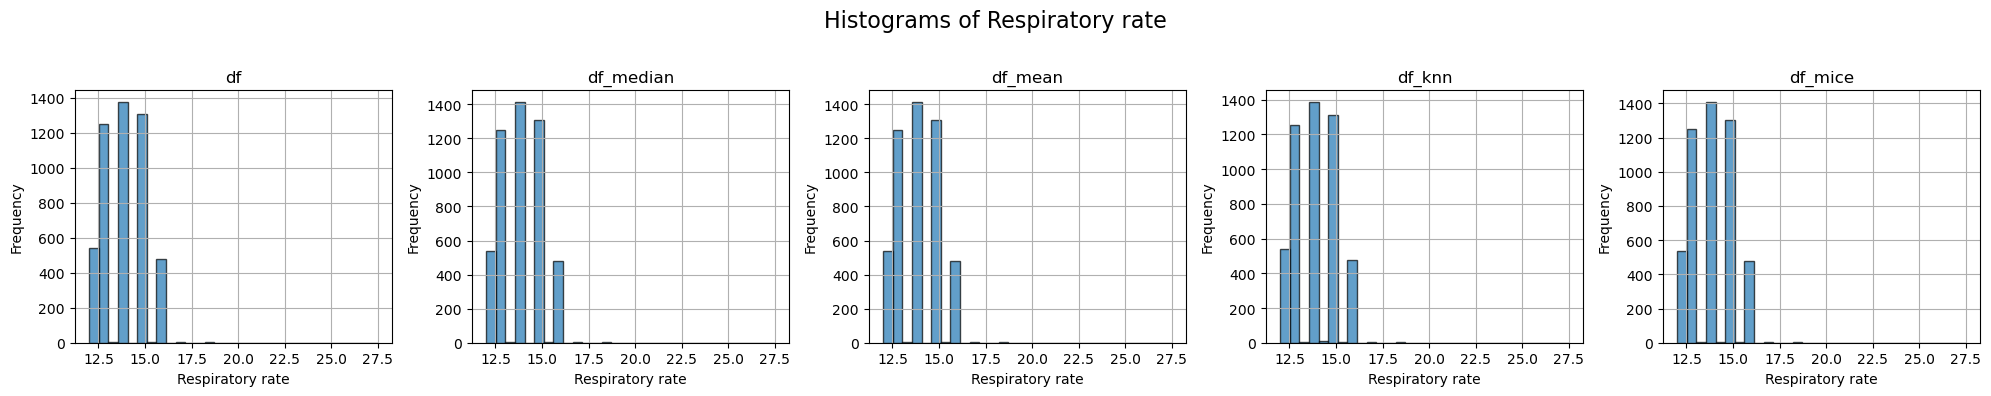

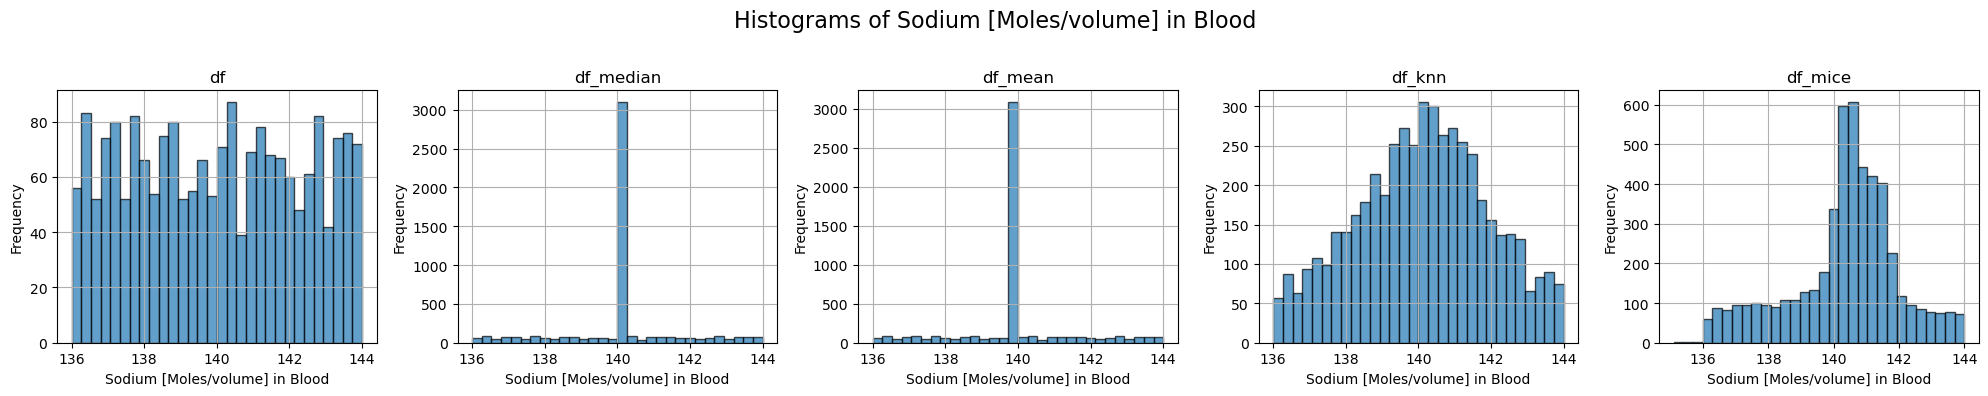

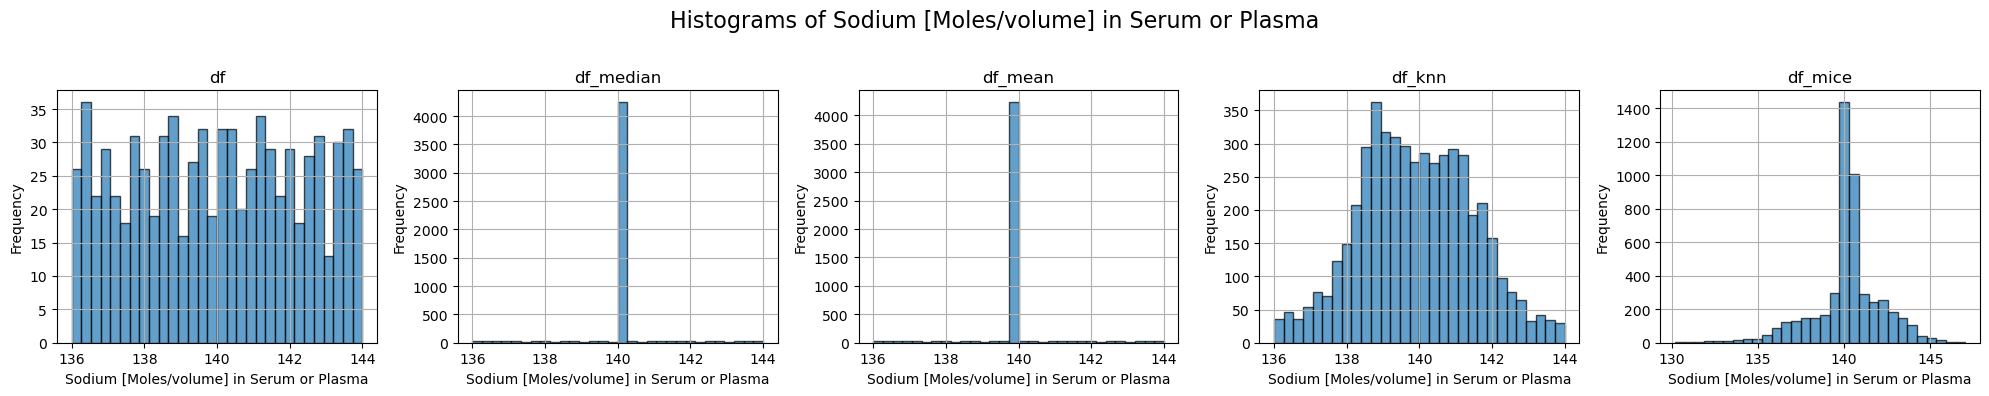

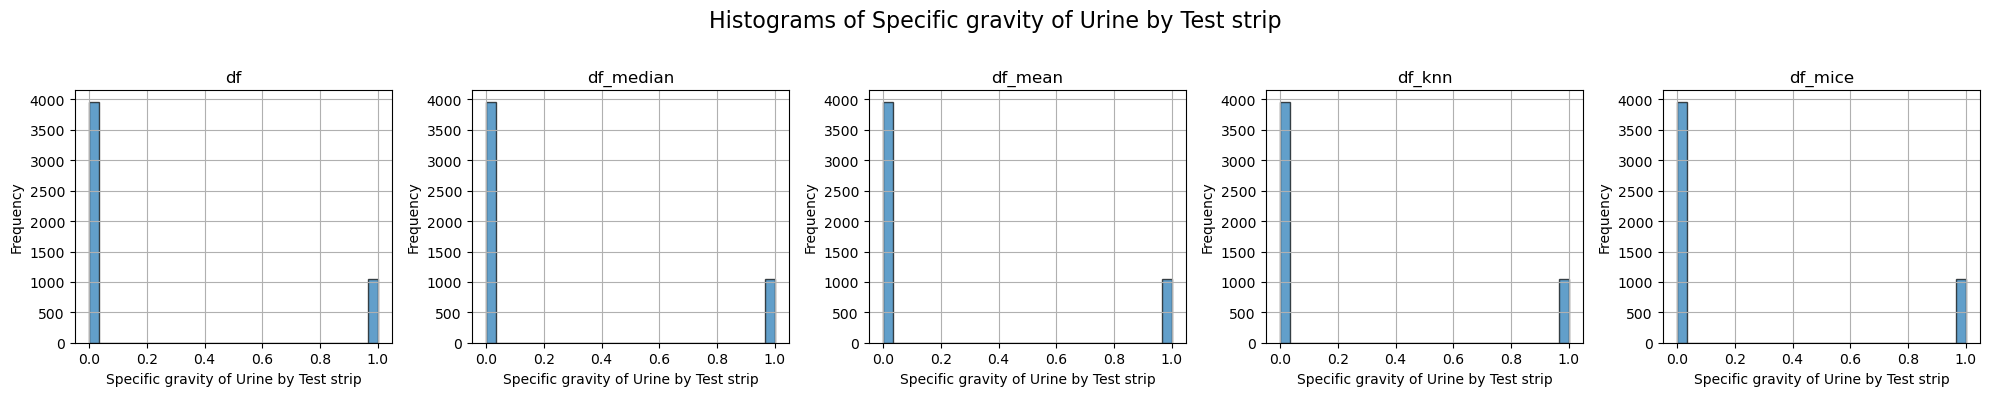

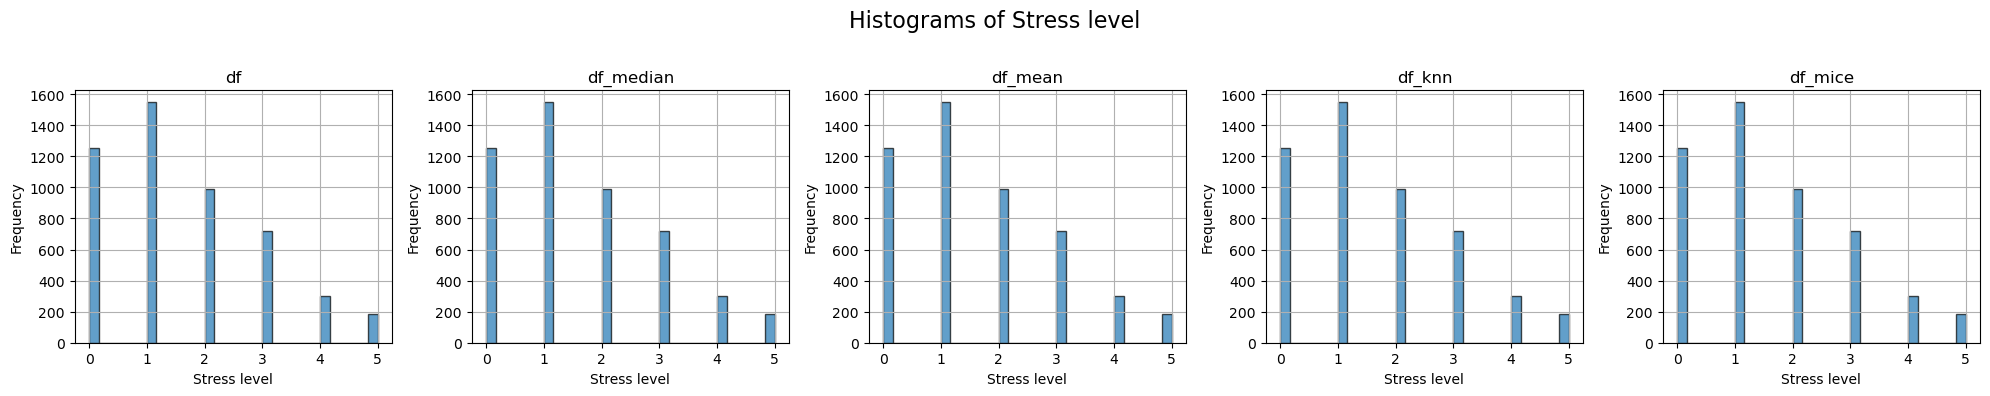

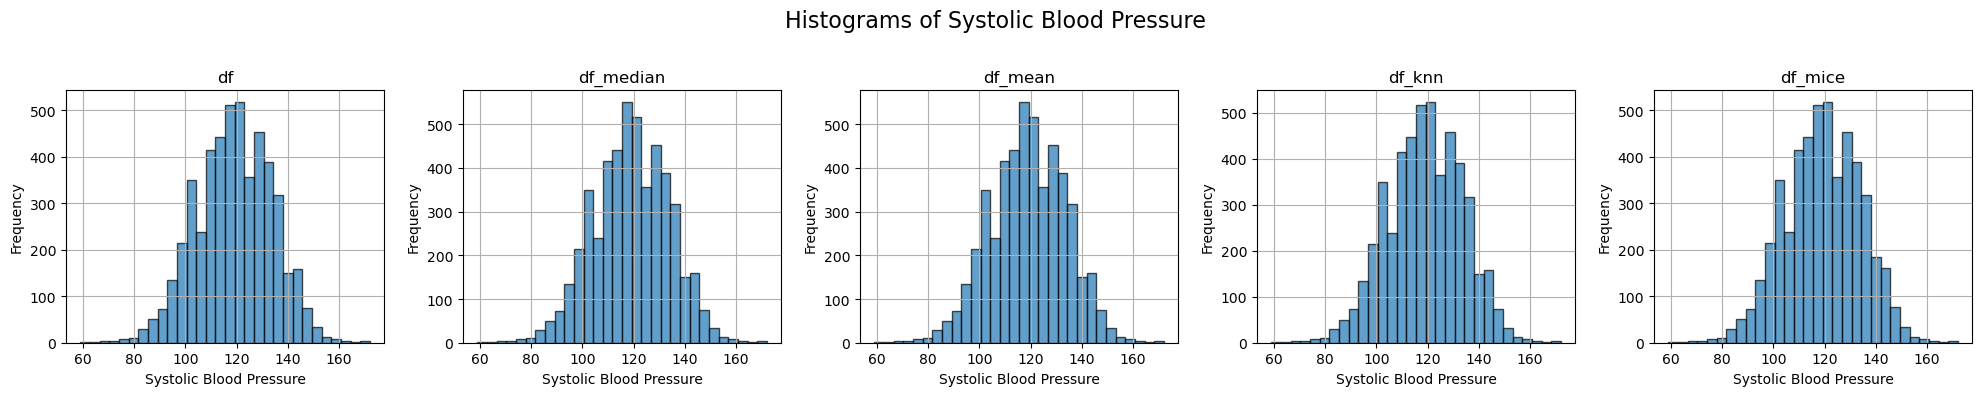

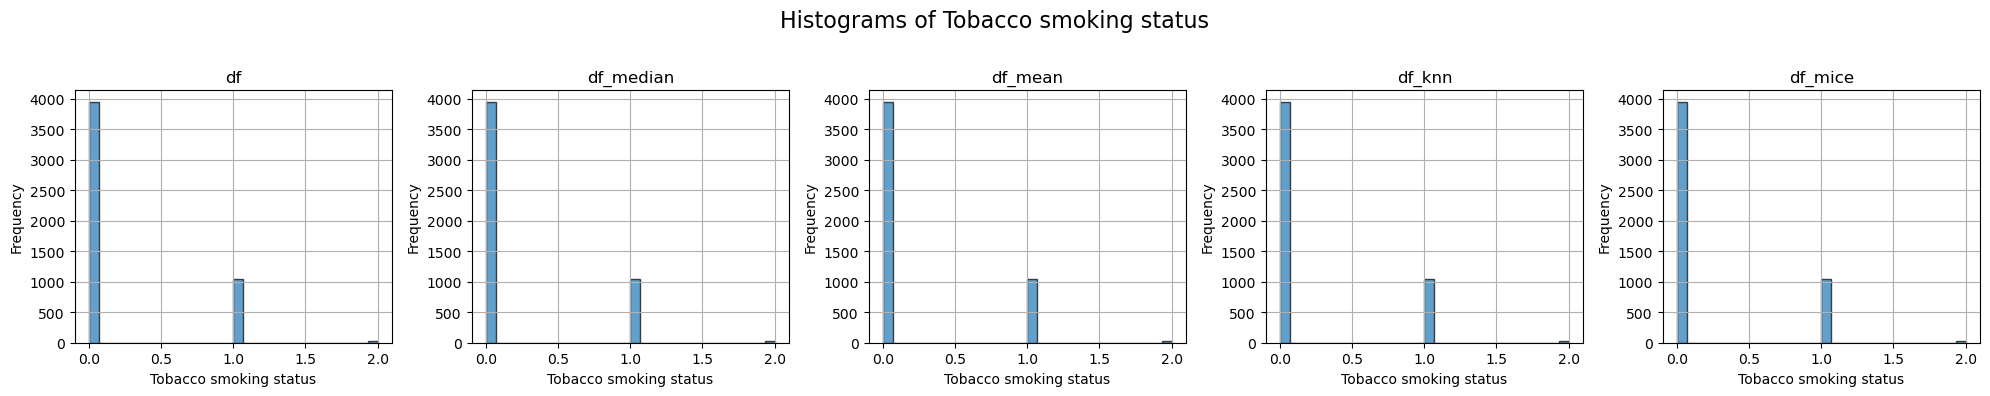

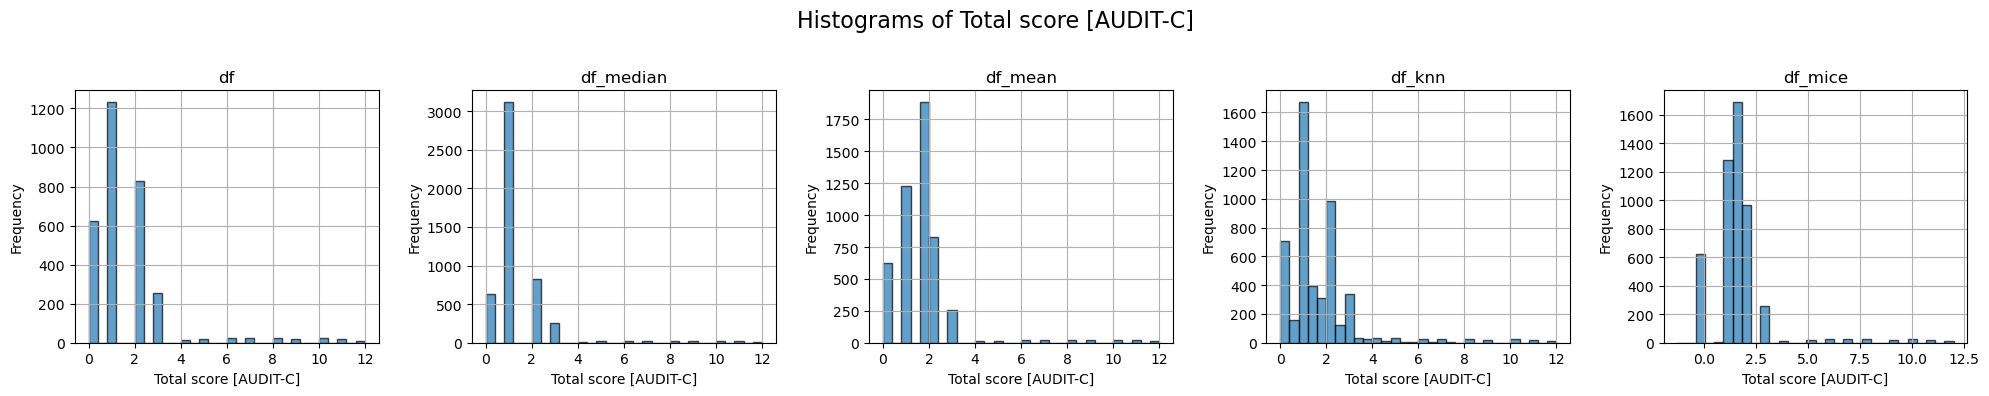

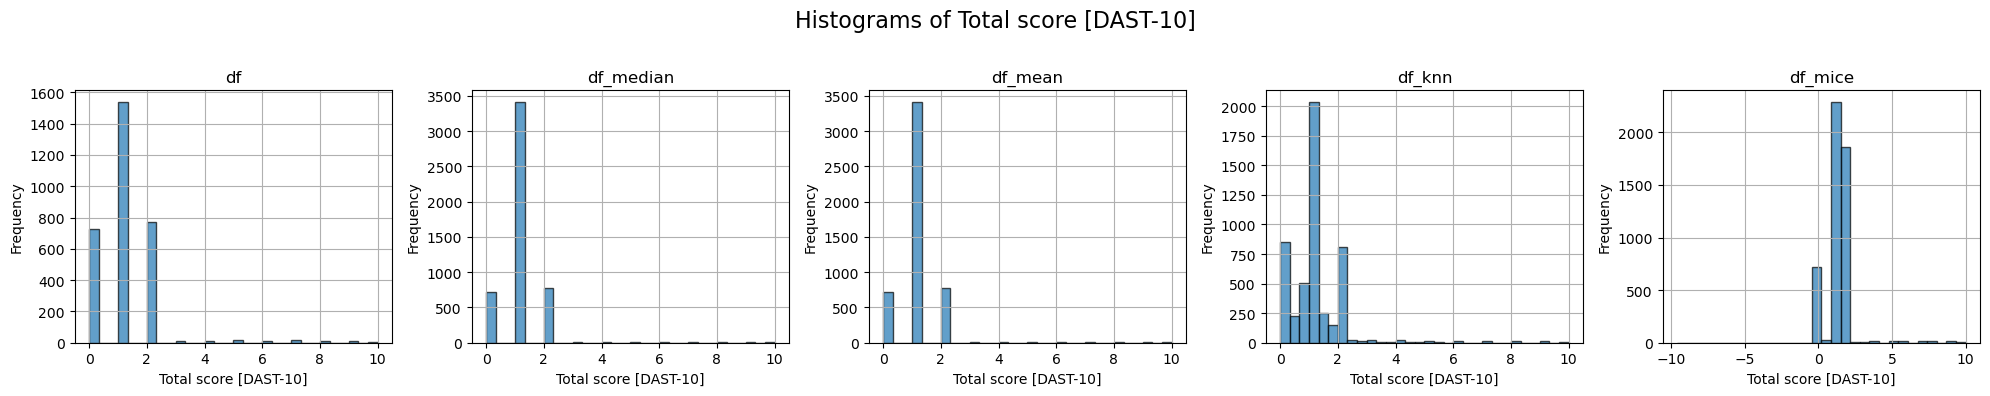

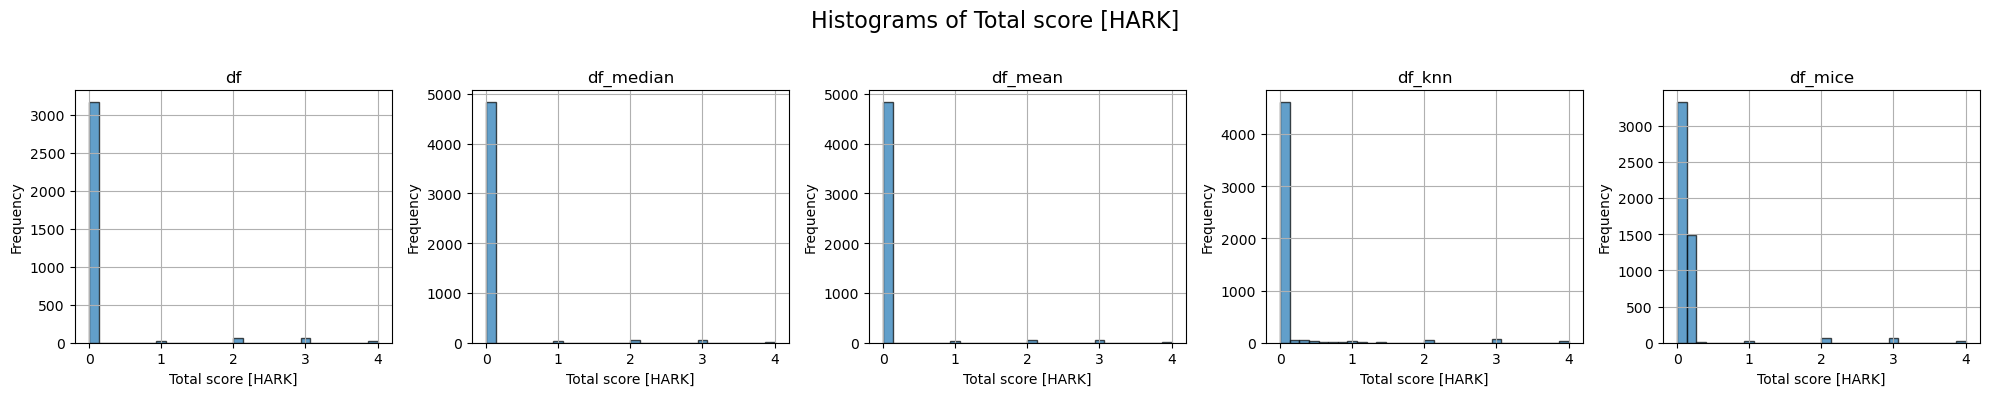

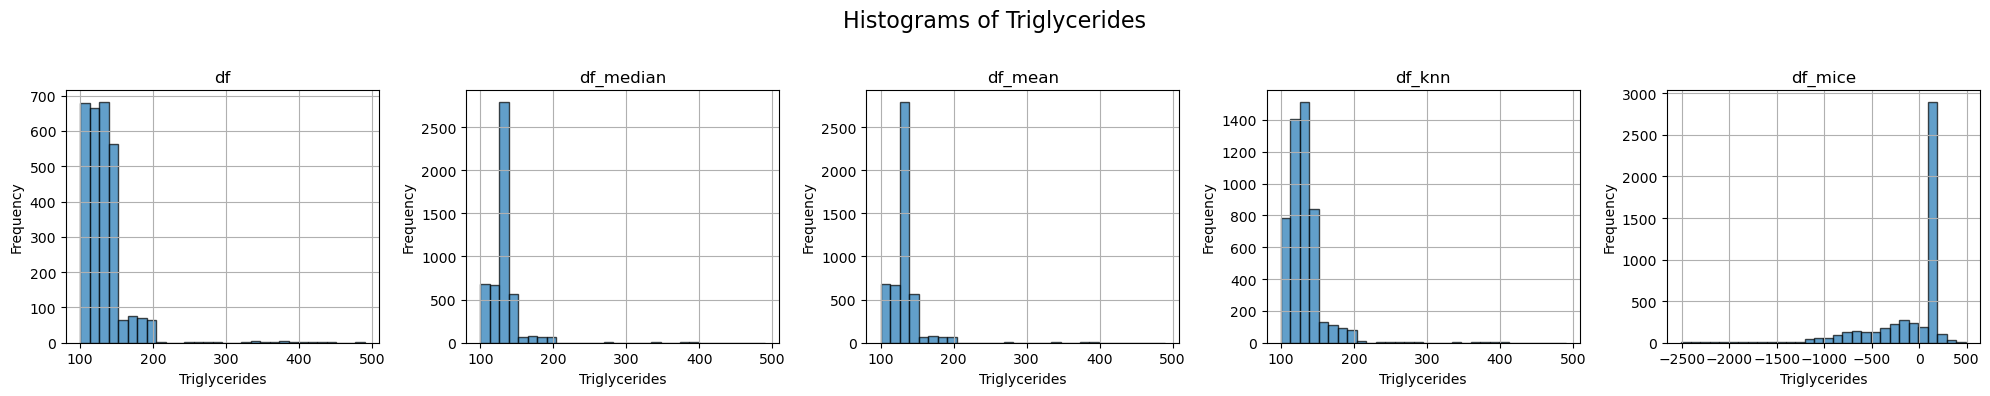

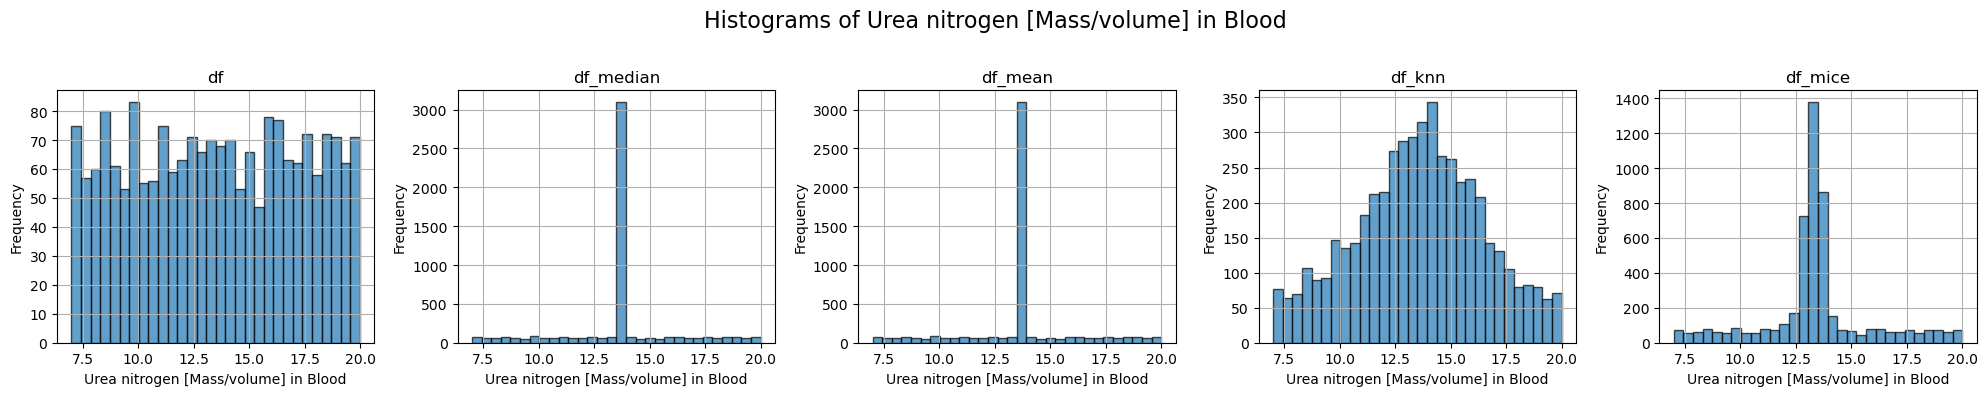

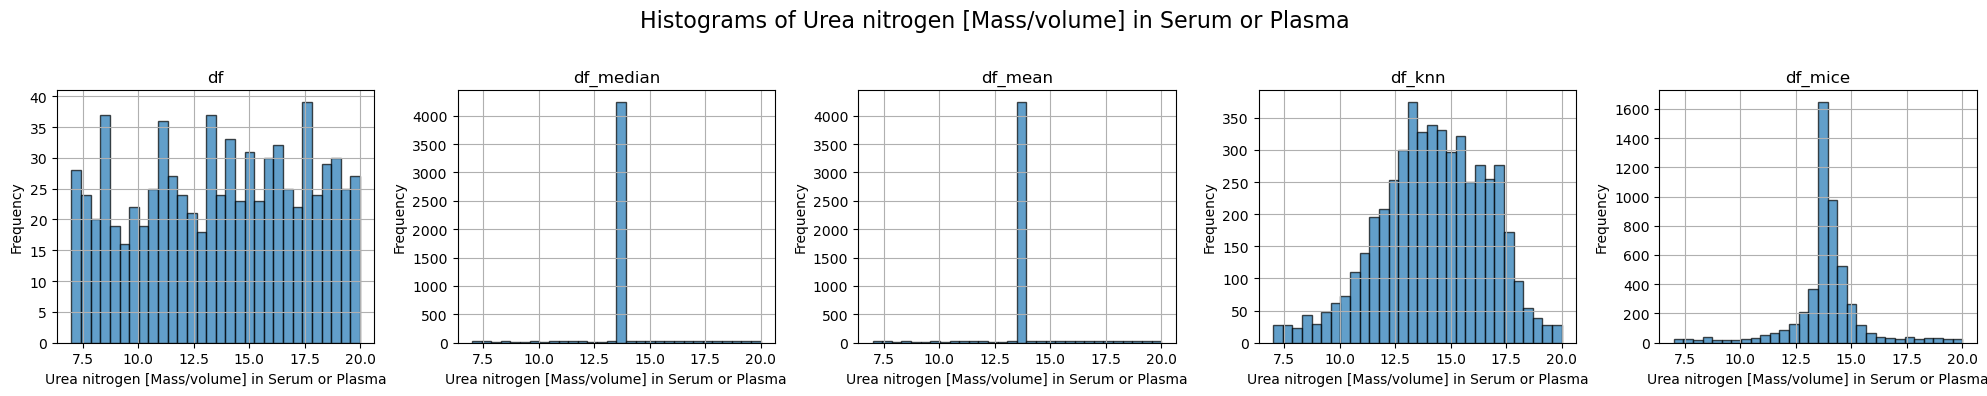

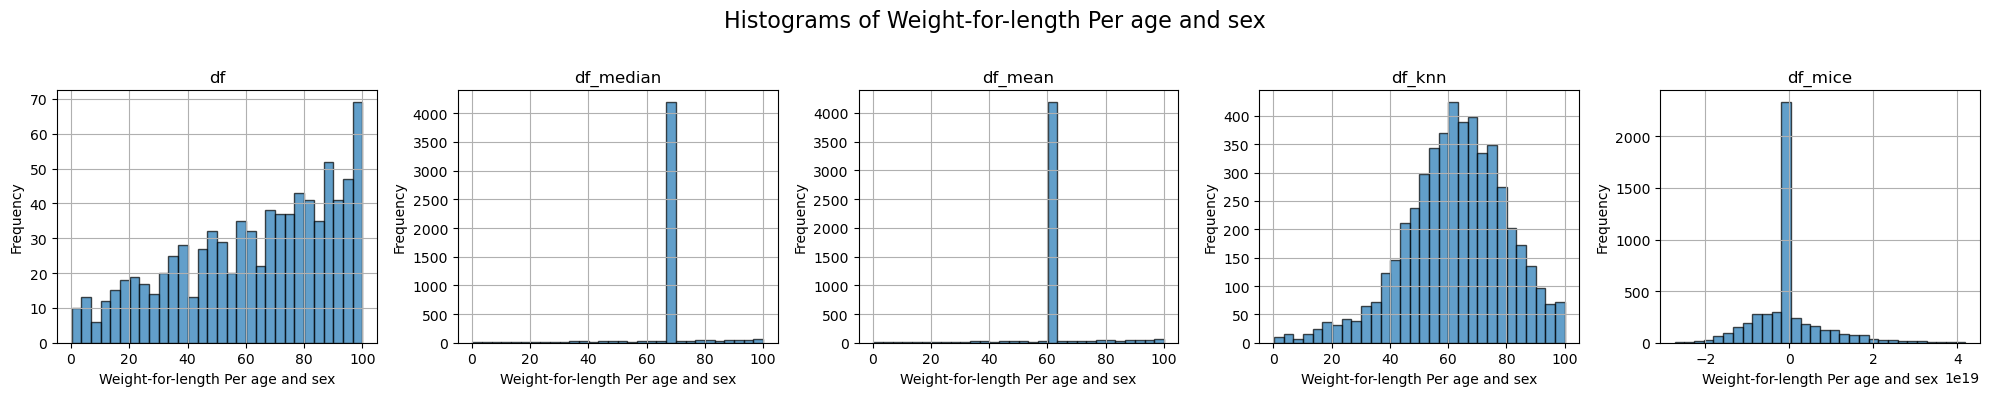

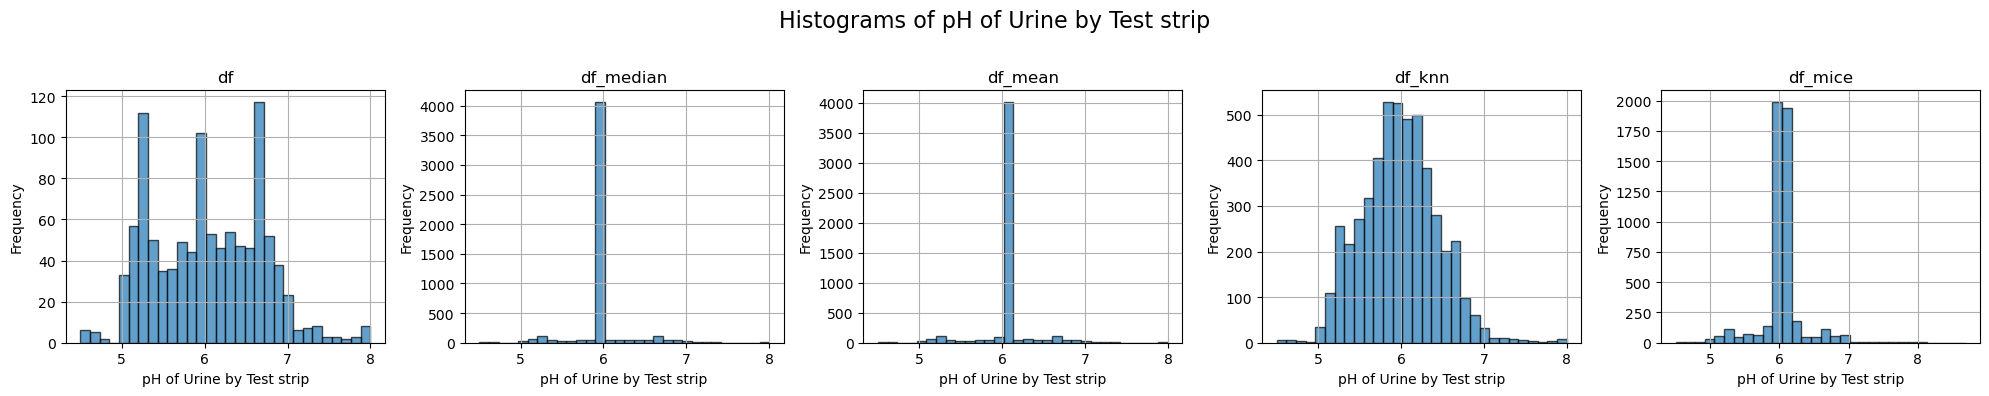

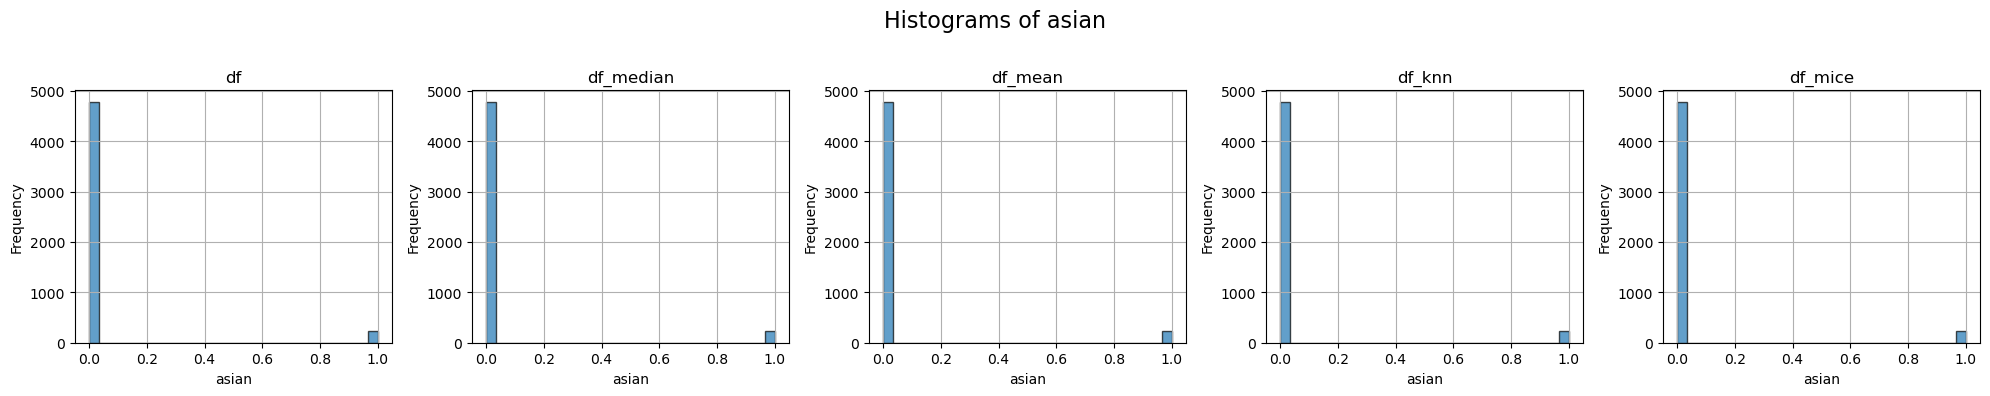

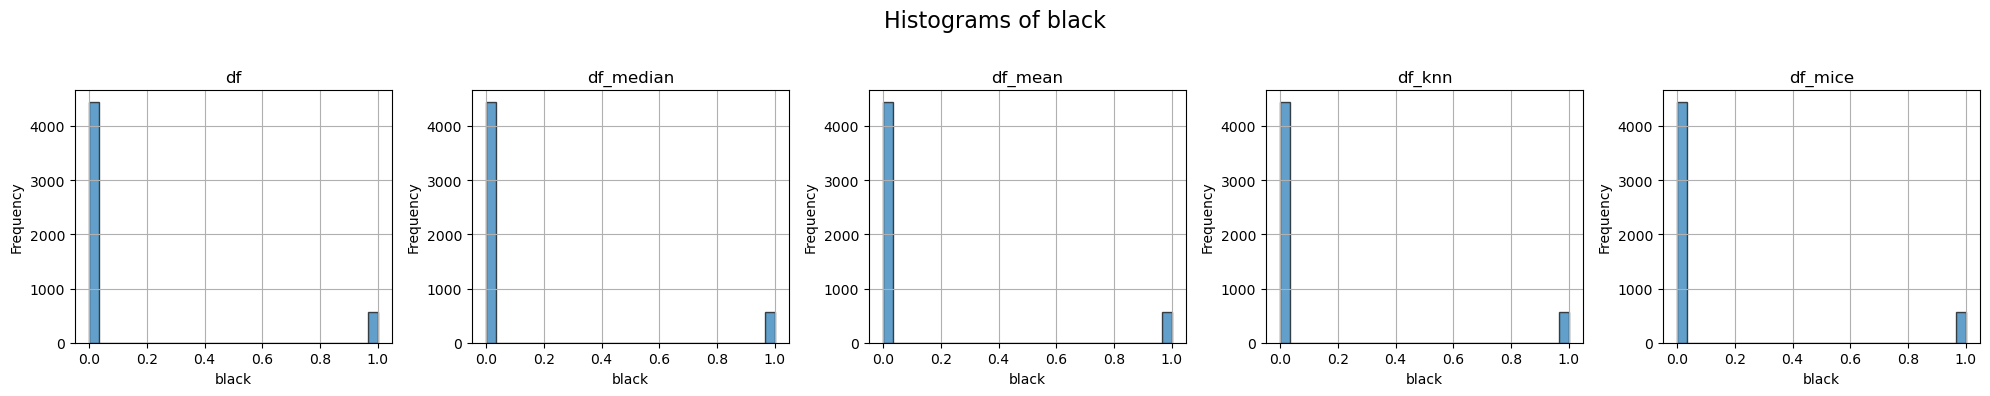

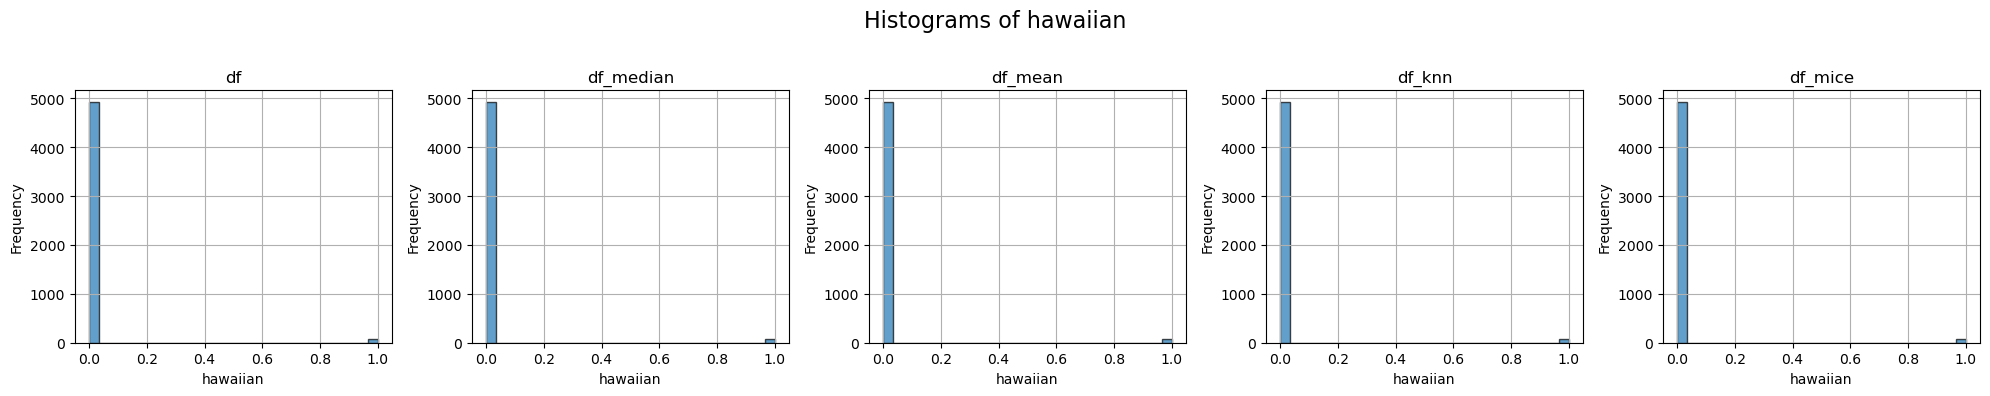

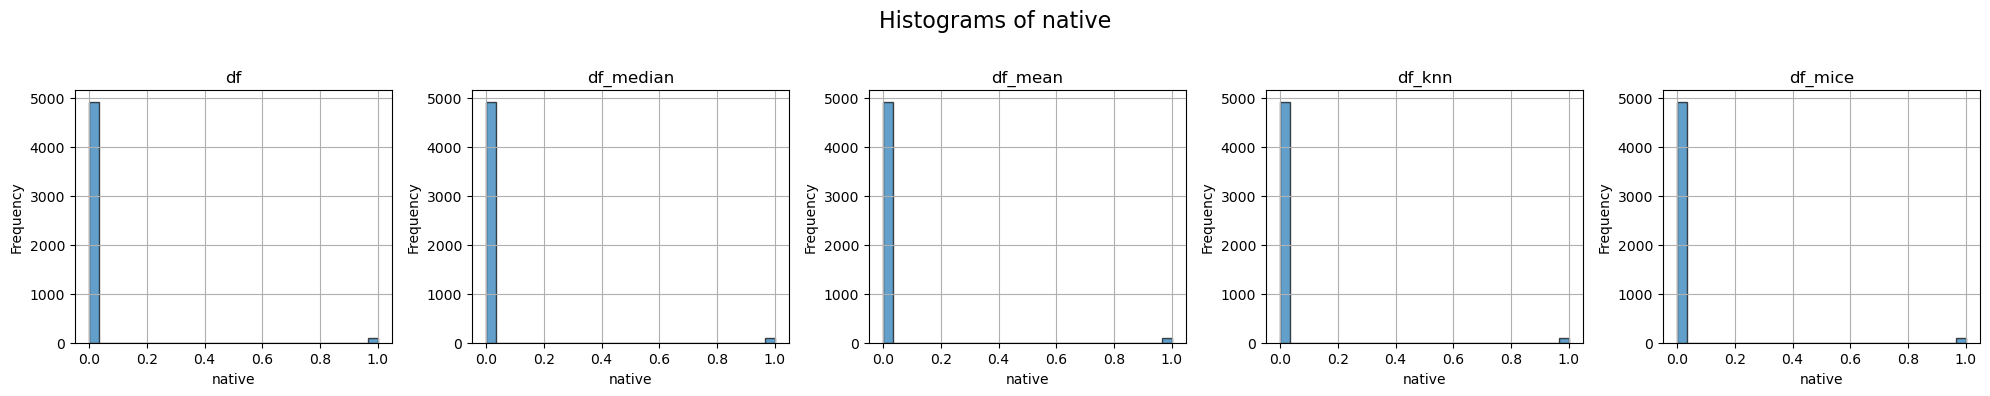

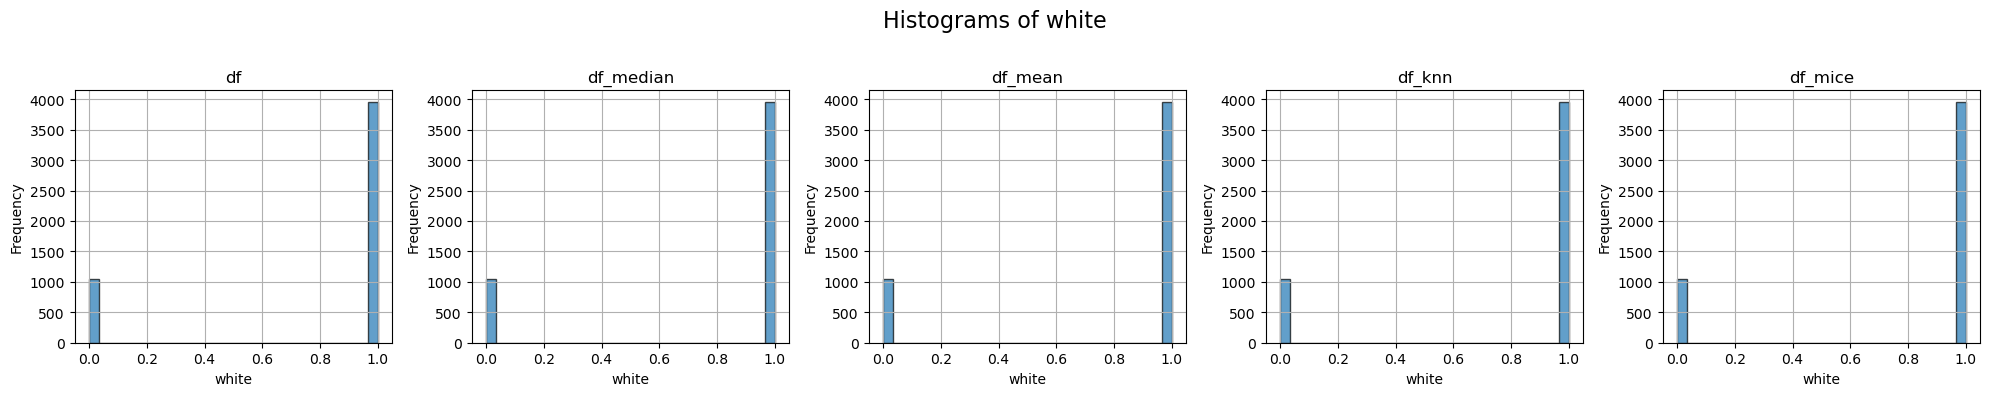

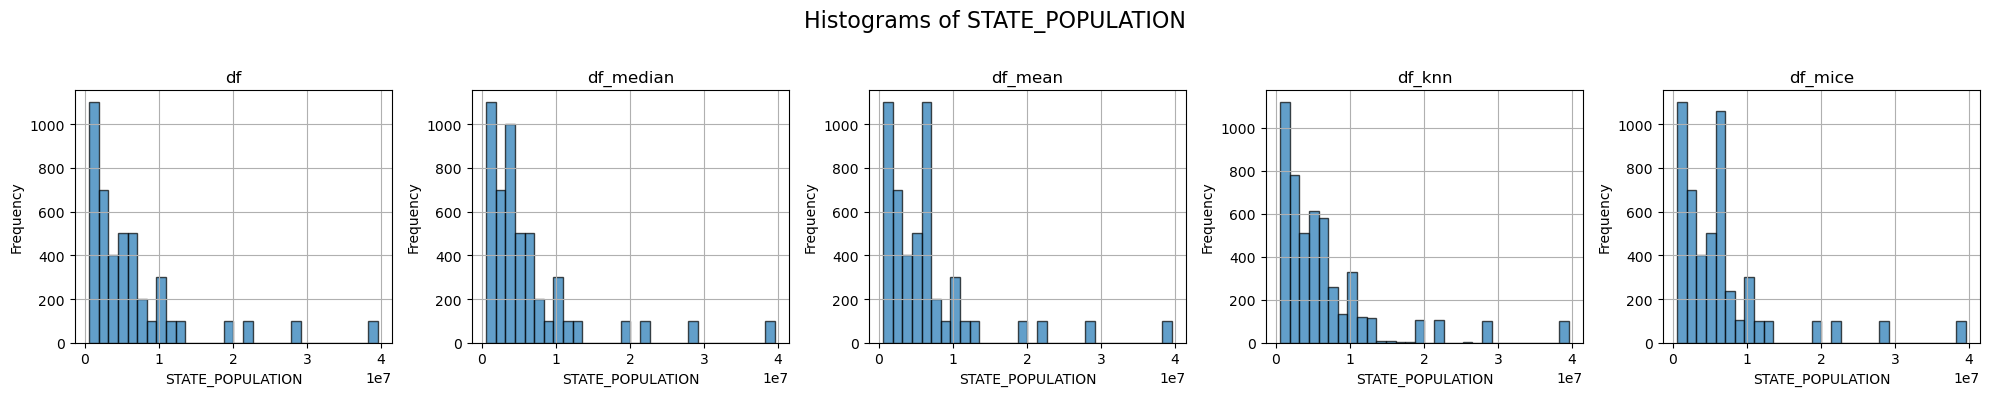

In [36]:
dataframes = [df, df_median, df_mean, df_knn, df_mice]
dataframe_names = ['df', 'df_median', 'df_mean', 'df_knn', 'df_mice']

num_dataframes = len(dataframes)

for column in dataframes[0].columns:
    fig, axes = plt.subplots(1, num_dataframes, figsize = (20, 4))
    
    for idx, (df, ax) in enumerate(zip(dataframes, axes)):
        ax.hist(df[column].dropna(), bins = 30, alpha = 0.7, edgecolor = 'black')
        
        ax.set_title(dataframe_names[idx])
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True)
    
    plt.suptitle(f'Histograms of {column}', fontsize = 16)
    plt.tight_layout(rect = [0, 0, 1, 0.96])  
    plt.show()

In general, median, mean, and MICE imputation seems to create unimodal distributions that do not reflect the distribution of the original dataframe without imputed values. The KNN imputation method seems to make the distribution more normalized.

#### Principal component analysis (PCA)

PCA is performed to determine if dimensionality reduction should be considered.

In [40]:
def scale_pca(imputed_df, imputation_method):
    scaler = StandardScaler()
    imputed_df = imputed_df.drop(columns = ['encounters_cost'])
    imputed_df_scaled = scaler.fit_transform(imputed_df)

    imputed_df_pca = PCA().fit(imputed_df_scaled)

    plt.plot(imputed_df_pca.explained_variance_ratio_.cumsum())
    plt.xlabel('Component #')
    plt.ylabel('Cumulative variance ratio')
    plt.title('Cumulative variance ratio explained by PCA components using ' + imputation_method);

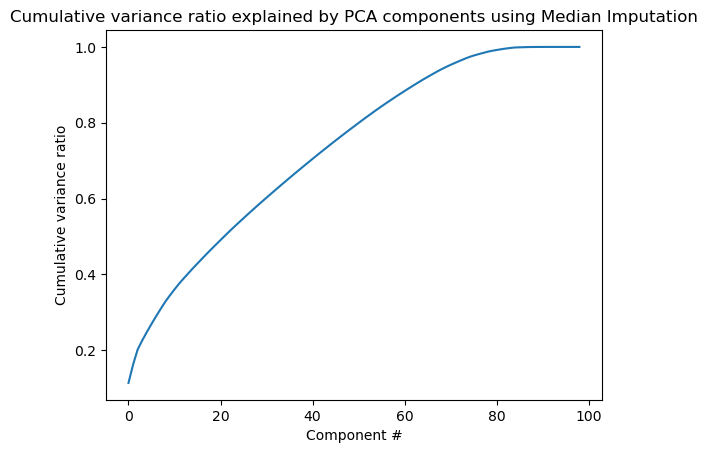

In [41]:
scale_pca(df_median, 'Median Imputation')

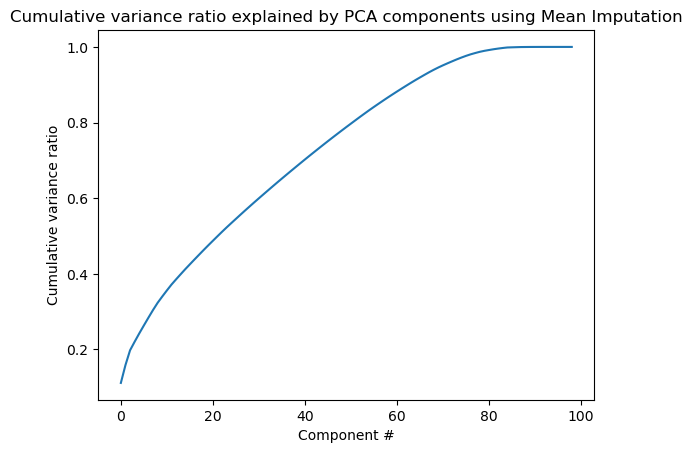

In [42]:
scale_pca(df_mean, 'Mean Imputation')

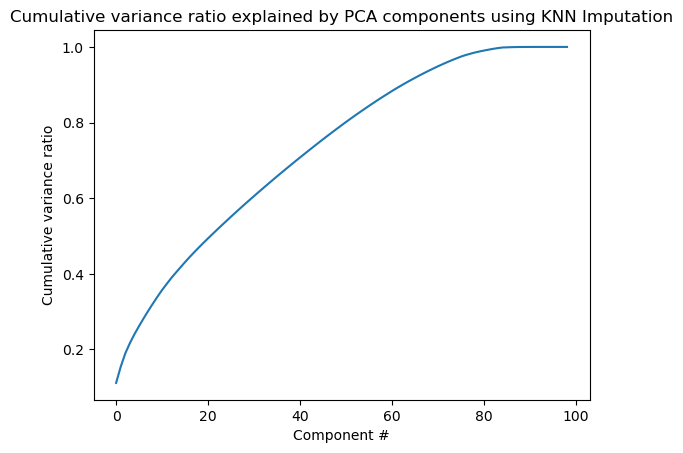

In [43]:
scale_pca(df_knn, 'KNN Imputation')

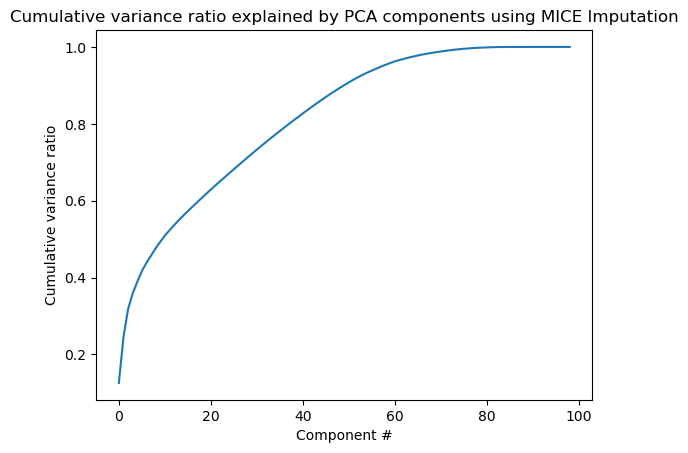

In [44]:
scale_pca(df_mice, 'MICE Imputation')

All imputation techniques showed that reducing the data to approximately 50 components would account for ~80% of the variance. This may be useful as the dataset has a lot of features, so reducing the dimensionality of the dataset may help with modeling and computation time.

The KNN imputation technique is selected as it produced the highest R squared score, resulted in somewhat normalized distributions of imputed variables, and had similar cumulative variance ratios to the other imputation techniques.

#### Dummy regression - mean value

To begin model development, the data is split into train and test sets, with 25% of the data reserved for testing.

In [49]:
X = df_knn.drop(columns = ['encounters_cost'])
y = df_knn['encounters_cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

For a baseline model, the mean value will be used as a predictor. This is performed using a dummy regressor.

In [51]:
train_mean = y_train.mean()
print(f'Mean value of training data: {train_mean:.2f}')

Mean value of training data: 15040.24


In [52]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg_constant = dumb_reg.constant_[0][0]
print(f'Dummy regressor constant value: {dumb_reg_constant:.2f}')

Dummy regressor constant value: 15040.24


The dummy regressor constant value is the same as the training mean, which is expected. The performance of this model is evaluated as a baseline comparison for future models.

In [54]:
y_train_pred = dumb_reg.predict(X_train)
y_test_pred = train_mean * np.ones(len(y_test))

In [55]:
def model_evaluation(y_train, y_train_pred, y_test, y_test_pred, title):
    print(title)
    print('')
    print('Training R squared:', round(r2_score(y_train, y_train_pred), 4))
    print('Testing R squared:', round(r2_score(y_test, y_test_pred), 4))
    print('')
    print('Training MAE:', round(mean_absolute_error(y_train, y_train_pred), 2))
    print('Testing MAE:', round(mean_absolute_error(y_test, y_test_pred), 2))
    print('')
    print('Training MSE:', round(mean_squared_error(y_train, y_train_pred), 2))
    print('Testing MSE:', round(mean_squared_error(y_test, y_test_pred),2))

In [56]:
model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Dummy regressor results:')

Dummy regressor results:

Training R squared: 0.0
Testing R squared: -0.0006

Training MAE: 18029.71
Testing MAE: 17276.07

Training MSE: 1214707483.91
Testing MSE: 1141617626.7


The R squared values are very low and the mean absolute error and mean squared error values are very high, showing that this is not a great fit for the model, as expected.

#### Scaling the data

For future modeling steps, the data is scaled.

In [60]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Linear Regression

The first model that will be evaluated is a linear regression model.

In [63]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Initial linear regression model results:')

Initial linear regression model results:

Training R squared: 0.5295
Testing R squared: 0.15

Training MAE: 12988.13
Testing MAE: 13135.7

Training MSE: 571529397.83
Testing MSE: 969787758.64


A pipeline is created that will select the best features using f regression.

In [65]:
lr_pipe = make_pipeline(SelectKBest(f_regression), LinearRegression())
lr_pipe.fit(X_train_scaled, y_train)
y_train_pred = lr_pipe.predict(X_train_scaled)
y_test_pred = lr_pipe.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression pipeline model results:')

Linear regression pipeline model results:

Training R squared: 0.417
Testing R squared: 0.4075

Training MAE: 12273.53
Testing MAE: 11292.99

Training MSE: 708207736.25
Testing MSE: 675961408.44


Cross validation is performed to further understand the performance of the model. 

In [67]:
cv_results = cross_validate(lr_pipe, X_train_scaled, y_train, cv = 5)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.38786314 0.31246984 0.32872722 0.50182771 0.44629639]
Mean R squared: 0.3954
Standard deviation R squared: 0.0711


A grid search will be performed to determine the best number of features to include.

In [69]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv = GridSearchCV(lr_pipe, param_grid = grid_params, cv = 5, n_jobs = -1)
lr_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001F5EB2AAD40>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

The means and standard deviations for the model with each k value is calculated and the best number of parameters is determined.

In [71]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

{'selectkbest__k': 89}

According to the model, the optimal number of parameters is 89. This will be visualized by plotting mean score versus number of parameters.

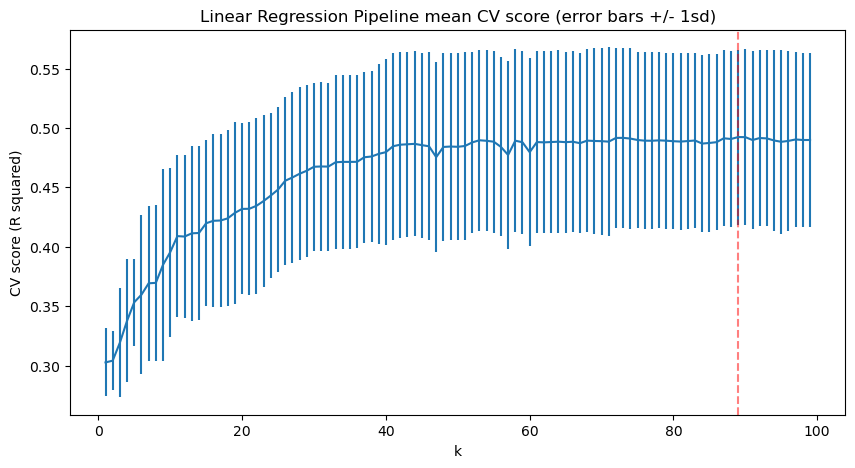

In [73]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize = (10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared)')
plt.title('Linear Regression Pipeline mean CV score (error bars +/- 1sd)');

The graph shows that the R squared value flattens out around 40 features, so it is not necessary to include 89.

In [75]:
lr_pipe_best = make_pipeline(SelectKBest(f_regression, k = 40), LinearRegression())
lr_pipe_best.fit(X_train_scaled, y_train)
y_train_pred = lr_pipe_best.predict(X_train_scaled)
y_test_pred = lr_pipe_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression pipeline model (k=40) results:')

Linear regression pipeline model (k=40) results:

Training R squared: 0.4632
Testing R squared: 0.3529

Training MAE: 14339.43
Testing MAE: 13889.45

Training MSE: 652085433.08
Testing MSE: 738304258.19


Since the testing R squared value is lower than the training R squared value, it can be concluded that the model is not overfitting. This model performed better than the dummy regressor model, but these are relatively low R squared values, so additional models will be tested.

#### Ridge Regression

Next, a ridge regression model will be tested.

In [79]:
ridge_scores = []
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]:
    ridge = Ridge(alpha = alpha, random_state = 123)
    ridge.fit(X_train_scaled, y_train)
    ridge_pred = ridge.predict(X_test_scaled)
    ridge_scores.append(ridge.score(X_test_scaled, y_test))
print('Ridge scores:', ridge_scores)

Ridge scores: [0.14827259895390354, 0.14868299004703533, 0.15380865980610237, 0.2114903966259345, 0.3315738205577512, 0.260505724074087]


These scores are low, but the score with the alpha value of 1000 is the highest so that will be selected. A pipeline is created that will select the best features using f regression.

In [81]:
ridge_pipe = make_pipeline(SelectKBest(f_regression), Ridge(alpha = 1000, random_state = 123))
ridge_pipe.fit(X_train_scaled, y_train)
y_train_pred = ridge_pipe.predict(X_train_scaled)
y_test_pred = ridge_pipe.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Ridge regression pipeline model results:')

Ridge regression pipeline model results:

Training R squared: 0.3761
Testing R squared: 0.3805

Training MAE: 11890.96
Testing MAE: 11137.2

Training MSE: 757892189.91
Testing MSE: 706760067.23


Cross validation is performed to further understand the performance of the model. 

In [83]:
cv_results = cross_validate(ridge_pipe, X_train_scaled, y_train, cv = 5)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.34981293 0.31308404 0.31876606 0.42607046 0.36407809]
Mean R squared: 0.3544
Standard deviation R squared: 0.0406


A grid search will be performed to determine the best number of features to include.

In [85]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
ridge_grid_cv = GridSearchCV(ridge_pipe, param_grid = grid_params, cv = 5, n_jobs = -1)
ridge_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001F5EB2AAD40>)),
                                       ('ridge',
                                        Ridge(alpha=1000, random_state=123))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

The means and standard deviations for the model with each k value is calculated and the best number of parameters is determined.

In [87]:
score_mean = ridge_grid_cv.cv_results_['mean_test_score']
score_std = ridge_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in ridge_grid_cv.cv_results_['param_selectkbest__k']]
ridge_grid_cv.best_params_

{'selectkbest__k': 90}

According to the model, the optimal number of parameters is 90. This will be visualized by plotting mean score versus number of parameters.

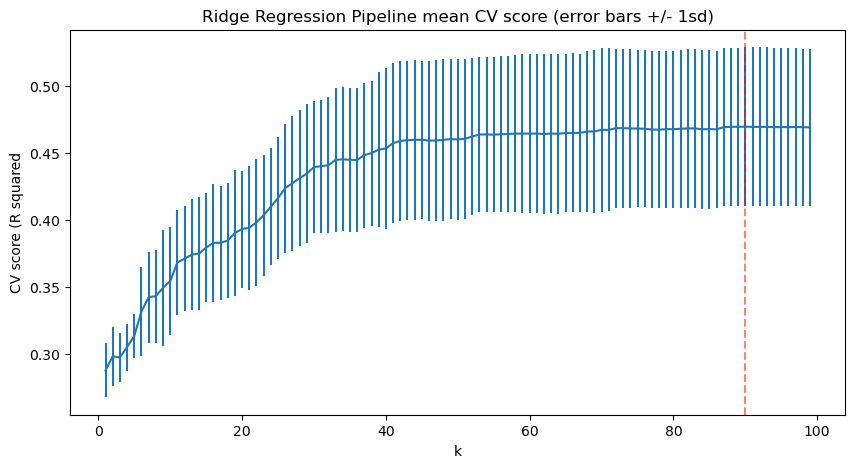

In [89]:
best_k = ridge_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared')
plt.title('Ridge Regression Pipeline mean CV score (error bars +/- 1sd)');

Just like the linear regression model, the graph shows that the R squared value flattens out around 40 features, so it is not necessary to include 72.

In [91]:
ridge_pipe_best = make_pipeline(SelectKBest(f_regression, k = 40), Ridge(alpha = 1000, random_state = 123))
ridge_pipe_best.fit(X_train_scaled, y_train)
y_train_pred = ridge_pipe_best.predict(X_train_scaled)
y_test_pred = ridge_pipe_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Ridge regression pipeline model (k=40) results:')

Ridge regression pipeline model (k=40) results:

Training R squared: 0.4741
Testing R squared: 0.3587

Training MAE: 12318.28
Testing MAE: 12186.22

Training MSE: 638806970.44
Testing MSE: 731626360.26


Since the testing R squared value is lower than the training R squared value, it can be concluded that the model is not overfitting. However, these R squared values are pretty similar to the linear regression model, so the ridge model is not much of an improvement.

#### Lasso regression

Next, a lasso regression model will be tested.

In [95]:
lasso_scores = []
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]:
    lasso = Lasso(alpha = alpha, random_state = 123)
    lasso.fit(X_train_scaled, y_train)
    lasso_pred = lasso.predict(X_test_scaled)
    lasso_scores.append(lasso.score(X_test_scaled, y_test))
print('Lasso scores:', lasso_scores)

Lasso scores: [0.14823400003542653, 0.14870641847750166, 0.15209841943083968, 0.20540489054446154, 0.45813719933839936, 0.23535887271700884]


These scores are pretty low, but the score with the alpha value of 1000 is the highest so that will be selected. A pipeline is created that will select the best features using f regression.

In [97]:
lasso_pipe = make_pipeline(SelectKBest(f_regression), Lasso(alpha = 1000, random_state = 123))
lasso_pipe.fit(X_train_scaled, y_train)
y_train_pred = lasso_pipe.predict(X_train_scaled)
y_test_pred = lasso_pipe.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Lasso regression pipeline model results:')

Lasso regression pipeline model results:

Training R squared: 0.4007
Testing R squared: 0.4031

Training MAE: 11841.42
Testing MAE: 11214.42

Training MSE: 728012493.97
Testing MSE: 681024362.16


Cross validation is performed to further understand the performance of the model. 

In [99]:
cv_results = cross_validate(lasso_pipe, X_train_scaled, y_train, cv = 5)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.3565667  0.33090961 0.3257119  0.46093566 0.40218941]
Mean R squared: 0.3753
Standard deviation R squared: 0.0507


A grid search will be performed to determine the best number of features to include.

In [101]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lasso_grid_cv = GridSearchCV(lasso_pipe, param_grid = grid_params, cv = 5, n_jobs = -1)
lasso_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001F5EB2AAD40>)),
                                       ('lasso',
                                        Lasso(alpha=1000, random_state=123))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

The means and standard deviations for the model with each k value is calculated and the best number of parameters is determined.

In [103]:
score_mean = lasso_grid_cv.cv_results_['mean_test_score']
score_std = lasso_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lasso_grid_cv.cv_results_['param_selectkbest__k']]
lasso_grid_cv.best_params_

{'selectkbest__k': 87}

According to the model, the optimal number of parameters is 87. This will be visualized by plotting mean score versus number of parameters.

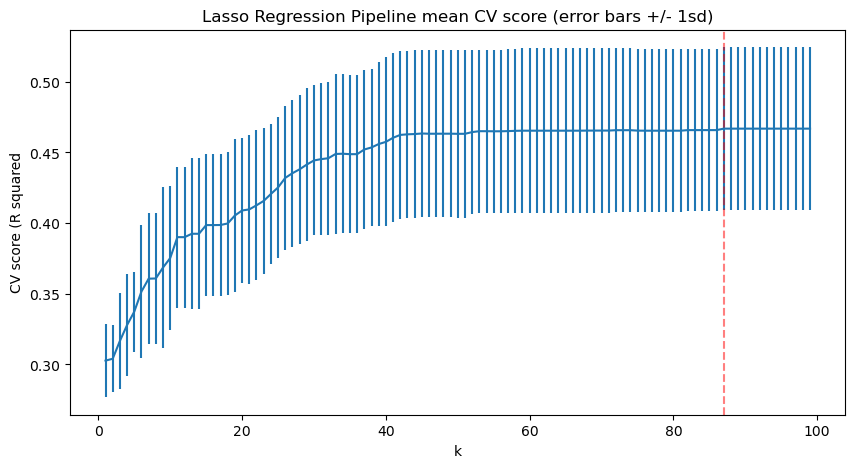

In [105]:
best_k = lasso_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared')
plt.title('Lasso Regression Pipeline mean CV score (error bars +/- 1sd)');

Once again, the graph shows that the R squared value flattens out around 40 features, so it is not necessary to include 87.

In [107]:
lasso_pipe_best = make_pipeline(SelectKBest(f_regression, k = 40), Lasso(alpha = 1000, random_state = 123))
lasso_pipe_best.fit(X_train_scaled, y_train)
y_train_pred = lasso_pipe_best.predict(X_train_scaled)
y_test_pred = lasso_pipe_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Lasso regression pipeline model (k=40) results:')

Lasso regression pipeline model (k=40) results:

Training R squared: 0.4786
Testing R squared: 0.4514

Training MAE: 11777.3
Testing MAE: 11282.72

Training MSE: 633292194.93
Testing MSE: 625898590.95


Since the testing R squared value is lower than the training R squared value, it can be concluded that the model is not overfitting. Again, the R squared scores are similar to that of the linear regression and ridge models, but the lasso testing R squared value is closer to the training R squared model, suggesting this model performed better with the testing data.

#### Random forest

Next, a random forest model will be evaluated.

In [111]:
rf_model = make_pipeline(RandomForestRegressor(n_estimators = 100, random_state = 123))
rf_model.fit(X_train_scaled, y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Initial random forest model results:')

Initial random forest model results:

Training R squared: 0.952
Testing R squared: 0.6131

Training MAE: 2253.08
Testing MAE: 5722.17

Training MSE: 58291084.52
Testing MSE: 441433240.64


Cross validation is performed to further understand the performance of the model. 

In [113]:
cv_results = cross_validate(rf_model, X_train_scaled, y_train, cv = 5)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.82858178 0.48417669 0.7935105  0.74330306 0.84054614]
Mean R squared: 0.7380
Standard deviation R squared: 0.1313


A grid search will be performed to determine the best number of trees to include in the random forest model.

In [115]:
n_est = [10, 25, 50, 75, 100]
grid_params = {'randomforestregressor__n_estimators': n_est}
rf_grid_cv = GridSearchCV(rf_model, param_grid = grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor(random_state=123))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 25, 50, 75,
                                                                 100]})

The means and standard deviations for the model are calculated and the best number of trees is determined.

In [117]:
score_mean = rf_grid_cv.cv_results_['mean_test_score']
score_std = rf_grid_cv.cv_results_['std_test_score']
cv_n_est = [n_est for n_est in rf_grid_cv.cv_results_['param_randomforestregressor__n_estimators']]
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 75}

According to the model, the optimal number of parameters is 75. This will be visualized by plotting mean score versus number of trees.

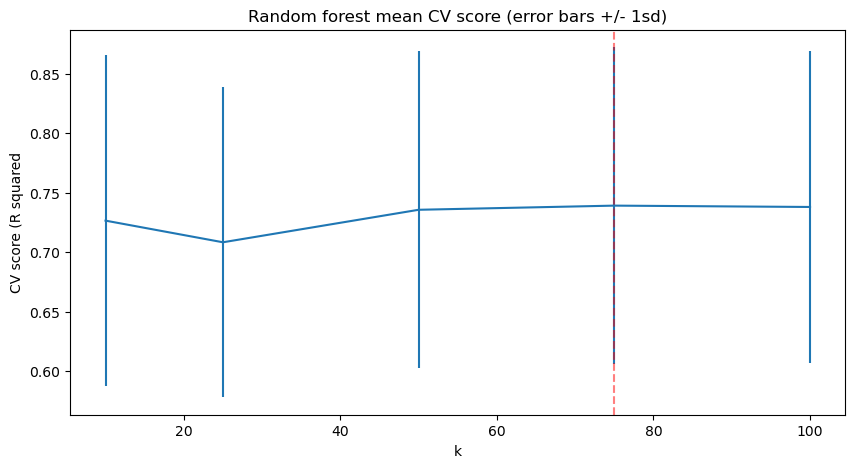

In [119]:
best_cv_n_est = rf_grid_cv.best_params_['randomforestregressor__n_estimators']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_n_est, score_mean, yerr = score_std)
plt.axvline(x = best_cv_n_est, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared')
plt.title('Random forest mean CV score (error bars +/- 1sd)');

The graph shows that the R squared value flattens out around 50 trees, so it is not necessary to include 75.

In [121]:
rf_model_best = make_pipeline(RandomForestRegressor(n_estimators = 50, random_state = 123))
rf_model_best.fit(X_train_scaled, y_train)
y_train_pred = rf_model_best.predict(X_train_scaled)
y_test_pred = rf_model_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Random forest model (trees = 50) results:')

Random forest model (trees = 50) results:

Training R squared: 0.9496
Testing R squared: 0.6027

Training MAE: 2265.28
Testing MAE: 5757.31

Training MSE: 61209442.37
Testing MSE: 453325237.45


In [122]:
cv_results = cross_validate(rf_model_best, X_train_scaled, y_train, cv = 5)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.82624335 0.48143304 0.80034713 0.72608647 0.84419912]
Mean R squared: 0.7357
Standard deviation R squared: 0.1333


Additionally, the top 10 most important parameters will be visualized.

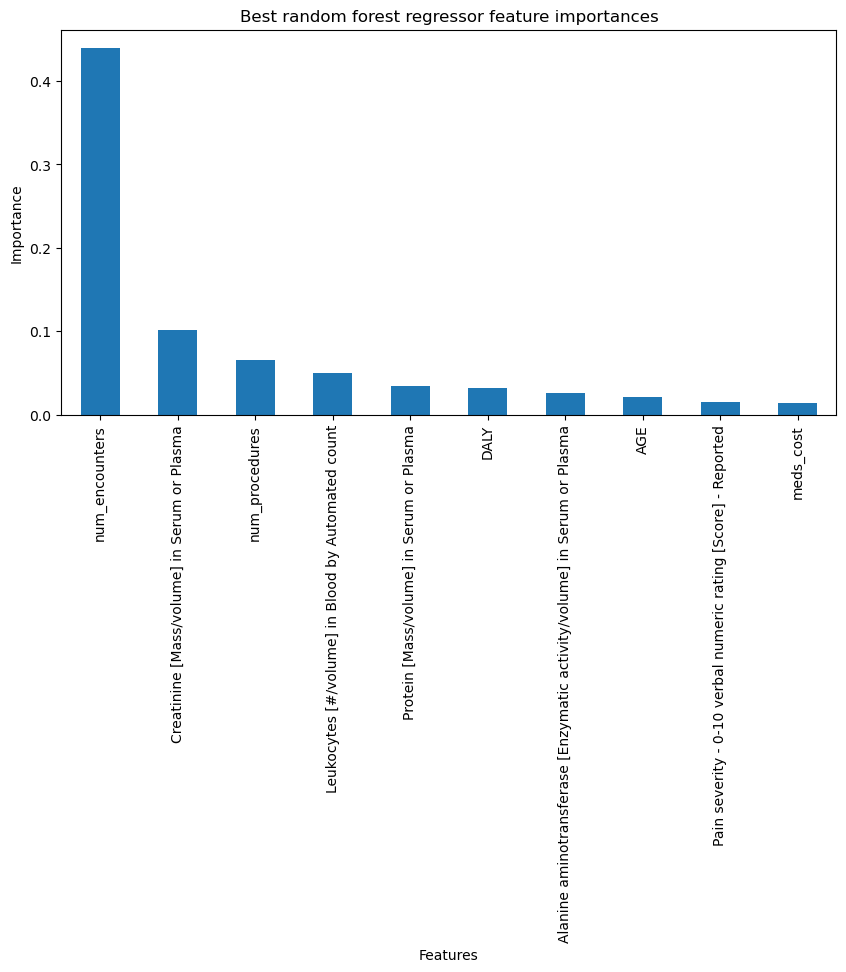

In [124]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index = X_train.columns).sort_values(ascending = False)[0:10]
rf_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best random forest regressor feature importances');